In [1]:
import os

In [107]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

BATCH_SIZE = 50
TEST_BATCH_SIZE = 5


TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 2
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2*math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu)**2)/(2*self.sigma**2)).sum()

class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi*prob1 + (1-self.pi)*prob2)).sum()
    
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight params
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias params
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0
        
    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0
        return F.linear(input, weight, bias)
    
    
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(30*258, 1000)
        self.l2 = BayesianLinear(1000, 40)
        self.l3 = BayesianLinear(40, 2)
    
    def forward(self, x, sample=False):
        x = x.view(-1, self.l1.in_features)
        #print(x.size())
        x = F.tanh(self.l1(x, sample))
        #print(x.size())
        x = F.tanh(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    #changed CLASSES to self.l3.out_features to allow for different class sizes when switching sources
    def sample_elbo(self, input, target, batch_idx, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, self.l3.out_features).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        #loss = (log_variational_posterior - log_prior)*(2**(NUM_BATCHES-batch_idx))/(2**NUM_BATCHES-1) + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

    
def write_weight_histograms(net, epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/w3_mu', net.l3.weight_mu,epoch)
    writer.add_histogram('histogram/w3_rho', net.l3.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)
    writer.add_histogram('histogram/b3_mu', net.l3.bias_mu,epoch)
    writer.add_histogram('histogram/b3_rho', net.l3.bias_rho,epoch)

def write_loss_scalars(net, epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)
    
    
    
def train(net, optimizer, epoch, train_loader):
    net.train()
    if epoch == 0: # write initial distributions
        write_weight_histograms(net, epoch)
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target,batch_idx)
        loss.backward()
        optimizer.step()
        write_loss_scalars(net, epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    write_weight_histograms(net, epoch+1)
    
    
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'





False


In [831]:
# To implement: regression with BMLP
class BayesianNetworkR(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(30*258, 1000)
        self.l2 = BayesianLinear(1000, 40)
        self.l3 = BayesianLinear(40, 2)
    
    def forward(self, x, sample=False):
        x = x.view(-1, self.l1.in_features)
        #print(x.size())
        x = F.tanh(self.l1(x, sample))
        #print(x.size())
        x = F.tanh(self.l2(x, sample))
        x = F.tanh(self.l3(x, sample))
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    #changed CLASSES to self.l3.out_features to allow for different class sizes when switching sources
    def sample_elbo(self, input, target, batch_idx, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, self.l3.out_features).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = nn.GaussianNLLLoss(outputs.mean(0), target, var=torch.ones_like(target))
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        #loss = (log_variational_posterior - log_prior)*(2**(NUM_BATCHES-batch_idx))/(2**NUM_BATCHES-1) + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

In [793]:
# check dimensions of sigmas
fnet.l3.weight.sigma[1,:]

tensor([0.0112, 0.0070, 0.0071, 0.0074, 0.0076, 0.0179, 0.0074, 0.0166, 0.0117,
        0.0090], grad_fn=<SliceBackward>)

In [822]:
F.linear(fnet.l3.weight.sigma[1,:]*fnet.l3.weight.sigma[1,:],x*x)

tensor([0.6022, 0.6023], grad_fn=<SqueezeBackward3>)

In [829]:
torch.ones_like(x)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [826]:
x = torch.tensor([[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],[2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0]])

In [98]:
TRAIN_SIZE, BATCH_SIZE, TEST_SIZE, TEST_BATCH_SIZE

(400, 50, 48, 5)

In [368]:
# train/test ensembling accuracy methods
def train_accuracy(net,CLASSES,train_loader):
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    num_trials = len(train_loader.dataset)
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('Component accuracies:')
    print([num for index, num in enumerate(corrects) if index<TEST_SAMPLES])
    print('Posterior Mean Train Accuracy: {}/{}'.format(corrects[-1], num_trials))
    print('Ensemble Train Accuracy: {}/{}'.format(correct, num_trials))
    return (corrects[-1]/np.float(num_trials), correct/np.float(num_trials))

In [369]:
def test_accuracy(net,CLASSES,test_loader):
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    num_trials=len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False) #outputs of each sample
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('Component accuracies:')
    print([num for index, num in enumerate(corrects) if index<TEST_SAMPLES])
    print('Posterior Mean Test Accuracy: {}/{}'.format(corrects[-1], num_trials))
    print('Ensemble Test Accuracy: {}/{}'.format(correct, num_trials))
    return (corrects[-1]/np.float(num_trials), correct/np.float(num_trials))

In [1427]:
# DATA LOADER (90%/10%)

def loaders(session):
    
    decision = data['decision_'+str(session)]
    firing_rate = data['output_'+str(session)]
    
    num_trials = decision.shape[0]
    
    train_idxs = np.arange(0,(int(num_trials*0.9)//50)*50)
    test_idxs = np.arange((int(num_trials*0.9)//50)*50,5*(num_trials//5))

    train_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(firing_rate[train_idxs]), 
        torch.Tensor(decision).type(torch.LongTensor).argmax(dim=1)[train_idxs])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50)
    test_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(firing_rate[test_idxs]),
        torch.Tensor(decision).type(torch.LongTensor).argmax(dim=1)[test_idxs])

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)
    return train_loader,test_loader

In [1368]:
# Load ALL DATA (for downstream session in zero-shot experiments)

def load_all(session):
    
    decision = data['decision_'+str(session)]
    firing_rate = data['output_'+str(session)]
    
    num_trials = decision.shape[0]
    
    idxs = np.arange(0,5*(num_trials//5))

    all_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(firing_rate[idxs]), 
        torch.Tensor(decision).type(torch.LongTensor).argmax(dim=1)[idxs])

    all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=TEST_BATCH_SIZE)

    return all_loader

In [5]:
#IBL DATA 

In [3]:
indices={
    'Cluster ID': [0],
    'Lab ID': np.arange(1,1+9),
    'Cluster xyz location': np.arange(1+9,1+9+3),
    'Cluster max ptp': np.arange(1+9+3,1+9+3+1),
    'Cluster waveform width': np.arange(1+9+3+1,1+9+3+1+1),
    'Left DLC': np.arange(1+9+3+1+1,1+9+3+1+1+14),
    'Right DLC': np.arange(1+9+3+1+1+14,1+9+3+1+1+14+14),
    'stimOn/Off': np.arange(1+9+3+1+1+14+14,1+9+3+1+1+14+14+1),
    'Contrast (left/right)': np.arange(1+9+3+1+1+14+14+1,1+9+3+1+1+14+14+1+2),
    'goCue': np.arange(1+9+3+1+1+14+14+1+2,1+9+3+1+1+14+14+1+2+1),
    'Choice': np.arange(1+9+3+1+1+14+14+1+2+1,1+9+3+1+1+14+14+1+2+1+3),
    'Reward type': np.arange(1+9+3+1+1+14+14+1+2+1+3,1+9+3+1+1+14+14+1+2+1+3+2),
    'Wheel velocity': np.arange(1+9+3+1+1+14+14+1+2+1+3+2,1+9+3+1+1+14+14+1+2+1+3+2+1),
    'pLeft': np.arange(1+9+3+1+1+14+14+1+2+1+3+2+1,1+9+3+1+1+14+14+1+2+1+3+2+1+1),
    'Lick': np.arange(1+9+3+1+1+14+14+1+2+1+3+2+1+1,1+9+3+1+1+14+14+1+2+1+3+2+1+1+1),
    'Atlas ID': np.arange(1+9+3+1+1+14+14+1+2+1+3+2+1+1+1,1+9+3+1+1+14+14+1+2+1+3+2+1+1+1+28)}

In [1061]:
data = {}
j = 1
for filename in os.listdir('/Users/ksaniee/Downloads/dataset 0614'):
    if 'output' in filename:
        session = filename[filename.find('_')+1:]
        data['output_%d'%j] = np.load('/Users/ksaniee/Downloads/dataset 0614/'+'output_'+session)
        data['feature_%d'%j] = np.load('/Users/ksaniee/Downloads/dataset 0614/'+'feature_'+session)
        j+=1
    

In [1062]:
for filename in os.listdir('/Users/ksaniee/Downloads/dataset 0614'):
    if 'output' in filename:
        session = filename[filename.find('_')+1:]
        file = np.load('/Users/ksaniee/Downloads/dataset 0614/'+'output_'+session)
        print('session %s: length %d'% (filename[filename.find('_')+1:filename.find('.')],file.shape[1]) )

session dac3a4c1-b666-4de0-87e8-8c514483cacf: length 448
session 746d1902-fa59-4cab-b0aa-013be36060d5: length 592
session c7248e09-8c0d-40f2-9eb4-700a8973d8c8: length 732
session 7b26ce84-07f9-43d1-957f-bc72aeb730a3: length 829
session b03fbc44-3d8e-4a6c-8a50-5ea3498568e0: length 257
session 6f09ba7e-e3ce-44b0-932b-c003fb44fb89: length 329
session ee40aece-cffd-4edb-a4b6-155f158c666a: length 969
session 56b57c38-2699-4091-90a8-aba35103155e: length 533
session 4a45c8ba-db6f-4f11-9403-56e06a33dfa4: length 256
session aad23144-0e52-4eac-80c5-c4ee2decb198: length 525
session 54238fd6-d2d0-4408-b1a9-d19d24fd29ce: length 583
session e535fb62-e245-4a48-b119-88ce62a6fe67: length 366
session 3638d102-e8b6-4230-8742-e548cd87a949: length 502
session d0ea3148-948d-4817-94f8-dcaf2342bbbe: length 453
session db4df448-e449-4a6f-a0e7-288711e7a75a: length 332
session d23a44ef-1402-4ed7-97f5-47e9a7a504d9: length 334
session 41872d7f-75cb-4445-bb1a-132b354c44f0: length 412


In [363]:
file.shape[1]

(10, 412, 44)

In [1063]:
# Reshape all clusters to single dimension
for j in range(1,18):
    data['output_'+str(j)]=data['output_'+str(j)].transpose((1,0,2)).reshape((-1,10*44))

In [1064]:
# Decision data
for j in range(1,18):
    data['decision_'+str(j)]=data['feature_'+str(j)][:,:,:,indices['Choice']].sum(2)[0,:,:]

In [1364]:
# One-hot encode no choice
for j in range(1,18):
    data['decision_'+str(j)]=np.apply_along_axis(lambda x: [0.,1.,0.] if sum(x)==0 else x,1,data['decision_'+str(j)])

In [1065]:
# Normalize firing rates to clusters
for s in range(1,18):
    firing_rate = data['output_'+str(s)]
    for k in range(10):
        firing_rate[:,k*44:44*(k+1)] = (firing_rate[:,k*44:44*(k+1)]-firing_rate[:,k*44:44*(k+1)].mean())/firing_rate[:,k*44:44*(k+1)].std()
    data['output_'+str(s)] = firing_rate


In [1066]:
# no. trials of all sessions
for j in range(1,18): print('Session %d: %d trials'%(j, data['decision_'+str(j)].shape[0]))

Session 1: 448 trials
Session 2: 592 trials
Session 3: 732 trials
Session 4: 829 trials
Session 5: 257 trials
Session 6: 329 trials
Session 7: 969 trials
Session 8: 533 trials
Session 9: 256 trials
Session 10: 525 trials
Session 11: 583 trials
Session 12: 366 trials
Session 13: 502 trials
Session 14: 453 trials
Session 15: 332 trials
Session 16: 334 trials
Session 17: 412 trials


In [1159]:
# Should use this with actual mouse prior (in this data, 'pLeft' is the experimental outcome probability, not mouse's prior)
def bayes_decision(s, trial):
    p = data['feature_%d'%s][7,trial,:,indices['pLeft']].max()
    if p>0.5: return [1.,0.,0.]
    if p<0.5: return [0.,0.,1.]
    else: 
        r = 1-2*np.sum(np.random.uniform()>0.5) #flip coin
        if r>0.5: return [1.,0.,0.]
        else: return [0.,0.,1.]

In [1210]:
for s in range(1,18):
    print(data['feature_%d'%s][:,:,:,indices['Contrast (left/right)']][9,:,8,:].argmax(1).mean())

0.48214285714285715
0.44932432432432434
0.37841530054644806
0.4499396863691194
0.5797665369649806
0.3465045592705167
0.41279669762641896
0.4333958724202627
0.37890625
0.4819047619047619
0.3567753001715266
0.46994535519125685
0.3745019920318725
0.4988962472406181
0.4307228915662651
0.5
0.48058252427184467


In [1143]:
# percent of L/R/'no choices' per session
for s in range(1,18):
    print('session %d  L: %f,R: %f,no: %f'%(s,
        (data['decision_%d'%s].sum(0)[0]/data['decision_%d'%s].shape[0]),
         (data['decision_%d'%s].sum(0)[2]/data['decision_%d'%s].shape[0]),
        (data['decision_%d'%s].sum(1)==0).sum()/data['decision_%d'%s].shape[0]))

session 1  L: 0.569196,R: 0.395089,no: 0.035714
session 2  L: 0.596284,R: 0.375000,no: 0.028716
session 3  L: 0.397541,R: 0.557377,no: 0.045082
session 4  L: 0.554885,R: 0.408926,no: 0.036188
session 5  L: 0.649805,R: 0.330739,no: 0.019455
session 6  L: 0.331307,R: 0.659574,no: 0.009119
session 7  L: 0.421053,R: 0.575851,no: 0.003096
session 8  L: 0.429644,R: 0.540338,no: 0.030019
session 9  L: 0.320312,R: 0.609375,no: 0.070312
session 10  L: 0.518095,R: 0.419048,no: 0.062857
session 11  L: 0.461407,R: 0.466552,no: 0.072041
session 12  L: 0.442623,R: 0.491803,no: 0.065574
session 13  L: 0.503984,R: 0.362550,no: 0.133466
session 14  L: 0.615894,R: 0.357616,no: 0.026490
session 15  L: 0.379518,R: 0.560241,no: 0.060241
session 16  L: 0.760479,R: 0.224551,no: 0.014970
session 17  L: 0.514563,R: 0.361650,no: 0.123786


In [1078]:
# train on a session
train_loader,test_loader=loaders(5)
fnet = BayesianNetwork()
fnet.l1 = BayesianLinear(440,10)
fnet.l2 = BayesianLinear(10,10)
fnet.l3 = BayesianLinear(10,3)
fnet.to(DEVICE)
optimizer = optim.Adam(fnet.parameters())
for epoch in range(20):
    train(fnet, optimizer, epoch,train_loader)

  0%|          | 0/4 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 4/4 [00:00<00:00, 82.98it/s]


In [1102]:
#check predictions
outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, 3).to(DEVICE)
for i in range(TEST_SAMPLES):
    outputs[i] = fnet(d, sample=True)
outputs[TEST_SAMPLES] = fnet(d, sample=False) #outputs of each sample
output = outputs.mean(0)
preds = preds = outputs.max(2, keepdim=True)[1]
pred = output.max(1, keepdim=True)[1] # index of max log-probability

In [1103]:
pred

tensor([[2],
        [0],
        [0],
        [0],
        [0]])

In [1092]:
t = iter(test_loader)

In [1101]:
d,target=next(t)
d,target

(tensor([[-0.8108, -0.8108,  0.6328,  ..., -1.2754,  0.1951,  0.1951],
         [ 2.0764,  0.6328,  0.6328,  ..., -0.5402,  0.1951, -0.5402],
         [ 0.6328,  0.6328, -0.8108,  ...,  0.9303,  0.1951, -0.5402],
         [ 0.6328, -0.8108,  2.0764,  ...,  1.6655,  0.9303,  0.9303],
         [-0.8108, -0.8108, -0.8108,  ..., -0.5402, -0.5402, -0.5402]]),
 tensor([0, 0, 0, 2, 0]))

In [1011]:
# Load region dictionary
dictionary = np.load('/Users/ksaniee/Downloads/acronym_dict_new.npy',allow_pickle=True)
dictionary = {'POL': 0, 'VISa5': 1, 'DG-po': 2, 'CA1': 3, 'fp': 4, 'FF': 5, 'Eth': 6, 'VPL': 7, 'CA3': 8, 'alv': 9, 'PoT': 10, 'VISp6b': 11, 'VPLpc': 12, 'DG-sg': 13, 'SPFp': 14, 'LGd-co': 15, 'or': 16, 'PO': 17, 'LP': 18, 'PCN': 19, 'VPM': 20, 'SGN': 21, 'VISam6a': 22, 'ml': 23, 'VISp4': 24, 'HY': 25, 'APN': 26, 'VISa6a': 27}

dictionary = dict(zip(dictionary.values(),dictionary.keys()))
dictionary

# Regions in each Session
regions = []
for s in range(1,18):
    regions.append([dictionary[np.where(data['feature_%d'%s][r,1,5,indices['Atlas ID']]==1)[0][0]] for r in range(0,10)])
regions

[['PO', 'DG-po', 'DG-sg', 'LP', 'PO', 'DG-po', 'PO', 'LP', 'Eth', 'PCN'],
 ['PO', 'PO', 'VPLpc', 'VPLpc', 'FF', 'CA3', 'VPM', 'VPM', 'LP', 'VPM'],
 ['LP', 'or', 'LP', 'VISa5', 'or', 'PO', 'VISa6a', 'PO', 'LP', 'VISa5'],
 ['CA1', 'POL', 'LP', 'LP', 'CA1', 'CA1', 'LP', 'CA1', 'LP', 'DG-sg'],
 ['CA1', 'Eth', 'CA1', 'PO', 'PO', 'PO', 'LP', 'VISa6a', 'PO', 'CA1'],
 ['PO', 'PO', 'CA1', 'PO', 'PO', 'PoT', 'LP', 'PO', 'LP', 'LP'],
 ['LP', 'CA1', 'PoT', 'PO', 'ml', 'CA1', 'Eth', 'DG-sg', 'VISa5', 'Eth'],
 ['PO', 'DG-po', 'CA1', 'SPFp', 'ml', 'CA1', 'PO', 'ml', 'ml', 'CA1'],
 ['VPM', 'LGd-co', 'VPM', 'VPM', 'VPM', 'VPM', 'VPM', 'VPM', 'VPL', 'VPM'],
 ['LP', 'VISa6a', 'LP', 'LP', 'PO', 'VISa5', 'PO', 'CA1', 'VISa5', 'LP'],
 ['VPM', 'VPM', 'CA3', 'VPM', 'VPL', 'LGd-co', 'LP', 'VPM', 'LP', 'VISa6a'],
 ['CA1', 'CA1', 'CA1', 'APN', 'APN', 'APN', 'VISp4', 'CA1', 'APN', 'APN'],
 ['DG-sg', 'PoT', 'SGN', 'VISa5', 'DG-po', 'LP', 'SGN', 'PoT', 'SGN', 'PoT'],
 ['LP', 'Eth', 'VPLpc', 'FF', 'PO', 'PO', 'Eth',

<a list of 17 Text major ticklabel objects>

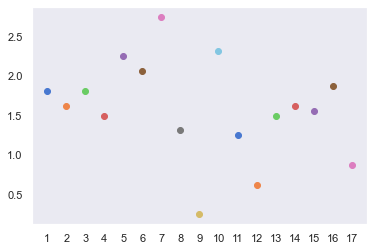

In [1268]:
# for each session, show average number of regions in common with all other sessions
def inter(l1,l2):
    return np.float(len(set(l1).intersection(set(l2))))

intersections = []
for s in range(1,18):
    inters = np.mean([inter(regions[s-1],regions[s2-1]) for s2 in range(1,18) if s2!=s])
    intersections.append(inters)
    plt.scatter(s,inters)
    
plt.xticks(np.arange(1,18))[1]

In [1278]:
list(intersection_sessions_desc).index(7)

0

In [1259]:
data['feature_%d'%s][1,:,:,indices['Cluster xyz location']][2,:,:]

array([[-0.001587, -0.001587, -0.001587, ..., -0.001587, -0.001587,
        -0.001587],
       [-0.001587, -0.001587, -0.001587, ..., -0.001587, -0.001587,
        -0.001587],
       [-0.001587, -0.001587, -0.001587, ..., -0.001587, -0.001587,
        -0.001587],
       ...,
       [-0.001587, -0.001587, -0.001587, ..., -0.001587, -0.001587,
        -0.001587],
       [-0.001587, -0.001587, -0.001587, ..., -0.001587, -0.001587,
        -0.001587],
       [-0.001587, -0.001587, -0.001587, ..., -0.001587, -0.001587,
        -0.001587]])

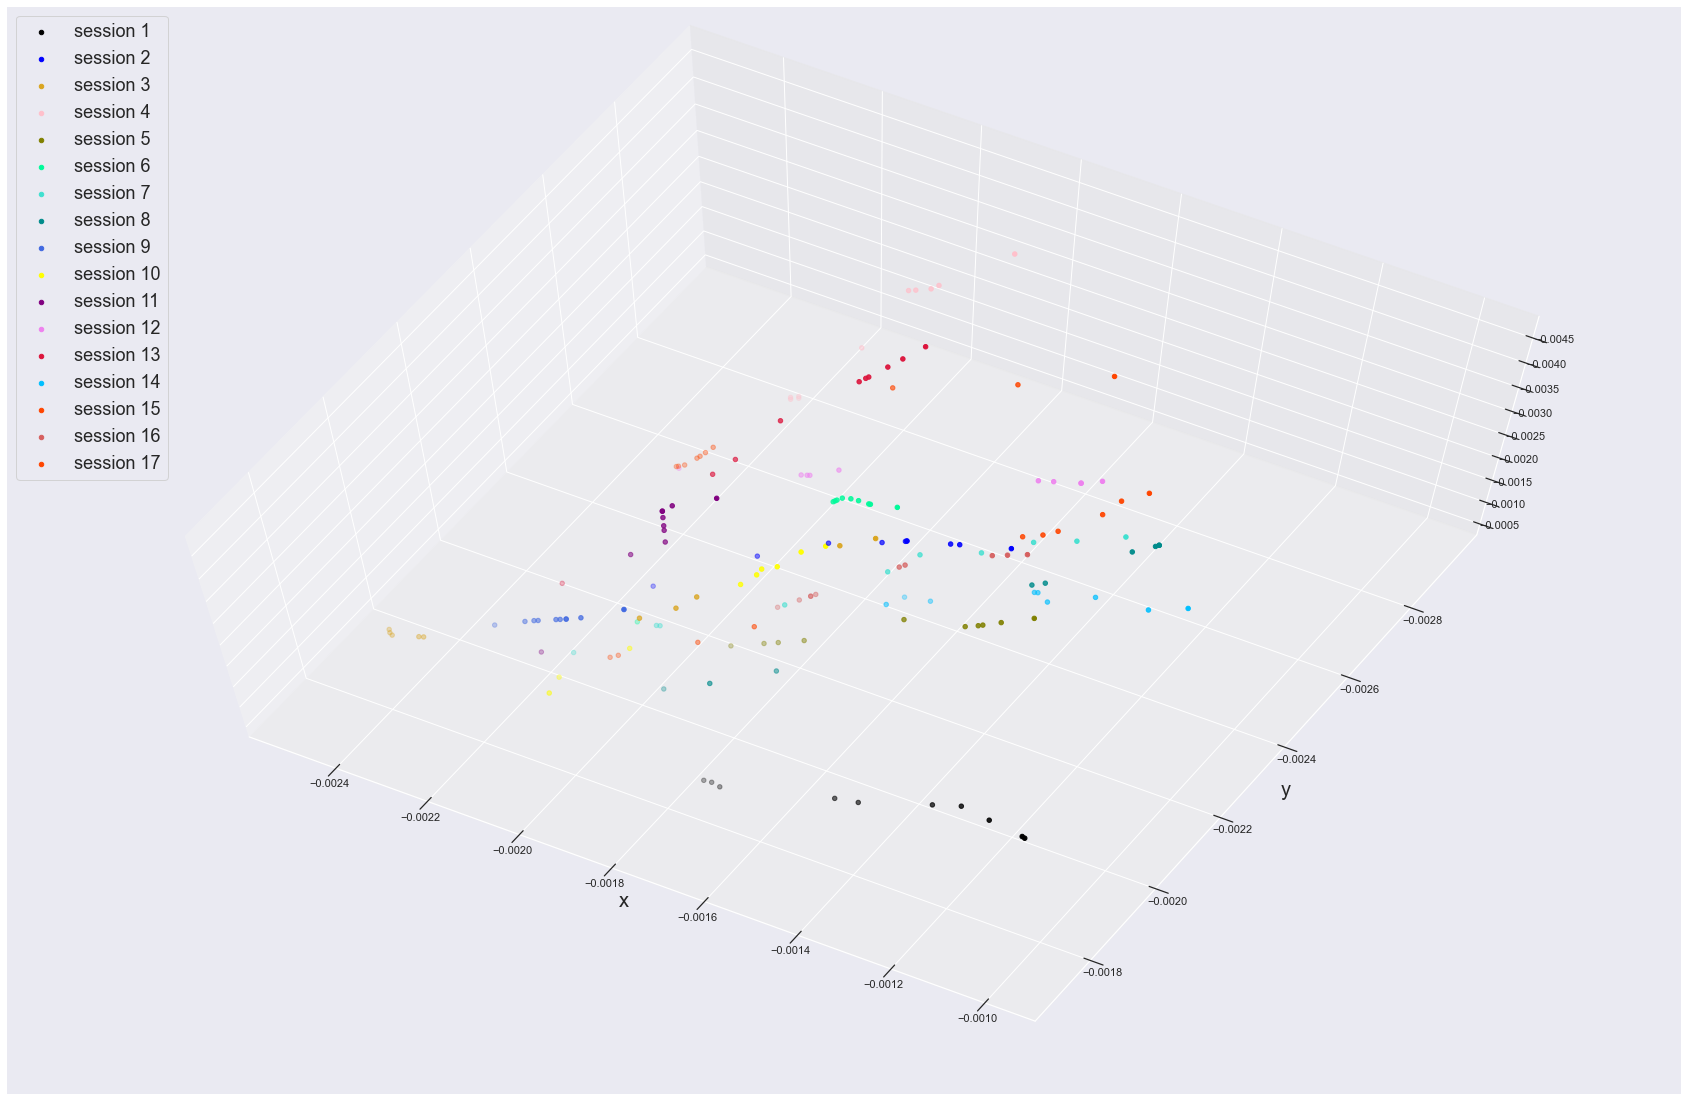

In [1229]:
# 3D cluster locations
%matplotlib inline
colors = ['black','blue','goldenrod','pink','olive','mediumspringgreen','turquoise','darkcyan',
          'royalblue','yellow','purple','violet','crimson','deepskyblue','orangered','r','orangered']
fig=plt.figure(figsize=(30,20))
ax = plt.axes(projection='3d')
for s in range(1,18):
    ax.scatter3D(data['feature_%d'%s][:,1,1,indices['Cluster xyz location']][:,0],
          data['feature_%d'%s][:,1,1,indices['Cluster xyz location']][:,1],
          data['feature_%d'%s][:,1,1,indices['Cluster xyz location']][:,2],color=colors[s-1],label='session %d'%s)
    plt.legend(fontsize=18,loc=2)
plt.xlabel('x',fontsize=20); plt.ylabel('y',fontsize=20)
ax.view_init(-110,240)

In [371]:
accs20 = []
for s in range(1,18):
    train_loader,test_loader=loaders(s)
    fnet = BayesianNetwork()
    fnet.l1 = BayesianLinear(440,10)
    fnet.l2 = BayesianLinear(10,10)
    fnet.l3 = BayesianLinear(10,3)
    fnet.to(DEVICE)
    optimizer = optim.Adam(fnet.parameters())
    for epoch in range(20):
        train(fnet, optimizer, epoch,train_loader)

    accs20.append(test_accuracy(fnet,3,test_loader)[1])

100%|██████████| 10/10 [00:00<00:00, 100.88it/s]

Component accuracies:
[23, 21, 24, 23, 22, 22, 23, 24, 22, 21]
Posterior Mean Test Accuracy: 23/45
Ensemble Test Accuracy: 23/45



 85%|████████▍ | 11/13 [00:00<00:00, 106.04it/s]

Component accuracies:
[63, 63, 62, 65, 64, 66, 65, 65, 67, 65]
Posterior Mean Test Accuracy: 65/90
Ensemble Test Accuracy: 65/90


 64%|██████▍   | 9/14 [00:00<00:00, 82.02it/s]

Component accuracies:
[45, 47, 43, 43, 46, 46, 46, 44, 43, 46]
Posterior Mean Test Accuracy: 45/80
Ensemble Test Accuracy: 45/80


100%|██████████| 4/4 [00:00<00:00, 94.82it/s]

Component accuracies:
[73, 75, 77, 77, 78, 74, 75, 74, 75, 75]
Posterior Mean Test Accuracy: 75/125
Ensemble Test Accuracy: 75/125



  0%|          | 0/5 [00:00<?, ?it/s]

Component accuracies:
[41, 39, 39, 40, 41, 40, 41, 39, 39, 40]
Posterior Mean Test Accuracy: 40/55
Ensemble Test Accuracy: 40/55


 65%|██████▍   | 11/17 [00:00<00:00, 107.90it/s]

Component accuracies:
[51, 54, 53, 51, 52, 53, 54, 54, 51, 52]
Posterior Mean Test Accuracy: 54/75
Ensemble Test Accuracy: 53/75


  0%|          | 0/9 [00:00<?, ?it/s]

Component accuracies:
[84, 85, 86, 86, 87, 87, 86, 83, 88, 84]
Posterior Mean Test Accuracy: 86/115
Ensemble Test Accuracy: 85/115


100%|██████████| 4/4 [00:00<00:00, 98.58it/s]

Component accuracies:
[61, 58, 59, 61, 58, 59, 57, 62, 60, 58]
Posterior Mean Test Accuracy: 58/80
Ensemble Test Accuracy: 59/80



100%|██████████| 9/9 [00:00<00:00, 100.70it/s]

Component accuracies:
[35, 34, 34, 37, 33, 35, 35, 33, 36, 36]
Posterior Mean Test Accuracy: 33/55
Ensemble Test Accuracy: 35/55



 90%|█████████ | 9/10 [00:00<00:00, 83.77it/s]

Component accuracies:
[44, 47, 47, 47, 45, 47, 47, 48, 47, 47]
Posterior Mean Test Accuracy: 48/75
Ensemble Test Accuracy: 48/75


  0%|          | 0/6 [00:00<?, ?it/s]

Component accuracies:
[65, 65, 67, 67, 66, 64, 64, 65, 68, 65]
Posterior Mean Test Accuracy: 65/80
Ensemble Test Accuracy: 65/80


100%|██████████| 9/9 [00:00<00:00, 97.05it/s]

Component accuracies:
[29, 28, 33, 30, 29, 29, 31, 29, 31, 31]
Posterior Mean Test Accuracy: 31/65
Ensemble Test Accuracy: 30/65



  0%|          | 0/8 [00:00<?, ?it/s]

Component accuracies:
[24, 24, 24, 24, 24, 26, 23, 23, 23, 25]
Posterior Mean Test Accuracy: 24/50
Ensemble Test Accuracy: 24/50


  0%|          | 0/5 [00:00<?, ?it/s]

Component accuracies:
[33, 33, 34, 34, 33, 35, 33, 33, 34, 33]
Posterior Mean Test Accuracy: 33/50
Ensemble Test Accuracy: 33/50


  0%|          | 0/6 [00:00<?, ?it/s]

Component accuracies:
[61, 62, 60, 65, 62, 63, 60, 64, 65, 63]
Posterior Mean Test Accuracy: 62/80
Ensemble Test Accuracy: 63/80


  0%|          | 0/7 [00:00<?, ?it/s]

Component accuracies:
[20, 19, 19, 21, 19, 20, 21, 20, 20, 19]
Posterior Mean Test Accuracy: 20/30
Ensemble Test Accuracy: 20/30


100%|██████████| 7/7 [00:00<00:00, 95.47it/s]


Component accuracies:
[27, 32, 32, 34, 33, 33, 32, 35, 31, 31]
Posterior Mean Test Accuracy: 32/60
Ensemble Test Accuracy: 31/60


In [427]:
%%capture
# train for increasing number of epochs on each session separately. repeat ten times
accs=np.zeros((8,10,17))

for ind,epochs in enumerate([20,40,60,80,100,120,140,160]):
    for n in np.arange(10):
        for s in range(1,18):
            train_loader,test_loader=loaders(s)
            fnet = BayesianNetwork()
            fnet.l1 = BayesianLinear(440,10)
            fnet.l2 = BayesianLinear(10,10)
            fnet.l3 = BayesianLinear(10,3)
            fnet.to(DEVICE)
            optimizer = optim.Adam(fnet.parameters())
            for epoch in range(epochs):
                train(fnet, optimizer, epoch, train_loader)

            accs[ind,n,s-1] = test_accuracy(fnet,3,test_loader)[1]

Text(0, 0.5, 'test accuracy (choice)')

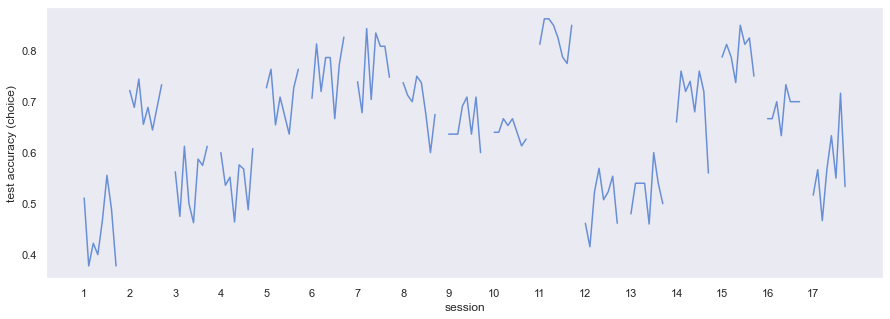

In [403]:
# 60 epochs and up are actually 40 epochs
plt.figure(figsize=(15,5))
for s in range(1,18):
    plt.plot([s,s+0.1,s+0.2,s+0.3,s+0.4,s+0.5,s+0.6,s+0.7],
             [accs20[s-1],accs40[s-1],accs60[s-1],accs80[s-1],
              accs100[s-1],accs120[s-1],accs140[s-1],accs160[s-1]],c='b',alpha=0.8)

plt.xticks(np.arange(1,18))[1]
plt.xlabel('session')
plt.ylabel('test accuracy (choice)')

Text(0, 0.5, 'test accuracy (choice)')

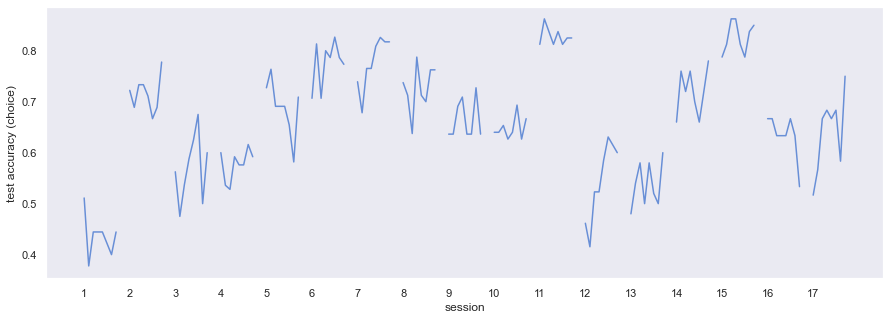

In [415]:
plt.figure(figsize=(15,5))
for s in range(1,18):
    plt.plot([s,s+0.1,s+0.2,s+0.3,s+0.4,s+0.5,s+0.6,s+0.7],
             [accs20[s-1],accs40[s-1],accs60[s-1],accs80[s-1],
              accs100[s-1],accs120[s-1],accs140[s-1],accs160[s-1]],c='b',alpha=0.8)

plt.xticks(np.arange(1,18))[1]
plt.xlabel('session')
plt.ylabel('test accuracy (choice)')

Text(0, 0.5, 'test accuracy (choice)')

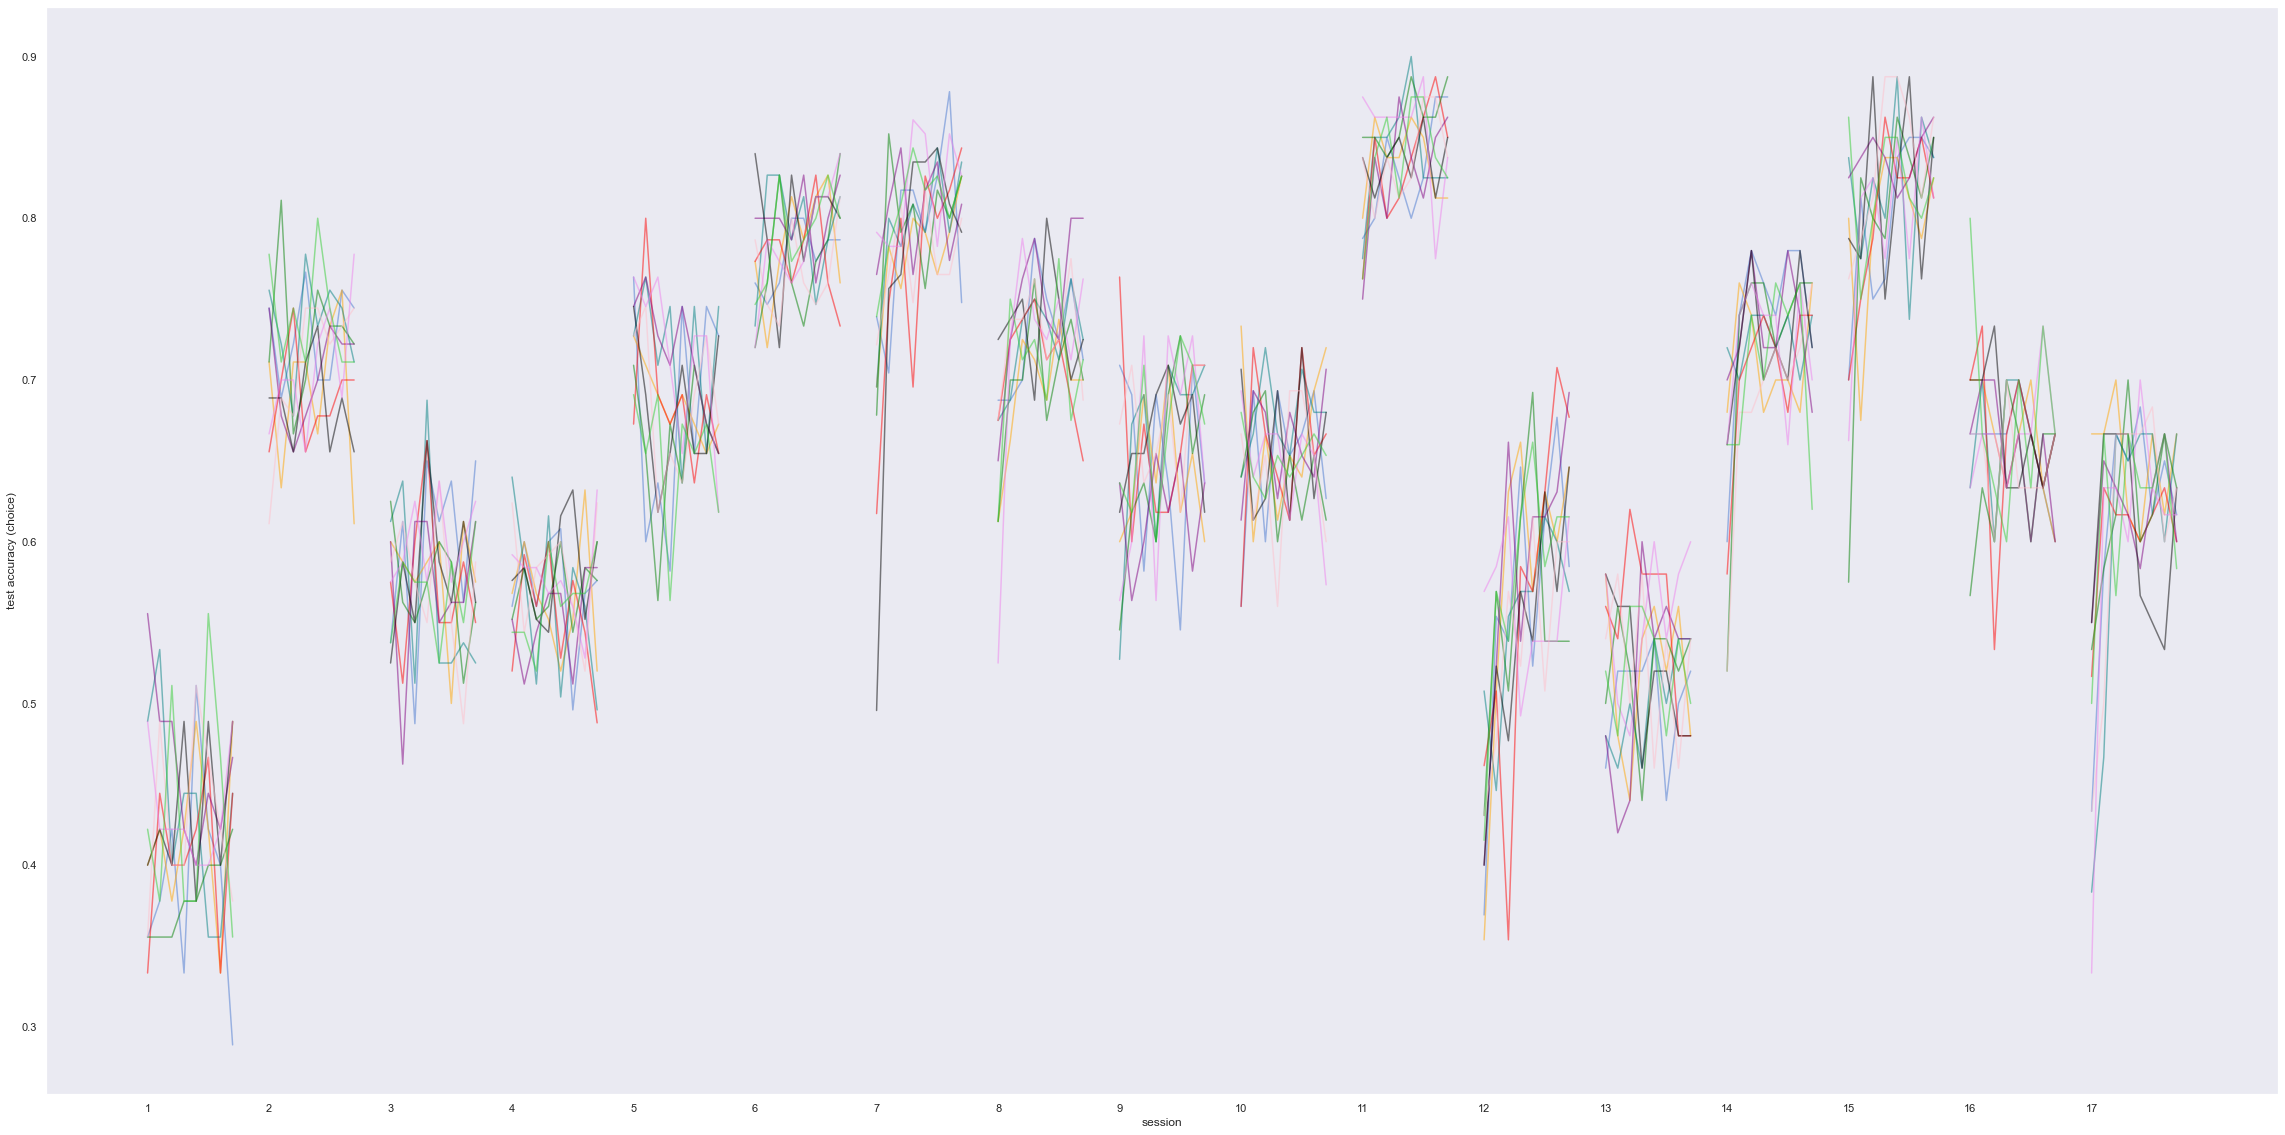

In [438]:
fig=plt.figure(figsize=(40,20))
cols = ['b','orange','teal','red','green','purple','black','pink','violet','limegreen']
for n in np.arange(10):
    for s in range(1,18):
        plt.plot([s,s+0.1,s+0.2,s+0.3,s+0.4,s+0.5,s+0.6,s+0.7],
             [accs[0,n,s-1],accs[1,n,s-1],accs[2,n,s-1],accs[3,n,s-1],
              accs[4,n,s-1],accs[5,n,s-1],accs[6,n,s-1],accs[7,n,s-1]],c=cols[n],alpha=0.5)
        
plt.xticks(np.arange(1,18))[1]
plt.xlabel('session')
plt.ylabel('test accuracy (choice)')

Text(0, 0.5, 'test accuracy (choice)')

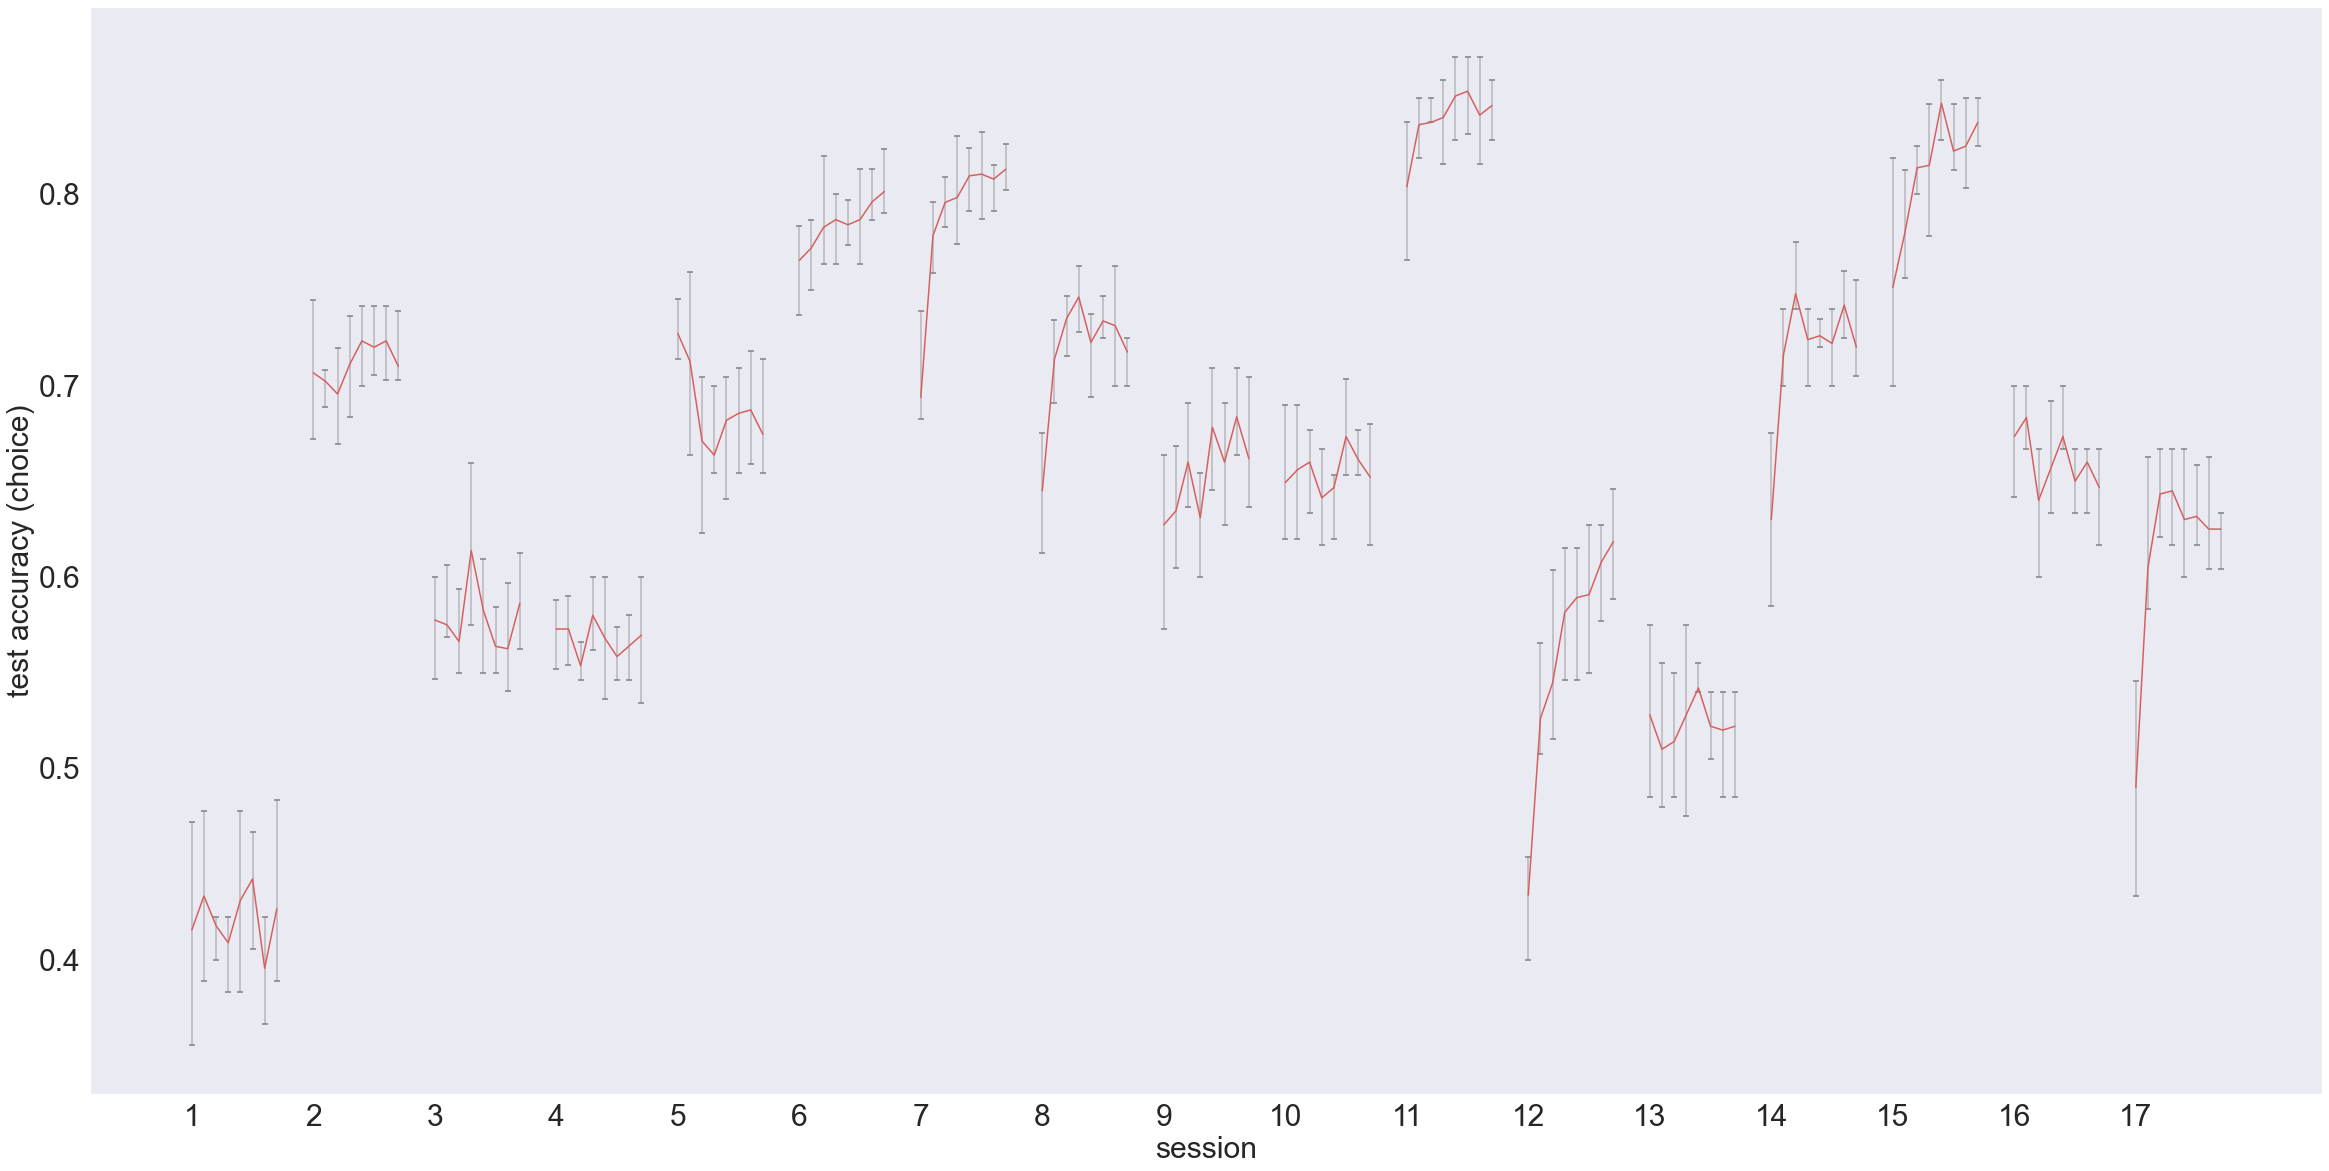

In [505]:
# test performance curves for intra-session models
fig=plt.figure(figsize=(40,20))

for s in range(1,18):
    plt.plot([s,s+0.1,s+0.2,s+0.3,s+0.4,s+0.5,s+0.6,s+0.7],
             [accs[0,:,s-1].mean(),accs[1,:,s-1].mean(),accs[2,:,s-1].mean(),accs[3,:,s-1].mean(),
              accs[4,:,s-1].mean(),accs[5,:,s-1].mean(),accs[6,:,s-1].mean(),accs[7,:,s-1].mean()],c='r')
    
    plt.vlines([s,s+0.1,s+0.2,s+0.3,s+0.4,s+0.5,s+0.6,s+0.7],
              [np.quantile(accs[0,:,s-1],0.25),np.quantile(accs[1,:,s-1],0.25),np.quantile(accs[2,:,s-1],0.25),
              np.quantile(accs[3,:,s-1],0.25),np.quantile(accs[4,:,s-1],0.25),np.quantile(accs[5,:,s-1],0.25),
              np.quantile(accs[6,:,s-1],0.25),np.quantile(accs[7,:,s-1],0.25)],
                [np.quantile(accs[0,:,s-1],0.75),np.quantile(accs[1,:,s-1],0.75),np.quantile(accs[2,:,s-1],0.75),
              np.quantile(accs[3,:,s-1],0.75),np.quantile(accs[4,:,s-1],0.75),np.quantile(accs[5,:,s-1],0.75),
              np.quantile(accs[6,:,s-1],0.75),np.quantile(accs[7,:,s-1],0.75)],color='gray',alpha=0.5)
    plt.scatter([s,s+0.1,s+0.2,s+0.3,s+0.4,s+0.5,s+0.6,s+0.7],
             [np.quantile(accs[0,:,s-1],0.75),np.quantile(accs[1,:,s-1],0.75),np.quantile(accs[2,:,s-1],0.75),
              np.quantile(accs[3,:,s-1],0.75),np.quantile(accs[4,:,s-1],0.75),np.quantile(accs[5,:,s-1],0.75),
              np.quantile(accs[6,:,s-1],0.75),np.quantile(accs[7,:,s-1],0.75)],c='gray',marker='_')
    plt.scatter([s,s+0.1,s+0.2,s+0.3,s+0.4,s+0.5,s+0.6,s+0.7],
             [np.quantile(accs[0,:,s-1],0.25),np.quantile(accs[1,:,s-1],0.25),np.quantile(accs[2,:,s-1],0.25),
              np.quantile(accs[3,:,s-1],0.25),np.quantile(accs[4,:,s-1],0.25),np.quantile(accs[5,:,s-1],0.25),
              np.quantile(accs[6,:,s-1],0.25),np.quantile(accs[7,:,s-1],0.25)],c='gray',marker='_')
        
plt.xticks(np.arange(1,18),size=30)[1]
plt.yticks(fontsize=30)
plt.xlabel('session',size=30)
plt.ylabel('test accuracy (choice)',size=30)

Text(0.5, 1.0, 'no. trials per session')

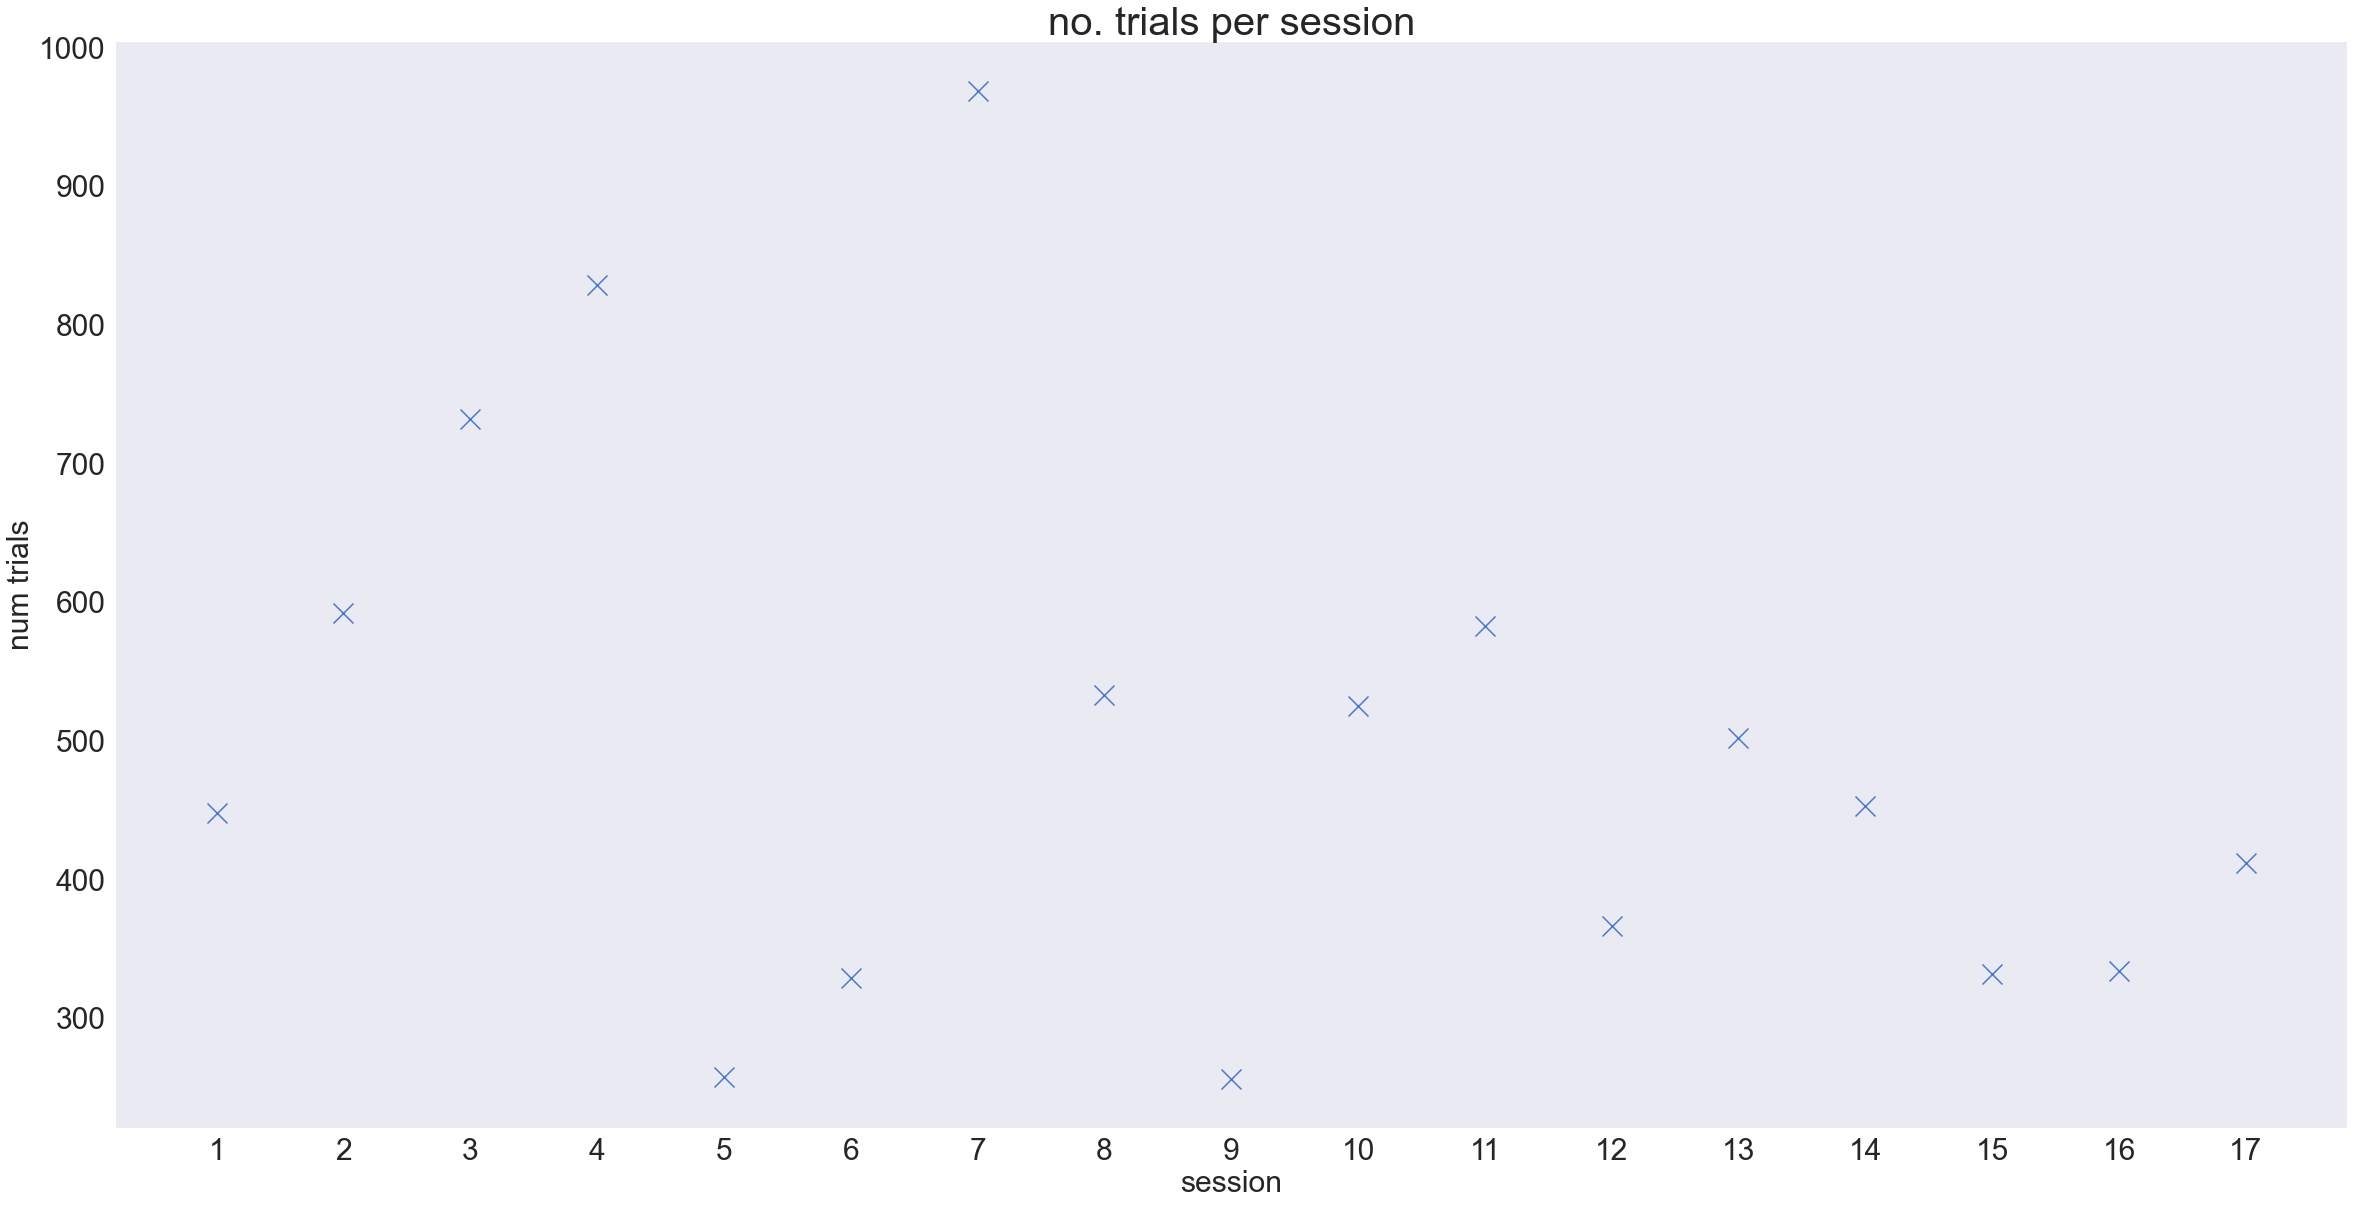

In [1518]:
fig=plt.figure(figsize=(40,20))
plt.scatter(np.arange(1,18),[data['decision_'+str(j)].shape[0] for j in range(1,18)],marker='x',s=400)
plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.xlabel('session',size=30)
plt.ylabel('num trials',size=30);  plt.title('no. trials per session', size=40)

In [354]:
for epoch in range(10):
    train(fnet, optimizer, epoch,train_loader)

print('pretrained %d epochs on data' %10)

100%|██████████| 14/14 [00:00<00:00, 42.50it/s]

pretrained 10 epochs on data


In [1514]:
%%capture
train_accs = []; test_accs = []
train_loader,test_loader=loaders(16)
fnet = BayesianNetwork()
fnet.l1 = BayesianLinear(440,10)
fnet.l2 = BayesianLinear(10,10)
fnet.l3 = BayesianLinear(10,3)
fnet.to(DEVICE)
optimizer = optim.Adam(fnet.parameters())
for epoch in range(80):
    train(fnet, optimizer, epoch,train_loader)
    train_accs.append(train_accuracy(fnet,3,train_loader)[1])
    test_accs.append(test_accuracy(fnet,3,test_loader)[1])

#print('pretrained %d epochs on data' %10)

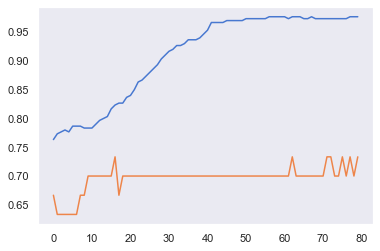

In [1515]:
# Train/test plots, various sessions
# session 16
plt.plot(train_accs)
plt.plot(test_accs)

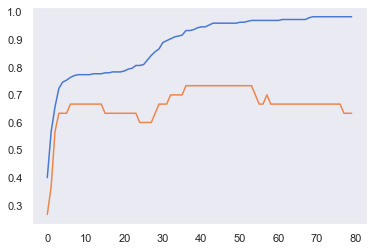

In [1513]:
# session 16
plt.plot(train_accs)
plt.plot(test_accs)

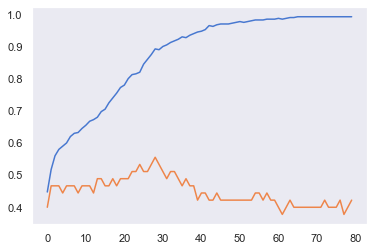

In [1511]:
# session 1
plt.plot(train_accs)
plt.plot(test_accs)

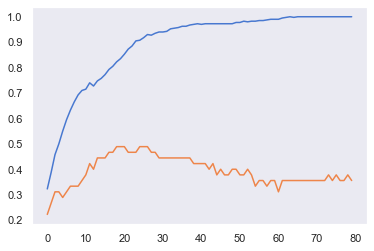

In [1509]:
# session 1
plt.plot(train_accs)
plt.plot(test_accs)

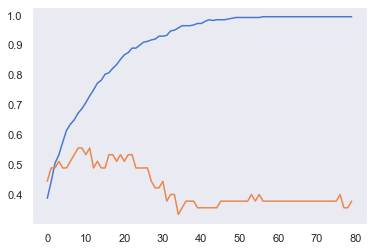

In [1507]:
# session 1
plt.plot(train_accs)
plt.plot(test_accs)

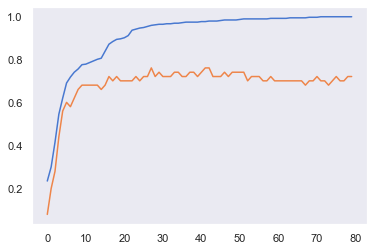

In [1505]:
# session 14
plt.plot(train_accs)
plt.plot(test_accs)

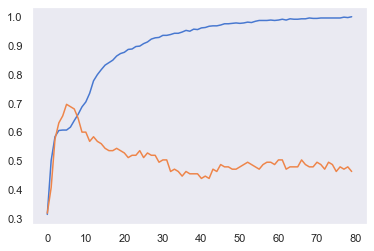

In [1499]:
#session 4
plt.plot(train_accs)
plt.plot(test_accs)

In [509]:
#train_loader,test_loader=loaders(1)
train_accuracy(fnet,3,train_loader), test_accuracy(fnet,3,test_loader)

Component accuracies:
[518, 524, 528, 528, 530, 527, 526, 526, 521, 530]
Posterior Mean Train Accuracy: 523/850
Ensemble Train Accuracy: 525/850
Component accuracies:
[64, 61, 63, 64, 69, 63, 63, 60, 66, 61]
Posterior Mean Test Accuracy: 62/115
Ensemble Test Accuracy: 62/115


((0.6152941176470588, 0.6176470588235294),
 (0.5391304347826087, 0.5391304347826087))

In [528]:
num_ftrs = fnet.l3.in_features
fnet.l3 = BayesianLinear(num_ftrs, 3)

#fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
#fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
#fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
#fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)

fnet = fnet.to(DEVICE)

train_loader,test_loader=loaders(4)

optimizer = optim.Adam(fnet.parameters())
for _ in range(9):
    train(fnet, optimizer, 1, train_loader)
    #fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
    #fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
    #fnet.l3.weight_prior = Gaussian(fnet.l3.weight_mu, fnet.l3.weight_rho)
    #fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
    #fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)
    #fnet.l3.bias_prior = Gaussian(fnet.l3.bias_mu, fnet.l3.bias_rho)

100%|██████████| 14/14 [00:00<00:00, 97.67it/s]


In [531]:
# without transfer
for _ in range(9):
    train(fnet, optimizer, 1, train_loader)

100%|██████████| 14/14 [00:00<00:00, 100.07it/s]


In [529]:
# WITH TRANSFER
train_loader,test_loader=loaders(4)
for _ in range(20):
    for __ in range(4):
        train(fnet, optimizer, 1, train_loader)
        #fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
        #fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
        #fnet.l3.weight_prior = Gaussian(fnet.l3.weight_mu, fnet.l3.weight_rho)
        #fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
        #fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)
        #fnet.l3.bias_prior = Gaussian(fnet.l3.bias_mu, fnet.l3.bias_rho)
    train_accuracy(fnet,3,train_loader), test_accuracy(fnet,3,test_loader)

 71%|███████▏  | 10/14 [00:00<00:00, 99.77it/s]

Component accuracies:
[527, 527, 529, 521, 526, 510, 528, 530, 533, 534]
Posterior Mean Train Accuracy: 531/700
Ensemble Train Accuracy: 530/700
Component accuracies:
[80, 83, 82, 79, 80, 80, 80, 80, 82, 83]
Posterior Mean Test Accuracy: 82/125
Ensemble Test Accuracy: 80/125


 79%|███████▊  | 11/14 [00:00<00:00, 106.80it/s]

Component accuracies:
[564, 565, 566, 569, 556, 567, 566, 569, 558, 565]
Posterior Mean Train Accuracy: 573/700
Ensemble Train Accuracy: 567/700
Component accuracies:
[77, 77, 79, 79, 78, 78, 79, 81, 79, 80]
Posterior Mean Test Accuracy: 81/125
Ensemble Test Accuracy: 79/125


 79%|███████▊  | 11/14 [00:00<00:00, 104.54it/s]

Component accuracies:
[582, 585, 580, 591, 585, 583, 586, 591, 591, 591]
Posterior Mean Train Accuracy: 588/700
Ensemble Train Accuracy: 591/700
Component accuracies:
[75, 78, 76, 79, 77, 78, 76, 77, 76, 75]
Posterior Mean Test Accuracy: 76/125
Ensemble Test Accuracy: 76/125


 79%|███████▊  | 11/14 [00:00<00:00, 106.36it/s]

Component accuracies:
[609, 605, 601, 608, 604, 598, 601, 604, 603, 602]
Posterior Mean Train Accuracy: 608/700
Ensemble Train Accuracy: 608/700
Component accuracies:
[72, 75, 73, 73, 70, 71, 72, 73, 72, 77]
Posterior Mean Test Accuracy: 75/125
Ensemble Test Accuracy: 73/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[617, 617, 614, 614, 615, 615, 611, 616, 605, 611]
Posterior Mean Train Accuracy: 621/700
Ensemble Train Accuracy: 619/700
Component accuracies:
[70, 75, 73, 74, 72, 74, 73, 73, 73, 74]
Posterior Mean Test Accuracy: 73/125
Ensemble Test Accuracy: 75/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[621, 625, 616, 617, 624, 617, 621, 619, 618, 615]
Posterior Mean Train Accuracy: 628/700
Ensemble Train Accuracy: 627/700
Component accuracies:
[73, 76, 73, 75, 71, 71, 70, 72, 72, 73]
Posterior Mean Test Accuracy: 75/125
Ensemble Test Accuracy: 74/125


 79%|███████▊  | 11/14 [00:00<00:00, 101.34it/s]

Component accuracies:
[624, 622, 623, 626, 622, 622, 628, 626, 625, 627]
Posterior Mean Train Accuracy: 630/700
Ensemble Train Accuracy: 630/700
Component accuracies:
[70, 66, 69, 68, 74, 72, 72, 74, 65, 70]
Posterior Mean Test Accuracy: 67/125
Ensemble Test Accuracy: 69/125


 79%|███████▊  | 11/14 [00:00<00:00, 106.14it/s]

Component accuracies:
[632, 639, 633, 633, 630, 626, 629, 631, 626, 631]
Posterior Mean Train Accuracy: 634/700
Ensemble Train Accuracy: 634/700
Component accuracies:
[69, 68, 69, 68, 72, 72, 66, 67, 71, 73]
Posterior Mean Test Accuracy: 68/125
Ensemble Test Accuracy: 70/125


 79%|███████▊  | 11/14 [00:00<00:00, 106.44it/s]

Component accuracies:
[636, 637, 630, 633, 634, 633, 634, 637, 630, 634]
Posterior Mean Train Accuracy: 642/700
Ensemble Train Accuracy: 637/700
Component accuracies:
[68, 67, 65, 66, 64, 66, 65, 72, 71, 69]
Posterior Mean Test Accuracy: 64/125
Ensemble Test Accuracy: 66/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[644, 646, 638, 646, 638, 641, 643, 638, 642, 642]
Posterior Mean Train Accuracy: 647/700
Ensemble Train Accuracy: 647/700
Component accuracies:
[69, 67, 66, 66, 71, 69, 68, 66, 69, 62]
Posterior Mean Test Accuracy: 66/125
Ensemble Test Accuracy: 65/125


 79%|███████▊  | 11/14 [00:00<00:00, 106.58it/s]

Component accuracies:
[650, 642, 649, 646, 652, 644, 651, 647, 641, 645]
Posterior Mean Train Accuracy: 654/700
Ensemble Train Accuracy: 653/700
Component accuracies:
[69, 67, 65, 71, 69, 68, 70, 68, 63, 70]
Posterior Mean Test Accuracy: 69/125
Ensemble Test Accuracy: 66/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[653, 655, 651, 652, 652, 656, 653, 656, 647, 652]
Posterior Mean Train Accuracy: 661/700
Ensemble Train Accuracy: 656/700
Component accuracies:
[66, 68, 66, 68, 69, 71, 69, 74, 64, 70]
Posterior Mean Test Accuracy: 67/125
Ensemble Test Accuracy: 69/125


 79%|███████▊  | 11/14 [00:00<00:00, 105.97it/s]

Component accuracies:
[659, 657, 665, 656, 654, 658, 660, 656, 654, 654]
Posterior Mean Train Accuracy: 667/700
Ensemble Train Accuracy: 665/700
Component accuracies:
[67, 66, 69, 71, 68, 63, 71, 71, 65, 68]
Posterior Mean Test Accuracy: 69/125
Ensemble Test Accuracy: 69/125


 71%|███████▏  | 10/14 [00:00<00:00, 90.18it/s]

Component accuracies:
[657, 658, 656, 662, 662, 661, 662, 660, 653, 665]
Posterior Mean Train Accuracy: 669/700
Ensemble Train Accuracy: 667/700
Component accuracies:
[70, 69, 67, 72, 64, 67, 66, 65, 72, 64]
Posterior Mean Test Accuracy: 67/125
Ensemble Test Accuracy: 69/125


 79%|███████▊  | 11/14 [00:00<00:00, 107.54it/s]

Component accuracies:
[664, 663, 667, 659, 666, 660, 663, 660, 667, 662]
Posterior Mean Train Accuracy: 675/700
Ensemble Train Accuracy: 670/700
Component accuracies:
[70, 65, 72, 69, 64, 64, 71, 64, 71, 71]
Posterior Mean Test Accuracy: 68/125
Ensemble Test Accuracy: 70/125


 79%|███████▊  | 11/14 [00:00<00:00, 100.38it/s]

Component accuracies:
[664, 666, 665, 666, 666, 668, 664, 666, 666, 668]
Posterior Mean Train Accuracy: 676/700
Ensemble Train Accuracy: 674/700
Component accuracies:
[70, 66, 65, 70, 64, 72, 65, 70, 69, 66]
Posterior Mean Test Accuracy: 67/125
Ensemble Test Accuracy: 68/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[671, 670, 666, 670, 669, 664, 668, 670, 673, 673]
Posterior Mean Train Accuracy: 678/700
Ensemble Train Accuracy: 676/700
Component accuracies:
[68, 67, 60, 63, 69, 63, 64, 73, 70, 66]
Posterior Mean Test Accuracy: 66/125
Ensemble Test Accuracy: 67/125


 79%|███████▊  | 11/14 [00:00<00:00, 106.06it/s]

Component accuracies:
[669, 667, 671, 664, 671, 667, 664, 667, 662, 662]
Posterior Mean Train Accuracy: 679/700
Ensemble Train Accuracy: 677/700
Component accuracies:
[64, 65, 62, 69, 65, 61, 67, 62, 68, 70]
Posterior Mean Test Accuracy: 63/125
Ensemble Test Accuracy: 67/125


 79%|███████▊  | 11/14 [00:00<00:00, 106.88it/s]

Component accuracies:
[668, 670, 673, 669, 669, 673, 669, 666, 667, 669]
Posterior Mean Train Accuracy: 681/700
Ensemble Train Accuracy: 676/700
Component accuracies:
[71, 61, 71, 74, 68, 71, 65, 72, 67, 75]
Posterior Mean Test Accuracy: 66/125
Ensemble Test Accuracy: 70/125


100%|██████████| 14/14 [00:00<00:00, 97.32it/s]


Component accuracies:
[674, 677, 665, 671, 678, 670, 665, 670, 677, 670]
Posterior Mean Train Accuracy: 682/700
Ensemble Train Accuracy: 680/700
Component accuracies:
[65, 64, 62, 64, 67, 69, 65, 69, 68, 72]
Posterior Mean Test Accuracy: 67/125
Ensemble Test Accuracy: 66/125


In [532]:
# WITHOUT
train_loader,test_loader=loaders(4)
for _ in range(20):
    for __ in range(4):
        train(fnet, optimizer, 1, train_loader)
        #fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
        #fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
        #fnet.l3.weight_prior = Gaussian(fnet.l3.weight_mu, fnet.l3.weight_rho)
        #fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
        #fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)
        #fnet.l3.bias_prior = Gaussian(fnet.l3.bias_mu, fnet.l3.bias_rho)
    train_accuracy(fnet,3,train_loader), test_accuracy(fnet,3,test_loader)

 79%|███████▊  | 11/14 [00:00<00:00, 105.87it/s]

Component accuracies:
[672, 672, 670, 674, 675, 671, 674, 674, 674, 671]
Posterior Mean Train Accuracy: 674/700
Ensemble Train Accuracy: 672/700
Component accuracies:
[68, 70, 67, 69, 70, 69, 66, 70, 63, 68]
Posterior Mean Test Accuracy: 68/125
Ensemble Test Accuracy: 69/125


 64%|██████▍   | 9/14 [00:00<00:00, 81.73it/s]

Component accuracies:
[678, 680, 679, 677, 677, 678, 676, 678, 676, 679]
Posterior Mean Train Accuracy: 681/700
Ensemble Train Accuracy: 679/700
Component accuracies:
[69, 68, 69, 68, 68, 66, 69, 70, 69, 69]
Posterior Mean Test Accuracy: 69/125
Ensemble Test Accuracy: 69/125


 79%|███████▊  | 11/14 [00:00<00:00, 107.75it/s]

Component accuracies:
[679, 679, 680, 681, 680, 680, 677, 679, 680, 683]
Posterior Mean Train Accuracy: 681/700
Ensemble Train Accuracy: 681/700
Component accuracies:
[65, 67, 64, 67, 69, 69, 67, 65, 63, 63]
Posterior Mean Test Accuracy: 70/125
Ensemble Test Accuracy: 67/125


 79%|███████▊  | 11/14 [00:00<00:00, 100.83it/s]

Component accuracies:
[687, 680, 684, 685, 686, 684, 684, 682, 684, 687]
Posterior Mean Train Accuracy: 686/700
Ensemble Train Accuracy: 684/700
Component accuracies:
[67, 69, 63, 63, 70, 66, 67, 67, 68, 67]
Posterior Mean Test Accuracy: 65/125
Ensemble Test Accuracy: 65/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[688, 690, 685, 689, 687, 690, 687, 689, 690, 690]
Posterior Mean Train Accuracy: 691/700
Ensemble Train Accuracy: 690/700
Component accuracies:
[60, 66, 59, 64, 65, 68, 68, 67, 69, 69]
Posterior Mean Test Accuracy: 64/125
Ensemble Test Accuracy: 66/125


 79%|███████▊  | 11/14 [00:00<00:00, 105.55it/s]

Component accuracies:
[690, 689, 691, 690, 691, 693, 689, 691, 693, 692]
Posterior Mean Train Accuracy: 692/700
Ensemble Train Accuracy: 692/700
Component accuracies:
[69, 62, 67, 70, 64, 64, 67, 64, 60, 64]
Posterior Mean Test Accuracy: 65/125
Ensemble Test Accuracy: 66/125


 64%|██████▍   | 9/14 [00:00<00:00, 84.90it/s]

Component accuracies:
[689, 691, 692, 693, 691, 692, 693, 691, 691, 690]
Posterior Mean Train Accuracy: 693/700
Ensemble Train Accuracy: 693/700
Component accuracies:
[65, 66, 70, 70, 69, 67, 63, 70, 69, 66]
Posterior Mean Test Accuracy: 66/125
Ensemble Test Accuracy: 67/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[690, 693, 689, 691, 690, 693, 691, 693, 692, 692]
Posterior Mean Train Accuracy: 694/700
Ensemble Train Accuracy: 693/700
Component accuracies:
[71, 66, 71, 67, 67, 68, 67, 66, 66, 66]
Posterior Mean Test Accuracy: 69/125
Ensemble Test Accuracy: 66/125


 71%|███████▏  | 10/14 [00:00<00:00, 97.28it/s]

Component accuracies:
[692, 694, 691, 693, 694, 694, 694, 691, 695, 694]
Posterior Mean Train Accuracy: 695/700
Ensemble Train Accuracy: 695/700
Component accuracies:
[70, 67, 72, 66, 70, 68, 67, 67, 66, 67]
Posterior Mean Test Accuracy: 68/125
Ensemble Test Accuracy: 70/125


 71%|███████▏  | 10/14 [00:00<00:00, 94.57it/s]

Component accuracies:
[694, 692, 694, 694, 695, 694, 695, 693, 693, 694]
Posterior Mean Train Accuracy: 696/700
Ensemble Train Accuracy: 695/700
Component accuracies:
[64, 70, 70, 71, 69, 67, 69, 68, 73, 67]
Posterior Mean Test Accuracy: 69/125
Ensemble Test Accuracy: 68/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[694, 693, 691, 690, 694, 693, 695, 692, 692, 693]
Posterior Mean Train Accuracy: 696/700
Ensemble Train Accuracy: 695/700
Component accuracies:
[65, 64, 67, 69, 69, 73, 65, 71, 72, 69]
Posterior Mean Test Accuracy: 69/125
Ensemble Test Accuracy: 64/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[693, 693, 696, 692, 694, 690, 694, 694, 694, 695]
Posterior Mean Train Accuracy: 696/700
Ensemble Train Accuracy: 695/700
Component accuracies:
[66, 66, 70, 67, 66, 66, 65, 70, 68, 69]
Posterior Mean Test Accuracy: 67/125
Ensemble Test Accuracy: 67/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[696, 697, 694, 694, 694, 694, 691, 697, 696, 694]
Posterior Mean Train Accuracy: 697/700
Ensemble Train Accuracy: 697/700
Component accuracies:
[72, 67, 73, 65, 67, 70, 69, 69, 66, 71]
Posterior Mean Test Accuracy: 68/125
Ensemble Test Accuracy: 68/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[695, 698, 697, 695, 696, 696, 693, 696, 693, 696]
Posterior Mean Train Accuracy: 697/700
Ensemble Train Accuracy: 698/700
Component accuracies:
[67, 65, 68, 67, 69, 71, 71, 67, 64, 68]
Posterior Mean Test Accuracy: 70/125
Ensemble Test Accuracy: 69/125


 79%|███████▊  | 11/14 [00:00<00:00, 104.89it/s]

Component accuracies:
[699, 693, 692, 697, 699, 693, 696, 697, 693, 696]
Posterior Mean Train Accuracy: 698/700
Ensemble Train Accuracy: 698/700
Component accuracies:
[69, 66, 72, 71, 66, 67, 72, 73, 66, 66]
Posterior Mean Test Accuracy: 70/125
Ensemble Test Accuracy: 70/125


  0%|          | 0/14 [00:00<?, ?it/s]

Component accuracies:
[692, 695, 695, 693, 690, 694, 694, 696, 695, 693]
Posterior Mean Train Accuracy: 699/700
Ensemble Train Accuracy: 697/700
Component accuracies:
[72, 70, 70, 64, 68, 71, 69, 67, 75, 72]
Posterior Mean Test Accuracy: 73/125
Ensemble Test Accuracy: 74/125


 71%|███████▏  | 10/14 [00:00<00:00, 99.70it/s]

Component accuracies:
[693, 693, 696, 696, 698, 692, 692, 693, 692, 698]
Posterior Mean Train Accuracy: 699/700
Ensemble Train Accuracy: 699/700
Component accuracies:
[71, 71, 70, 70, 71, 71, 68, 66, 70, 69]
Posterior Mean Test Accuracy: 73/125
Ensemble Test Accuracy: 73/125


 79%|███████▊  | 11/14 [00:00<00:00, 108.56it/s]

Component accuracies:
[696, 695, 693, 689, 693, 697, 693, 694, 694, 697]
Posterior Mean Train Accuracy: 699/700
Ensemble Train Accuracy: 699/700
Component accuracies:
[74, 74, 73, 71, 74, 70, 69, 68, 74, 71]
Posterior Mean Test Accuracy: 74/125
Ensemble Test Accuracy: 74/125


 79%|███████▊  | 11/14 [00:00<00:00, 107.45it/s]

Component accuracies:
[692, 694, 692, 692, 691, 695, 695, 693, 692, 694]
Posterior Mean Train Accuracy: 699/700
Ensemble Train Accuracy: 699/700
Component accuracies:
[69, 69, 70, 69, 73, 70, 71, 72, 69, 70]
Posterior Mean Test Accuracy: 68/125
Ensemble Test Accuracy: 71/125


100%|██████████| 14/14 [00:00<00:00, 102.32it/s]


Component accuracies:
[696, 693, 689, 693, 691, 689, 695, 693, 693, 689]
Posterior Mean Train Accuracy: 699/700
Ensemble Train Accuracy: 699/700
Component accuracies:
[71, 66, 70, 66, 67, 71, 70, 72, 70, 72]
Posterior Mean Test Accuracy: 72/125
Ensemble Test Accuracy: 72/125


In [541]:
%%capture
# training regime: 20 epochs (pre)training, 9 epochs (post)training (warm up transferred models),
# 80 epochs training (tracking test accuracy every 4 epochs)


accs_with = np.zeros((17,17,20))
accs_without = np.zeros((17,20))

#With transfer
for s1 in np.arange(1,18):
    for s2 in np.arange(1,18):
        # (pre)train on source s1
        train_loader,test_loader=loaders(s1)
        fnet = BayesianNetwork()
        fnet.l1 = BayesianLinear(440,10)
        fnet.l2 = BayesianLinear(10,10)
        fnet.l3 = BayesianLinear(10,3)
        fnet.to(DEVICE)
        optimizer = optim.Adam(fnet.parameters())
        for epoch in range(20):
            train(fnet, optimizer, epoch, train_loader)
            
        # transfer to s2
        num_ftrs = fnet.l3.in_features
        fnet.l3 = BayesianLinear(num_ftrs, 3)
        fnet = fnet.to(DEVICE)
        train_loader,test_loader=loaders(s2)
        optimizer = optim.Adam(fnet.parameters())
        
        # warm up transferred model
        for _ in range(9):
            train(fnet, optimizer, 1, train_loader)

        # track every four epochs 20 repeats
        for t in range(20):
            for __ in range(4):
                train(fnet, optimizer, 1, train_loader)
            accs_with[s1-1,s2-1,t]=test_accuracy(fnet,3,test_loader)[1]
        

#Without

for s in np.arange(1,18):
    train_loader,test_loader=loaders(s)
    fnet = BayesianNetwork()
    fnet.l1 = BayesianLinear(440,10)
    fnet.l2 = BayesianLinear(10,10)
    fnet.l3 = BayesianLinear(10,3)
    fnet.to(DEVICE)
    optimizer = optim.Adam(fnet.parameters())
    for epoch in range(20):
        train(fnet, optimizer, epoch, train_loader)
        
    
    # 9 epochs training to compare to warm transferred model
    for _ in range(9):
        train(fnet, optimizer, 1, train_loader)
        
    # track every four epochs 20 repeats
    for t in range(20):
        for __ in range(4):
            train(fnet, optimizer, 1, train_loader)
        accs_without[s-1,t]=test_accuracy(fnet,3,test_loader)[1]

    


In [1489]:
%%capture
# training regime: 20 epochs (pre)training, 9 epochs (post)training (warm up transferred models),
# 80 epochs training (tracking test accuracy every 4 epochs)

# TREAT no-choice as one-hot


accs_with2 = np.zeros((17,17,20))
accs_without2 = np.zeros((17,20))

#With transfer
for s1 in np.arange(1,18):
    for s2 in np.arange(1,18):
        # (pre)train on source s1
        train_loader,test_loader=loaders(s1)
        fnet = BayesianNetwork()
        fnet.l1 = BayesianLinear(440,10)
        fnet.l2 = BayesianLinear(10,10)
        fnet.l3 = BayesianLinear(10,3)
        fnet.to(DEVICE)
        optimizer = optim.Adam(fnet.parameters())
        for epoch in range(20):
            train(fnet, optimizer, epoch, train_loader)
            
        # transfer to s2
        num_ftrs = fnet.l3.in_features
        fnet.l3 = BayesianLinear(num_ftrs, 3)
        fnet = fnet.to(DEVICE)
        train_loader,test_loader=loaders(s2)
        optimizer = optim.Adam(fnet.parameters())
        
        # warm up transferred model
        for _ in range(9):
            train(fnet, optimizer, 1, train_loader)

        # track every four epochs 20 repeats
        for t in range(20):
            for __ in range(4):
                train(fnet, optimizer, 1, train_loader)
            accs_with2[s1-1,s2-1,t]=test_accuracy(fnet,3,test_loader)[1]
        

#Without

for s in np.arange(1,18):
    train_loader,test_loader=loaders(s)
    fnet = BayesianNetwork()
    fnet.l1 = BayesianLinear(440,10)
    fnet.l2 = BayesianLinear(10,10)
    fnet.l3 = BayesianLinear(10,3)
    fnet.to(DEVICE)
    optimizer = optim.Adam(fnet.parameters())
    for epoch in range(20):
        train(fnet, optimizer, epoch, train_loader)
        
    
    # 9 epochs training to compare to warm transferred model
    for _ in range(9):
        train(fnet, optimizer, 1, train_loader)
        
    # track every four epochs 20 repeats
    for t in range(20):
        for __ in range(4):
            train(fnet, optimizer, 1, train_loader)
        accs_without2[s-1,t]=test_accuracy(fnet,3,test_loader)[1]

    



In [1431]:
%%capture
# training regime: 20 epochs (pre)training, 9 epochs (post)training (warm up transferred models),
# 80 epochs training (tracking test accuracy every 4 epochs)

# TREAT no-choice as one-hot
# No Retrain; All downstream data loaded for testing


accs_with_noretrain3 = np.zeros((17,17,20))
accs_without_noretrain3 = np.zeros((17,20))

#With transfer
for t in range(20):
    for s1 in np.arange(1,18):
        for s2 in np.arange(1,18):
            # (pre)train on source s1
            train_loader,test_loader=loaders(s1)
            fnet = BayesianNetwork()
            fnet.l1 = BayesianLinear(440,10)
            fnet.l2 = BayesianLinear(10,10)
            fnet.l3 = BayesianLinear(10,3)
            fnet.to(DEVICE)
            optimizer = optim.Adam(fnet.parameters())
            for epoch in range(20):
                train(fnet, optimizer, epoch, train_loader)

            all_loader=load_all(s2)

            accs_with_noretrain3[s1-1,s2-1,t]=test_accuracy(fnet,3,all_loader)[1]
        

#Without

for t in range(20):
    for s in np.arange(1,18):
        train_loader,test_loader=loaders(s)
        fnet = BayesianNetwork()
        fnet.l1 = BayesianLinear(440,10)
        fnet.l2 = BayesianLinear(10,10)
        fnet.l3 = BayesianLinear(10,3)
        fnet.to(DEVICE)
        optimizer = optim.Adam(fnet.parameters())
        for epoch in range(20):
            train(fnet, optimizer, epoch, train_loader)

        accs_without_noretrain3[s-1,t]=test_accuracy(fnet,3,test_loader)[1]


In [1372]:
%%capture
# Baseline: Logistic Regression

# TREAT no-choice as one-hot
# No Retrain; All downstream data loaded for testing

from sklearn.linear_model import LogisticRegression


accs_with_noretrain_L = np.zeros((17,17,20))
accs_without_noretrain_L = np.zeros((17,20))

#With transfer

for s1 in np.arange(1,18):
    for s2 in np.arange(1,18):
        # (pre)train LR on source s1
        decision = data['decision_'+str(s1)]
        firing_rate = data['output_'+str(s1)]

        lr = LogisticRegression(C=1e5)
        lr.fit(firing_rate,decision.argmax(1))

        decision = data['decision_'+str(s2)]
        firing_rate = data['output_'+str(s2)]

        preds = lr.predict(firing_rate)

        accs_with_noretrain_L[s1-1,s2-1,t]=np.mean(preds==decision.argmax(1))
        

#Without


for s in np.arange(1,18):

    decision = data['decision_'+str(s)]
    firing_rate = data['output_'+str(s)]

    num_trials = decision.shape[0]

    train_idxs = np.arange(0,(int(num_trials*0.9)//50)*50)
    test_idxs = np.arange((int(num_trials*0.9)//50)*50,5*(num_trials//5))

    lr = LogisticRegression(C=1e5)
    lr.fit(firing_rate[train_idxs],decision.argmax(1)[train_idxs])

    preds = lr.predict(firing_rate[test_idxs])

    accs_without_noretrain_L[s-1,t]=np.mean(preds==decision.argmax(1)[test_idxs])



In [1486]:
%%capture
# Baseline: Logistic Regression

# TREAT no-choice as one-hot
# Train on downstream (90%)

from sklearn.linear_model import LogisticRegression

accs_without_L = np.zeros(17)

for s in np.arange(1,18):
    # train LR on 90% s2 trials
    decision = data['decision_'+str(s)]
    firing_rate = data['output_'+str(s)]

    num_trials = decision.shape[0]

    train_idxs = np.arange(0,(int(num_trials*0.9)//50)*50)
    test_idxs = np.arange((int(num_trials*0.9)//50)*50,5*(num_trials//5))

    lr = LogisticRegression(C=1e5)
    lr.fit(firing_rate[train_idxs],decision.argmax(1)[train_idxs])

    preds = lr.predict(firing_rate[test_idxs])

    accs_without_L[s-1]=np.mean(preds==decision.argmax(1)[test_idxs])



In [1478]:
data['decision_1'].argmax(1)

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1,
       0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0,
       2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 0, 2, 0, 2,
       2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0,
       0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2,
       2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0,

In [598]:
%%capture
# training regime: 20 epochs (pre)training (5, v5), 9 epochs (post)training (warm up transferred models, transfer posterior),
# 80 epochs training (tracking test accuracy & transferring posterior every 4 epochs (every epoch, v4))


accs_with__posteriortransfer5 = np.zeros((17,17,20))
accs_without__posteriortransfer5 = np.zeros((17,20))

#With transfer
for s1 in np.arange(1,18):
    for s2 in np.arange(1,18):
        # (pre)train on source s1
        train_loader,test_loader=loaders(s1)
        fnet = BayesianNetwork()
        fnet.l1 = BayesianLinear(440,10)
        fnet.l2 = BayesianLinear(10,10)
        fnet.l3 = BayesianLinear(10,3)
        fnet.to(DEVICE)
        optimizer = optim.Adam(fnet.parameters())
        for epoch in range(5):
            train(fnet, optimizer, epoch, train_loader)
            
        # transfer to s2
        num_ftrs = fnet.l3.in_features
        fnet.l3 = BayesianLinear(num_ftrs, 3)

        fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
        fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
        fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
        fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)

        fnet = fnet.to(DEVICE)

        train_loader,test_loader=loaders(s2)

        optimizer = optim.Adam(fnet.parameters())
        for _ in range(9):
            train(fnet, optimizer, 1, train_loader)
            fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
            fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
            fnet.l3.weight_prior = Gaussian(fnet.l3.weight_mu, fnet.l3.weight_rho)
            fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
            fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)
            fnet.l3.bias_prior = Gaussian(fnet.l3.bias_mu, fnet.l3.bias_rho)


        # track every four epochs 20 repeats
        for t in range(20):
            for __ in range(4):
                train(fnet, optimizer, 1, train_loader)
            accs_with__posteriortransfer5[s1-1,s2-1,t]=test_accuracy(fnet,3,test_loader)[1]
            # transfer the posterior
            fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
            fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
            fnet.l3.weight_prior = Gaussian(fnet.l3.weight_mu, fnet.l3.weight_rho)
            fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
            fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)
            fnet.l3.bias_prior = Gaussian(fnet.l3.bias_mu, fnet.l3.bias_rho)

        

#Without

for s in np.arange(1,18):
    train_loader,test_loader=loaders(s)
    fnet = BayesianNetwork()
    fnet.l1 = BayesianLinear(440,10)
    fnet.l2 = BayesianLinear(10,10)
    fnet.l3 = BayesianLinear(10,3)
    fnet.to(DEVICE)
    optimizer = optim.Adam(fnet.parameters())
    for epoch in range(5):
        train(fnet, optimizer, epoch, train_loader)
        
    fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
    fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
    fnet.l3.weight_prior = Gaussian(fnet.l3.weight_mu, fnet.l3.weight_rho)
    fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
    fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)
    fnet.l3.bias_prior = Gaussian(fnet.l3.bias_mu, fnet.l3.bias_rho)
        
    
    # 9 epochs training to compare to warm transferred model
    for _ in range(9):
        train(fnet, optimizer, 1, train_loader)
        fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
        fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
        fnet.l3.weight_prior = Gaussian(fnet.l3.weight_mu, fnet.l3.weight_rho)
        fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
        fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)
        fnet.l3.bias_prior = Gaussian(fnet.l3.bias_mu, fnet.l3.bias_rho)
        
    # track every four epochs 20 repeats
    for t in range(20):
        for __ in range(4):
            train(fnet, optimizer, 1, train_loader)
        accs_without__posteriortransfer5[s-1,t]=test_accuracy(fnet,3,test_loader)[1]
        # transfer the posterior
        fnet.l1.weight_prior = Gaussian(fnet.l1.weight_mu, fnet.l1.weight_rho)
        fnet.l2.weight_prior = Gaussian(fnet.l2.weight_mu, fnet.l2.weight_rho)
        fnet.l3.weight_prior = Gaussian(fnet.l3.weight_mu, fnet.l3.weight_rho)
        fnet.l1.bias_prior = Gaussian(fnet.l1.bias_mu, fnet.l1.bias_rho)
        fnet.l2.bias_prior = Gaussian(fnet.l2.bias_mu, fnet.l2.bias_rho)
        fnet.l3.bias_prior = Gaussian(fnet.l3.bias_mu, fnet.l3.bias_rho)


    



Text(0, 0.5, 'test accuracy (choice)')

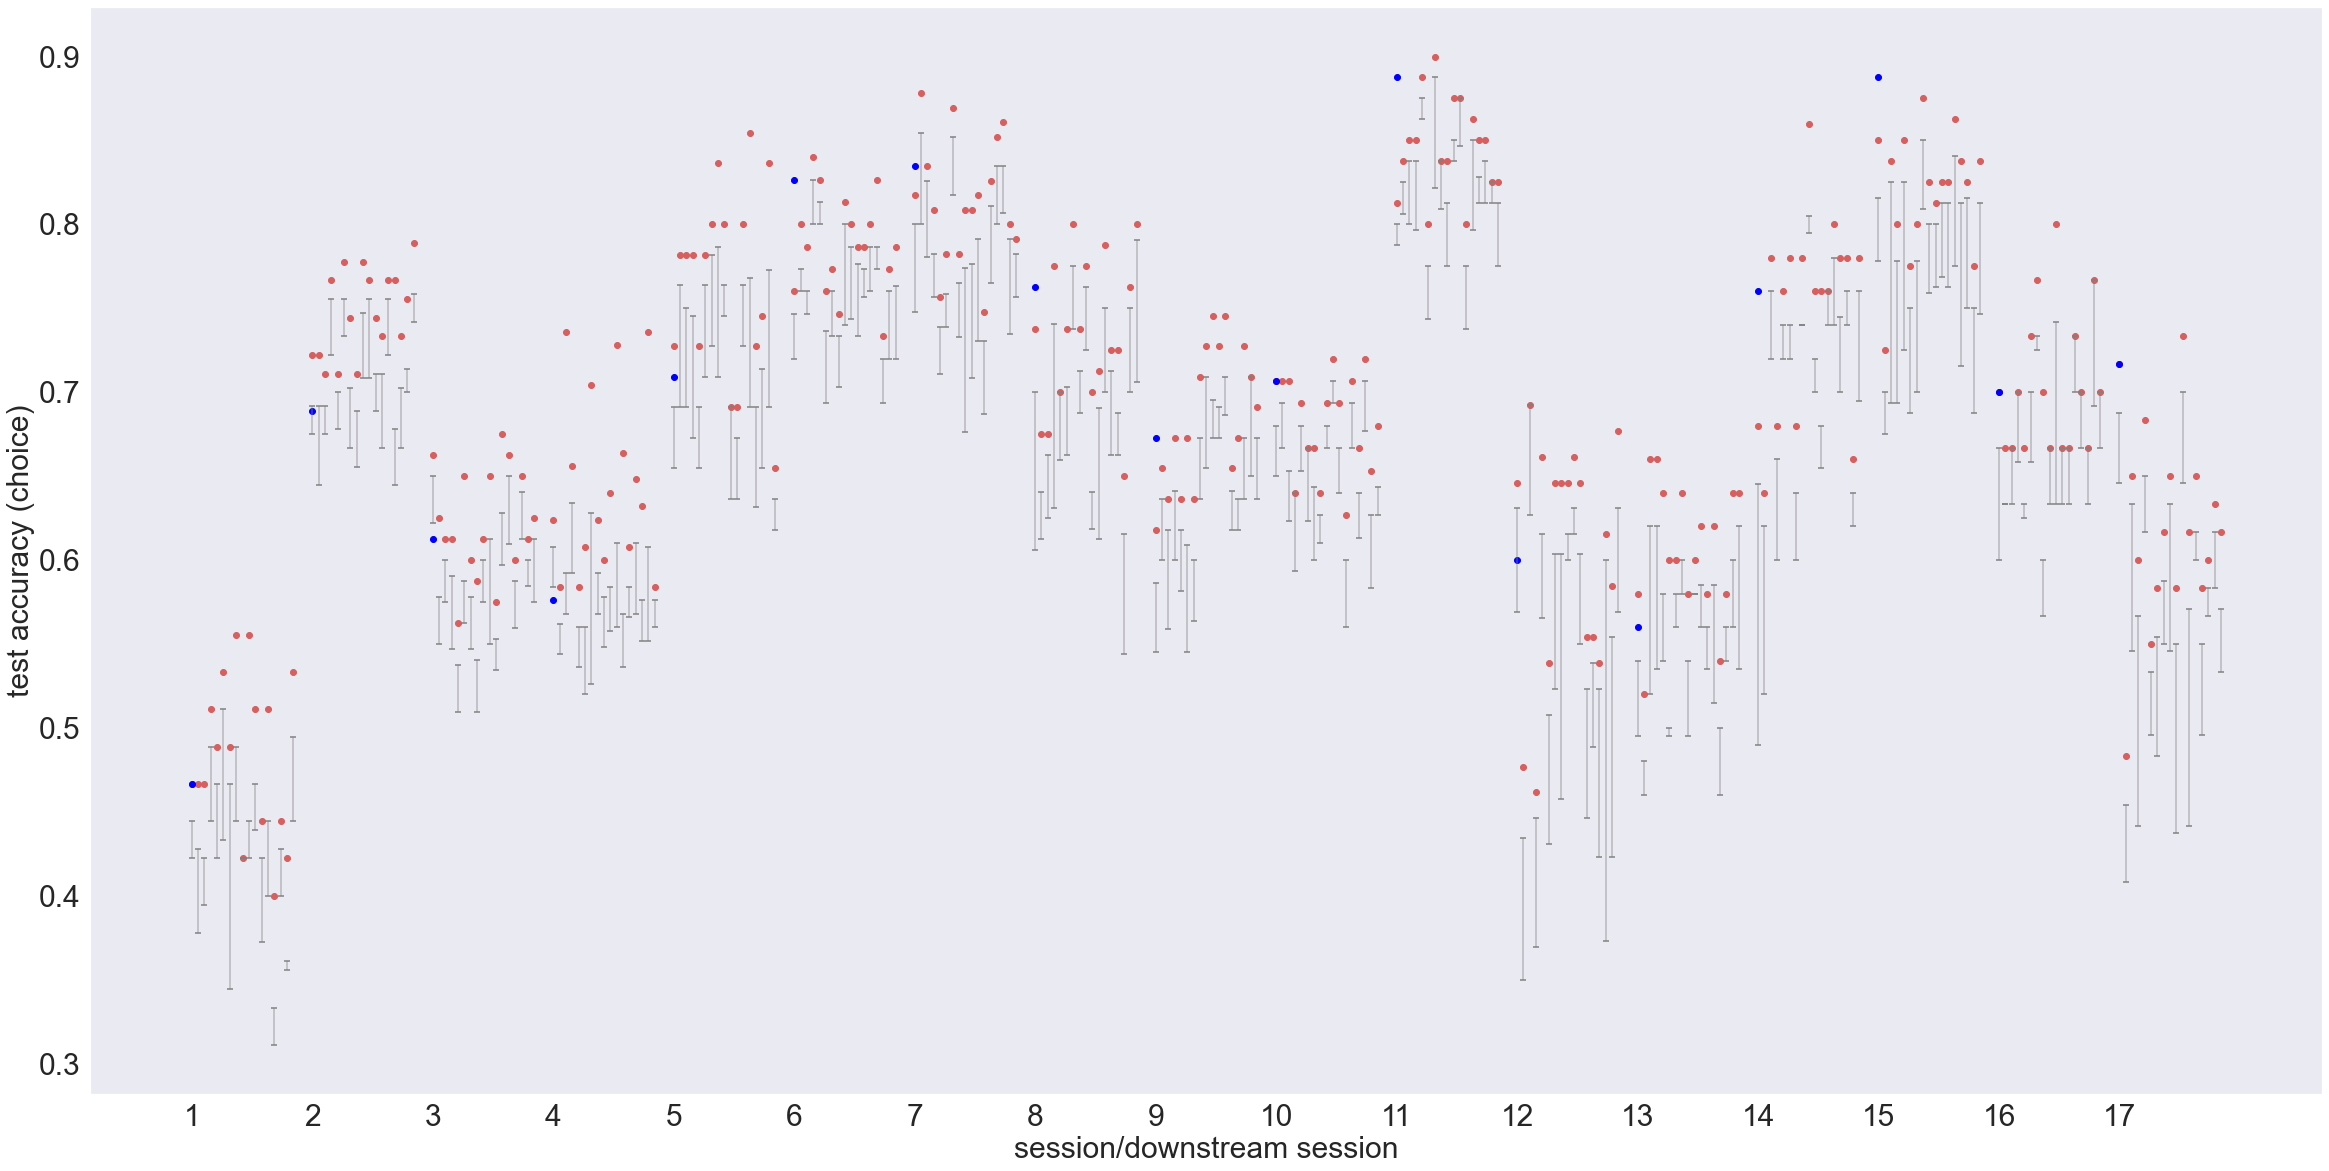

In [559]:
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[:17],[accs_with[s-1,s2-1,:].max() for s in range(1,18)],
                c='r',label='with transfer')

    plt.vlines(s2+np.linspace(0,1,20)[:17],
               [np.quantile(accs_with[s-1,s2-1,:],0.25) for s in range(1,18)],
               [np.quantile(accs_with[s-1,s2-1,:],0.75) for s in range(1,18)],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[:17],[np.quantile(accs_with[s-1,s2-1,:],0.25) for s in range(1,18)],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[:17],[np.quantile(accs_with[s-1,s2-1,:],0.75) for s in range(1,18)],
               color='gray',marker='_')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without[s-1,:].max(),c='blue',label='without transfer')

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

Text(0, 0.5, 'test accuracy (choice)')

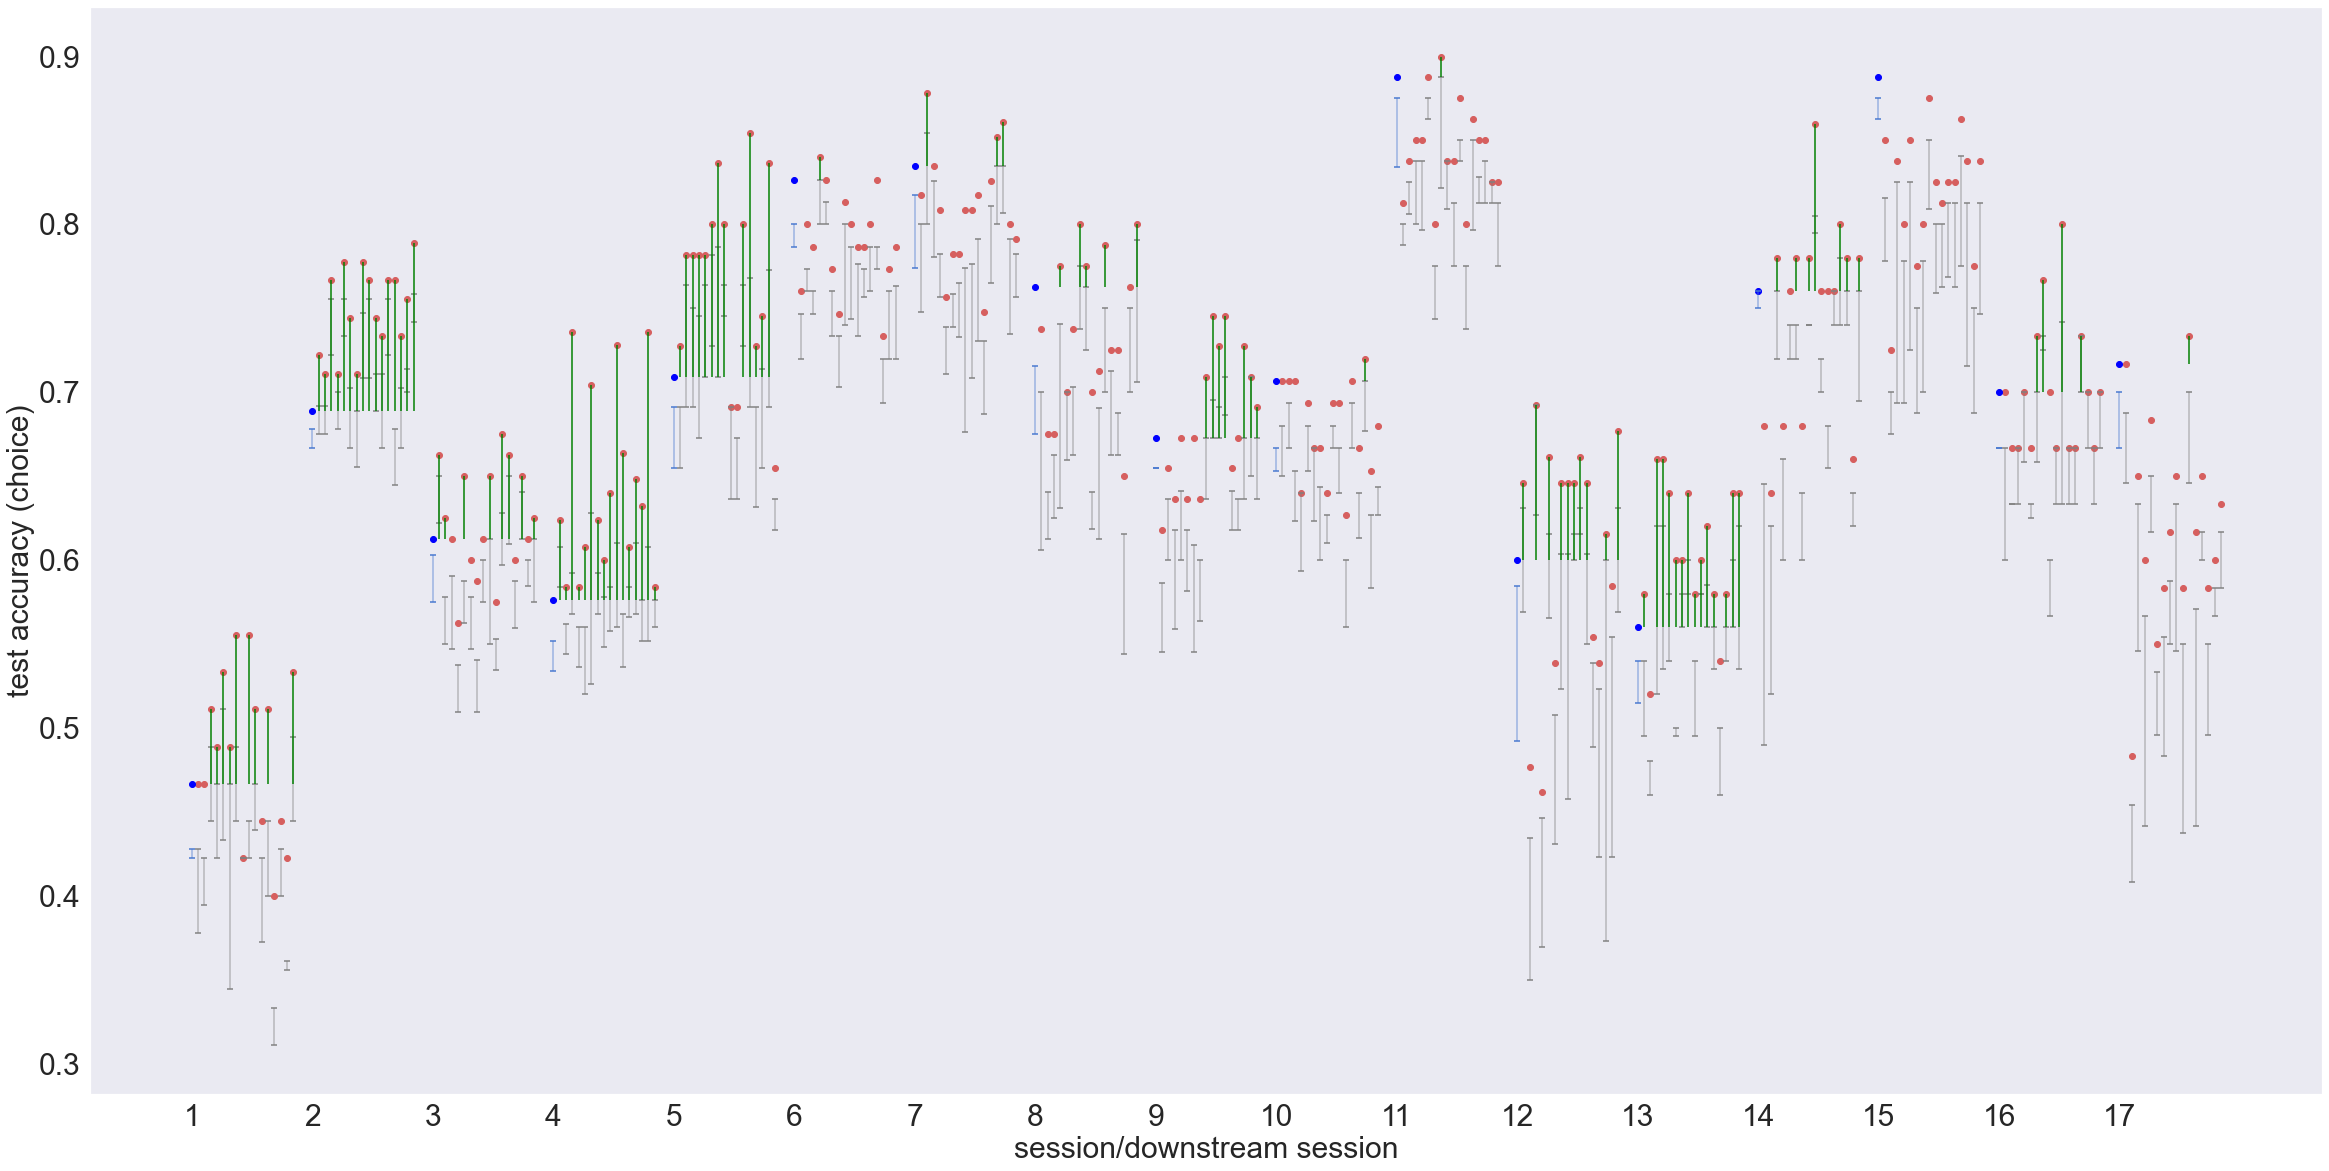

In [672]:
# only one dot for intra-session training
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='r',label='with transfer')

    plt.vlines(s2+np.linspace(0,1,20)[1:17],
               [np.quantile(accs_with[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               [np.quantile(accs_with[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,18):
        if s!=s2 and accs_without[s2-1,:].max()<accs_with[s-1,s2-1,:].max():
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], accs_without[s2-1,:].max(),
                      accs_with[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without[s-1,:],0.25),
               np.quantile(accs_without[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without[s-1,:],0.75),
               color='b',marker='_')

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

Text(0, 0.5, 'test accuracy (choice)')

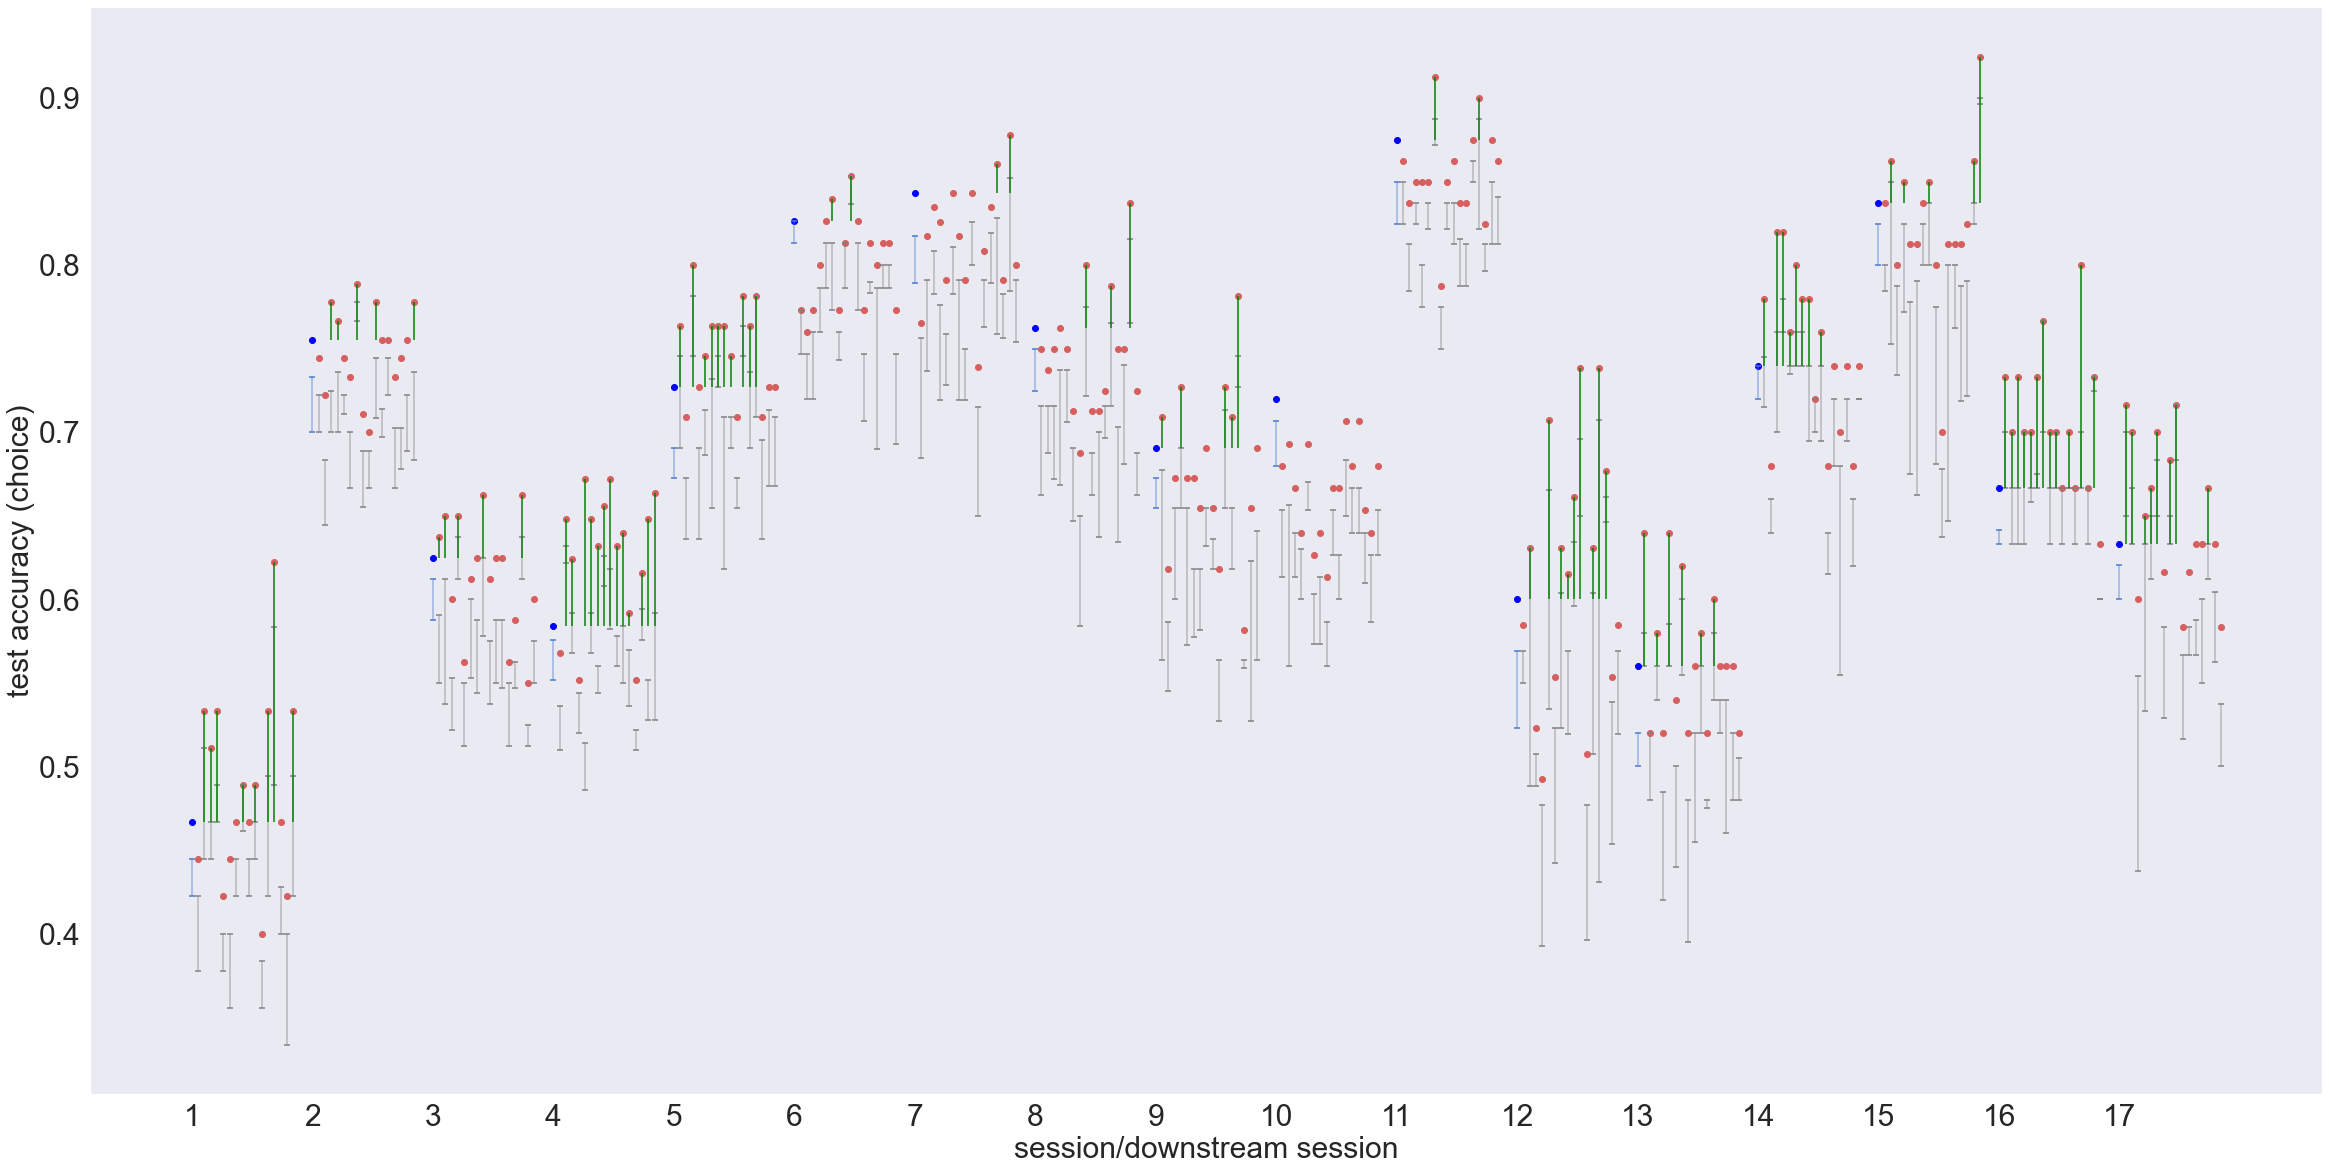

In [1158]:
# only one dot for intra-session training
# One-hot encode No choice

plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with2[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='r',label='with transfer')

    plt.vlines(s2+np.linspace(0,1,20)[1:17],
               [np.quantile(accs_with2[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               [np.quantile(accs_with2[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with2[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with2[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,18):
        if s!=s2 and accs_without2[s2-1,:].max()<accs_with2[s-1,s2-1,:].max():
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], accs_without2[s2-1,:].max(),
                      accs_with2[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without2[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without2[s-1,:],0.25),
               np.quantile(accs_without2[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without2[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without2[s-1,:],0.75),
               color='b',marker='_')

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

Text(0, 0.5, 'test accuracy (choice)')

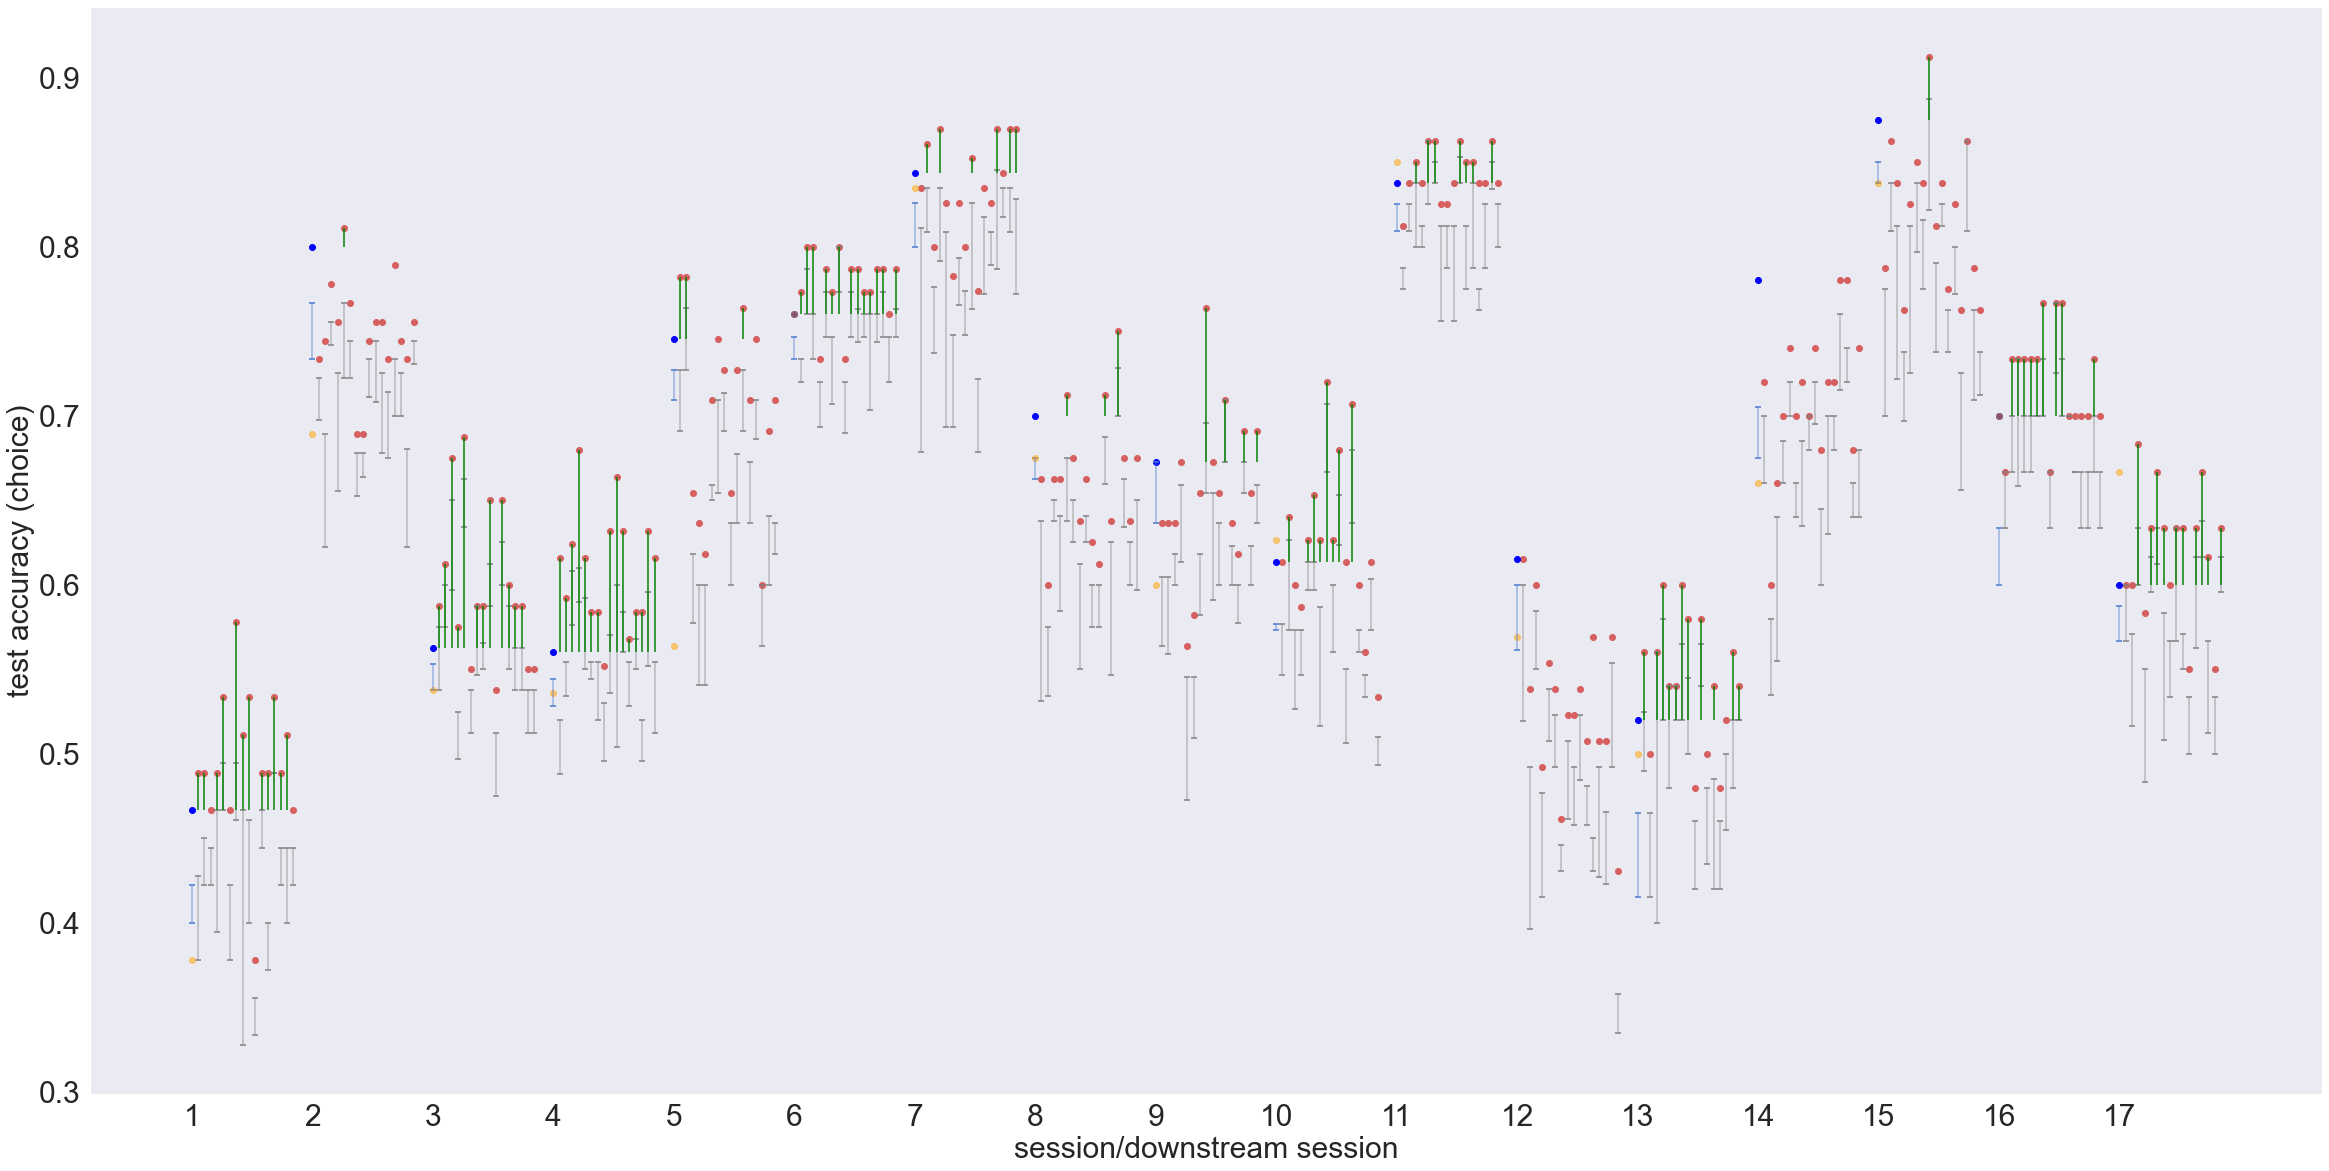

In [1488]:
# only one dot for intra-session training
# One-hot encode No choice, with LR 

plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with2[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='r',label='with transfer')
    
    plt.vlines(s2+np.linspace(0,1,20)[1:17],
               [np.quantile(accs_with2[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               [np.quantile(accs_with2[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with2[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with2[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,18):
        if s!=s2 and accs_without2[s2-1,:].max()<accs_with2[s-1,s2-1,:].max():
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], accs_without2[s2-1,:].max(),
                      accs_with2[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without2[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without2[s-1,:],0.25),
               np.quantile(accs_without2[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without2[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without2[s-1,:],0.75),
               color='b',marker='_')
    
    #LR
    plt.scatter(s,accs_without_L[s-1],c='orange',label='LR',alpha=0.5)

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

Text(0, 0.5, 'test accuracy (choice)')

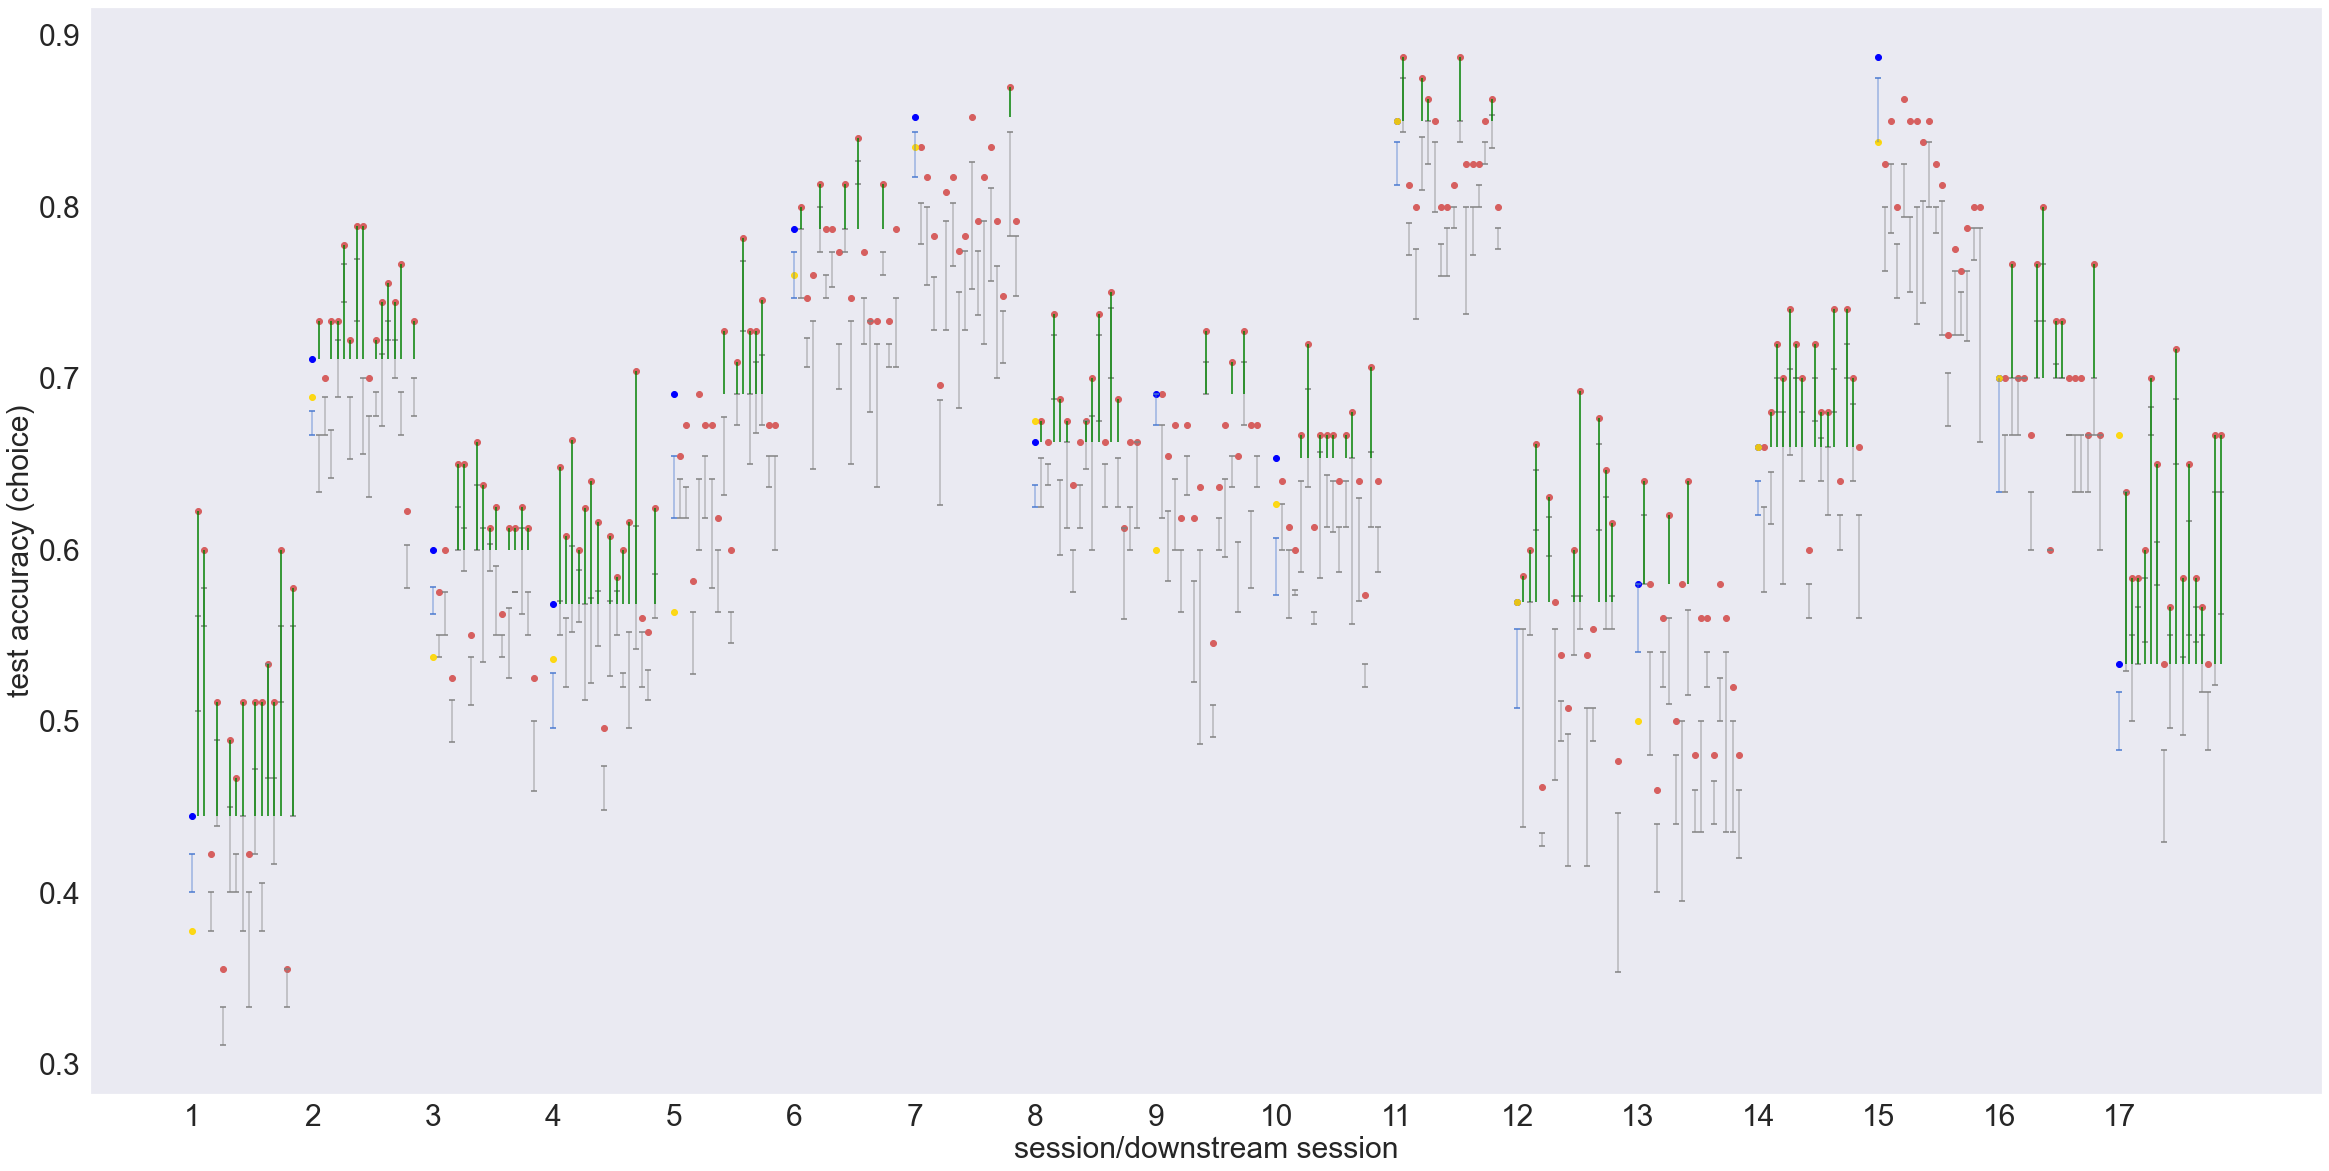

In [1496]:
# only one dot for intra-session training
# One-hot encode No choice, with LR (Simulation No. 2)

plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with2[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='r',label='with transfer')
    
    plt.vlines(s2+np.linspace(0,1,20)[1:17],
               [np.quantile(accs_with2[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               [np.quantile(accs_with2[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with2[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with2[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,18):
        if s!=s2 and accs_without2[s2-1,:].max()<accs_with2[s-1,s2-1,:].max():
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], accs_without2[s2-1,:].max(),
                      accs_with2[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without2[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without2[s-1,:],0.25),
               np.quantile(accs_without2[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without2[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without2[s-1,:],0.75),
               color='b',marker='_')
    
    #LR
    plt.scatter(s,accs_without_L[s-1],c='gold',label='LR',alpha=0.9)

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

Text(0, 0.5, 'test accuracy (choice)')

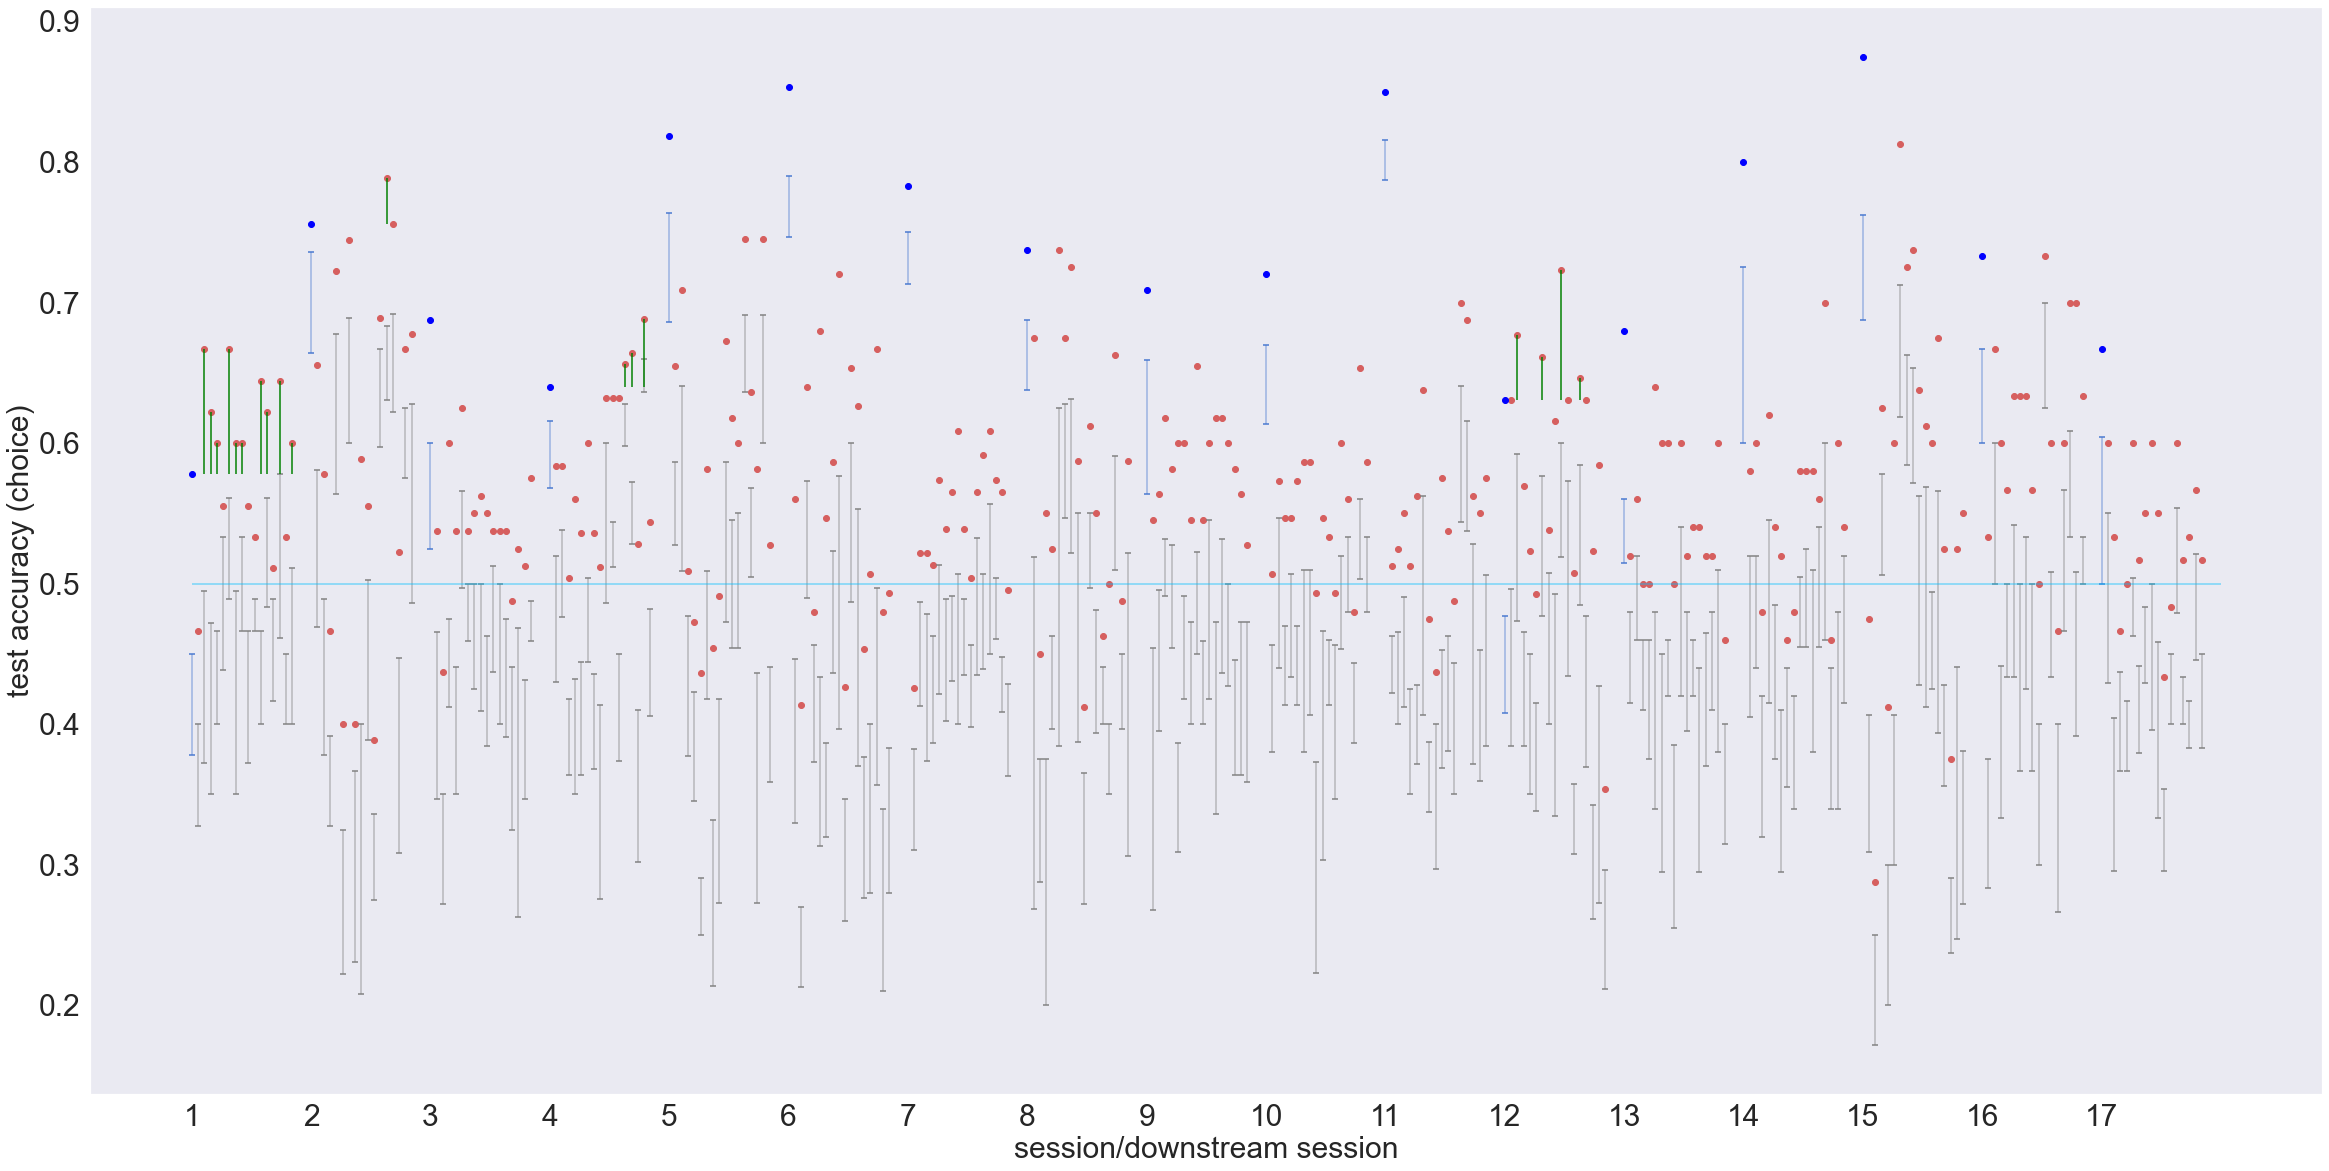

In [1334]:
# only one dot for intra-session training
# One-hot encode No choice (w/ No Retrain)

plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with_noretrain[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='r',label='with transfer')
    
    plt.vlines(s2+np.linspace(0,1,20)[1:17],
               [np.quantile(accs_with_noretrain[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               [np.quantile(accs_with_noretrain[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with_noretrain[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with_noretrain[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,18):
        if s!=s2 and accs_without_noretrain[s2-1,:].max()<accs_with_noretrain[s-1,s2-1,:].max():
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], accs_without_noretrain[s2-1,:].max(),
                      accs_with_noretrain[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without_noretrain[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without_noretrain[s-1,:],0.25),
               np.quantile(accs_without_noretrain[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without_noretrain[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without_noretrain[s-1,:],0.75),
               color='b',marker='_')

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.hlines(0.5,1,18,alpha=0.5,linestyles='solid',color='deepskyblue')
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

Text(0, 0.5, 'test accuracy (choice)')

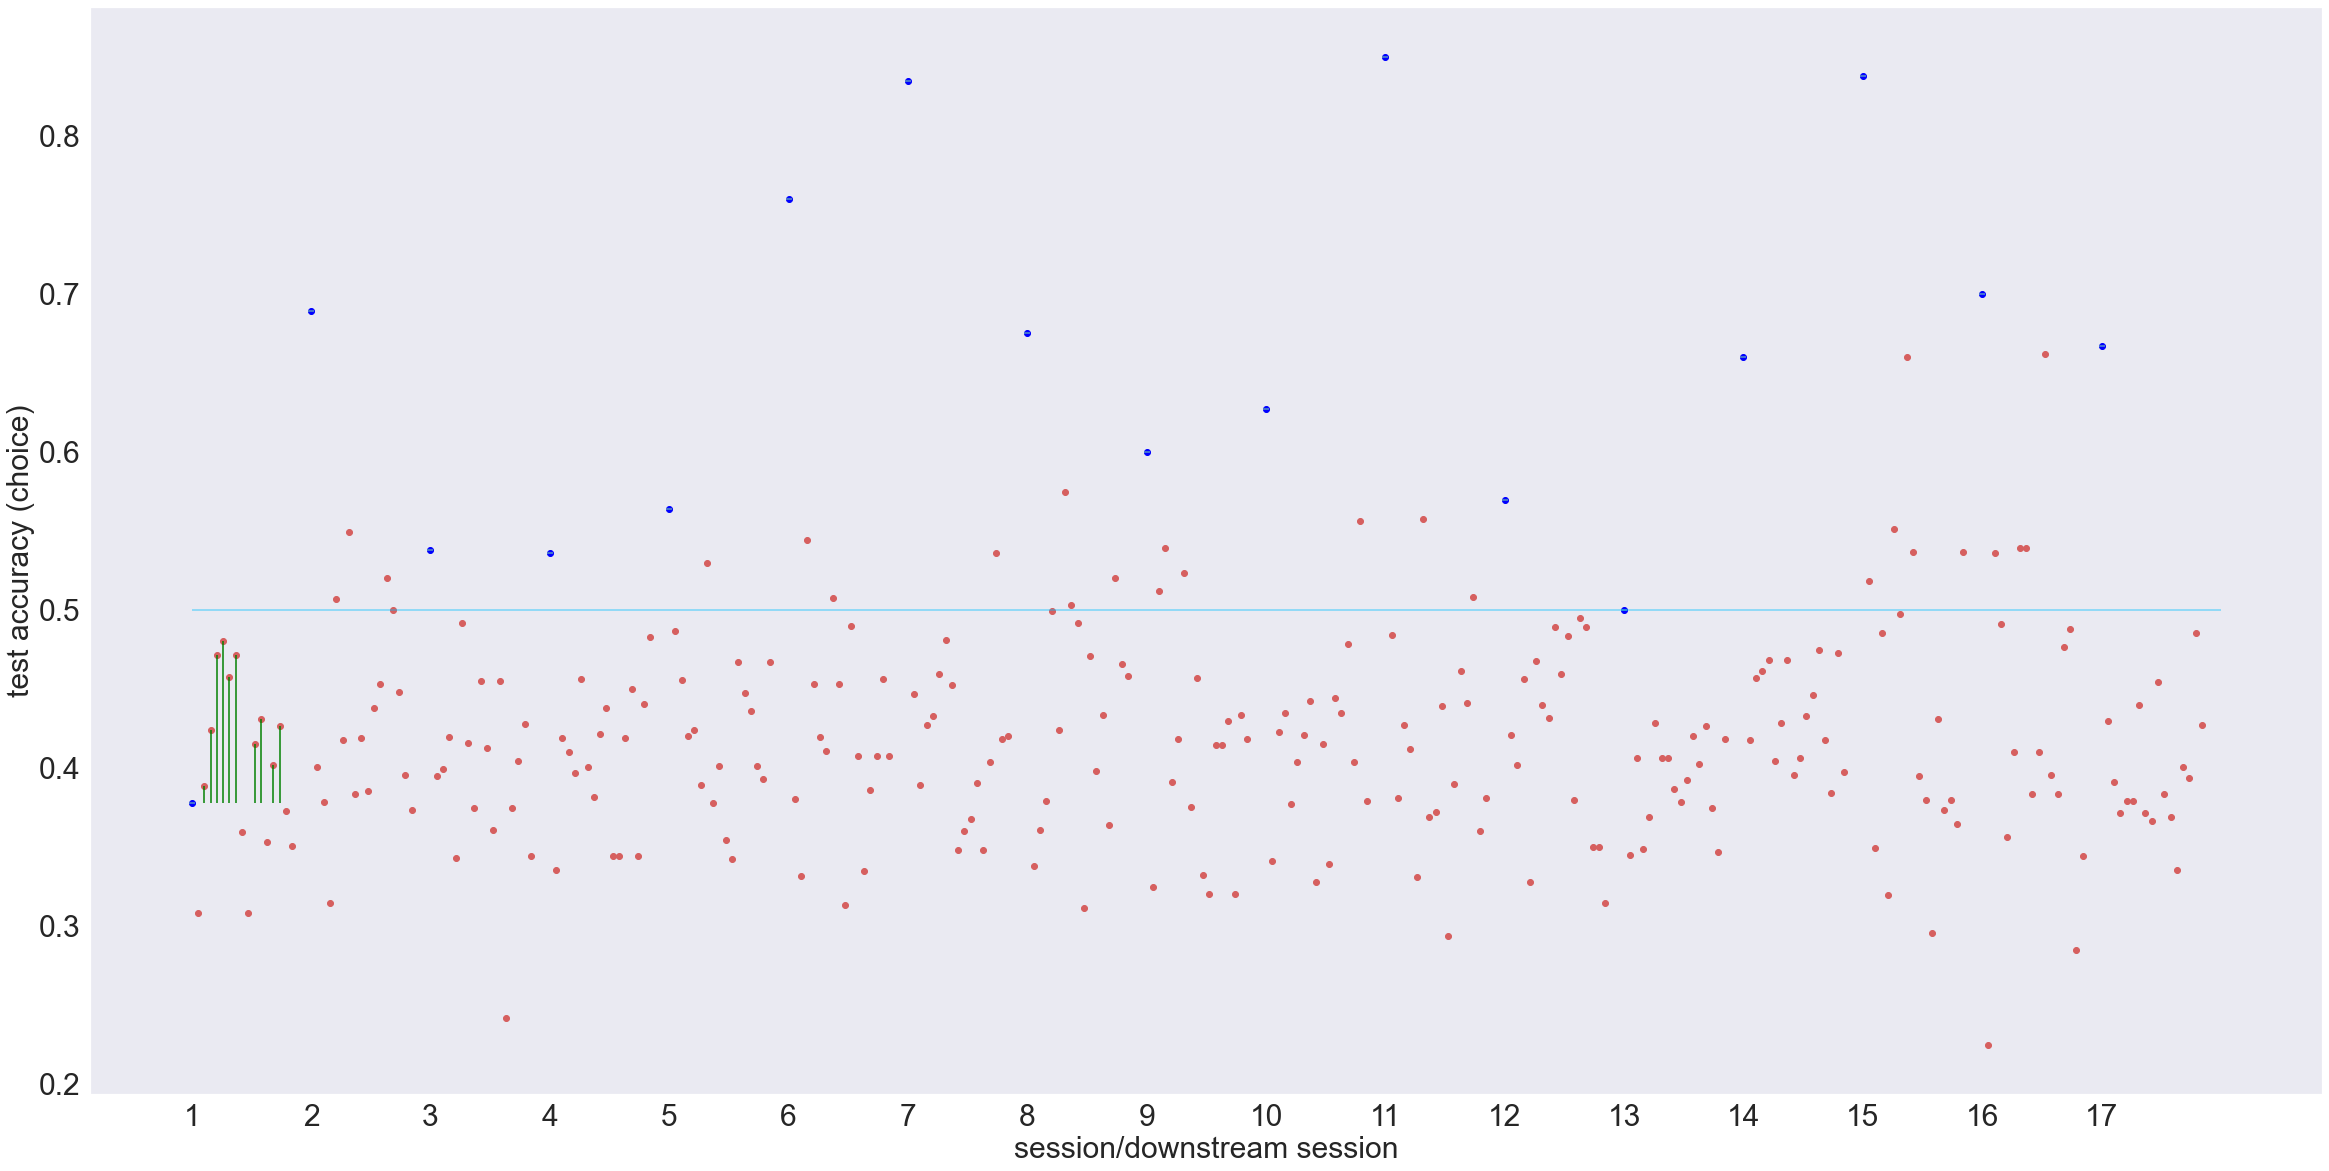

In [1410]:
# only one dot for intra-session training
# One-hot encode No choice (w/ No Retrain, test transfer on all data, Logistic Regression)

plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with_noretrain_L[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='r',label='with transfer')
    
    for s in range(1,18):
        if s!=s2 and accs_without_noretrain_L[s2-1,:].max()<accs_with_noretrain_L[s-1,s2-1,:].max():
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], accs_without_noretrain_L[s2-1,:].max(),
                      accs_with_noretrain_L[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without_noretrain_L[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without_noretrain_L[s-1,:],0.25),
               np.quantile(accs_without_noretrain_L[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without_noretrain_L[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without_noretrain_L[s-1,:],0.75),
               color='b',marker='_')

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.hlines(0.5,1,18,alpha=0.5,linestyles='solid',color='deepskyblue')
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

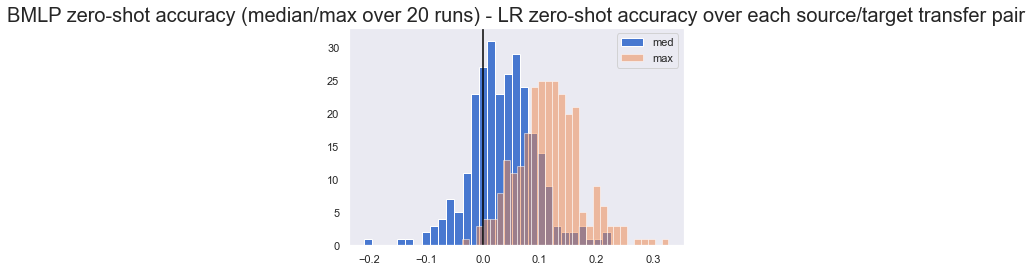

In [1420]:
plt.hist([np.median(accs_with_noretrain3[s-1,s2-1])-accs_with_noretrain_L[s-1,s2-1,:].max() for s in range(1,18) for s2 in range(1,18) if s!=s2],
        bins=30,label='med')
plt.vlines(0,0,33,color='black'); plt.ylim((0,33))
plt.title('BMLP zero-shot accuracy (median over 20 runs) - LR zero-shot accuracy over every source/target transfer pair',
         fontsize=20)

plt.hist([accs_with_noretrain3[s-1,s2-1].max()-accs_with_noretrain_L[s-1,s2-1,:].max() for s in range(1,18) for s2 in range(1,18) if s!=s2],
        bins=30,alpha=0.5,label='max')
plt.title('BMLP zero-shot accuracy (median/max over 20 runs) - LR zero-shot accuracy over each source/target transfer pair',
         fontsize=20)
plt.legend()

(0.0, 35.0)

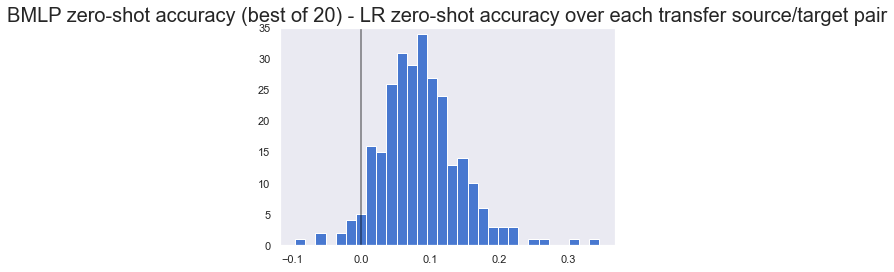

In [1477]:
#plt.hist([np.median(accs_with_noretrain3[s-1,s2-1])-accs_with_noretrain_L[s-1,s2-1,:].max() for s in range(1,18) for s2 in range(1,18) if s!=s2],
        #bins=30,label='med')
#plt.vlines(0,0,33,color='black'); plt.ylim((0,33))
#plt.title('BMLP zero-shot accuracy (median over 20 runs) - LR zero-shot accuracy over every source/target transfer pair',
         #fontsize=20)

plt.hist([accs_with_noretrain3[s-1,s2-1].max()-accs_with_noretrain_L[s-1,s2-1,:].max() for s in range(1,18) for s2 in range(1,18) if s!=s2],
        bins=30,alpha=1.0,label='max')
plt.title('BMLP zero-shot accuracy (best of 20) - LR zero-shot accuracy over each transfer source/target pair',
         fontsize=20)
plt.vlines(0,0,35,color='black',linestyles='solid',alpha=0.5); plt.ylim((0,35))

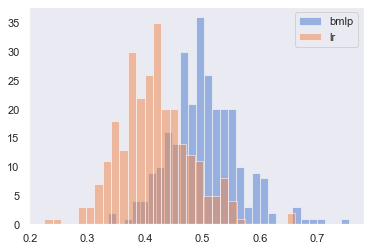

In [1526]:
plt.hist([accs_with_noretrain3[s-1,s2-1].max() for s in range(1,18) for s2 in range(1,18) if s!=s2],
        bins=30,alpha=0.5,label='bmlp')[2]
plt.hist([accs_with_noretrain_L[s-1,s2-1,:].max() for s in range(1,18) for s2 in range(1,18) if s!=s2],
        bins=30,alpha=0.5,label='lr')[2]; plt.legend()


Text(0, 0.5, 'test accuracy (choice)')

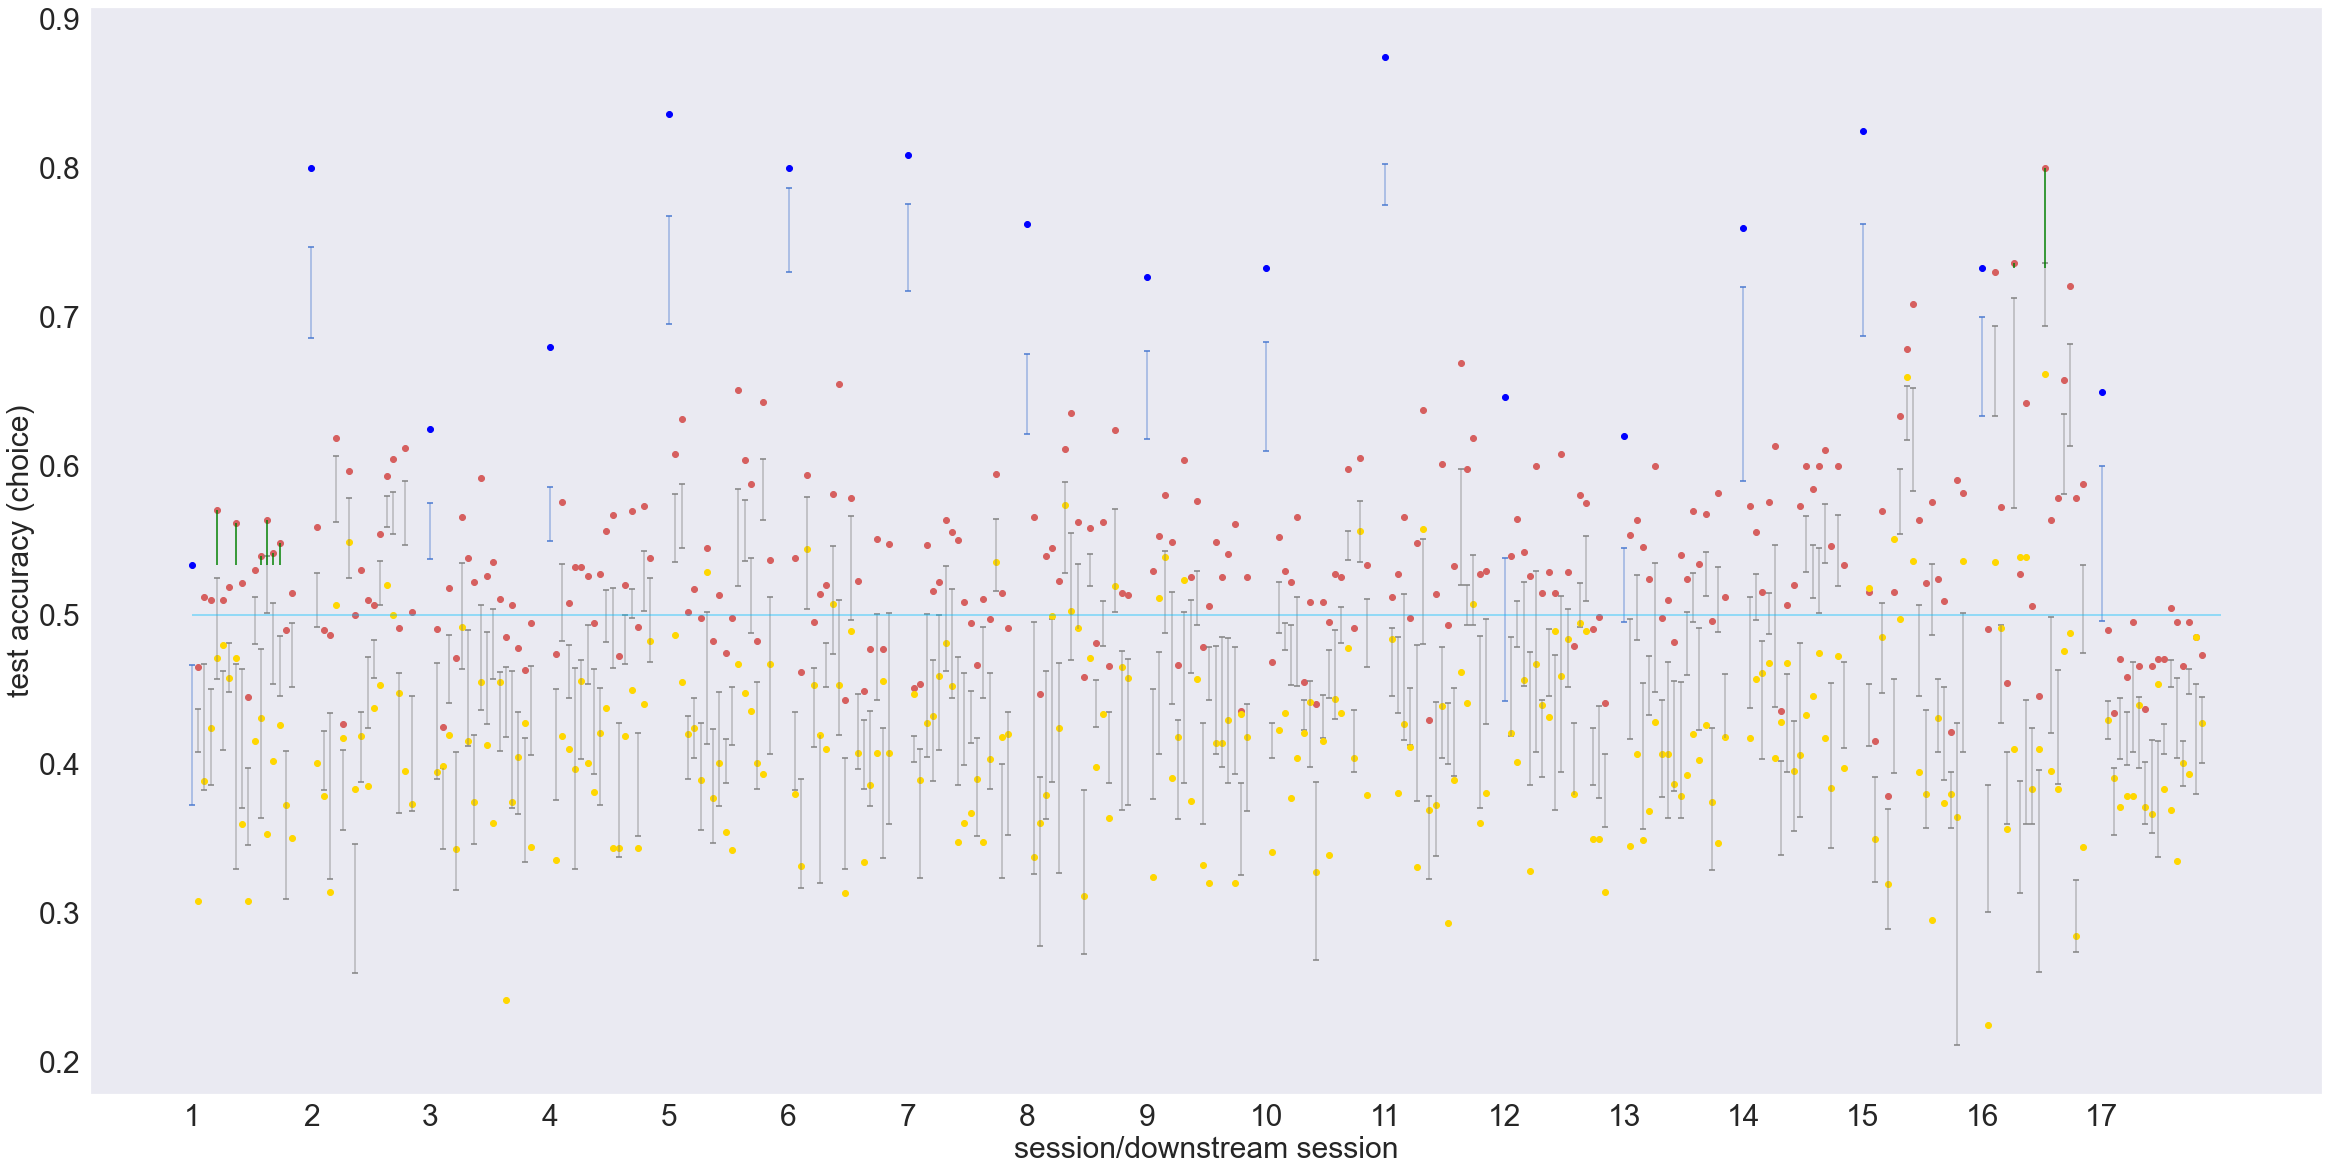

In [1425]:
# only one dot for intra-session training
# One-hot encode No choice (w/ No Retrain, test on all data)

plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with_noretrain3[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='r',label='with transfer')
    
    plt.vlines(s2+np.linspace(0,1,20)[1:17],
               [np.quantile(accs_with_noretrain3[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               [np.quantile(accs_with_noretrain3[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with_noretrain3[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with_noretrain3[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,18):
        if s!=s2 and accs_without_noretrain3[s2-1,:].max()<accs_with_noretrain3[s-1,s2-1,:].max():
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], accs_without_noretrain3[s2-1,:].max(),
                      accs_with_noretrain3[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without_noretrain3[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without_noretrain3[s-1,:],0.25),
               np.quantile(accs_without_noretrain3[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without_noretrain3[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without_noretrain3[s-1,:],0.75),
               color='b',marker='_')

    
#LR

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with_noretrain_L[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='gold',label='with transfer')
    
plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.hlines(0.5,1,18,alpha=0.5,linestyles='solid',color='deepskyblue')
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

Text(0, 0.5, 'test accuracy (choice)')

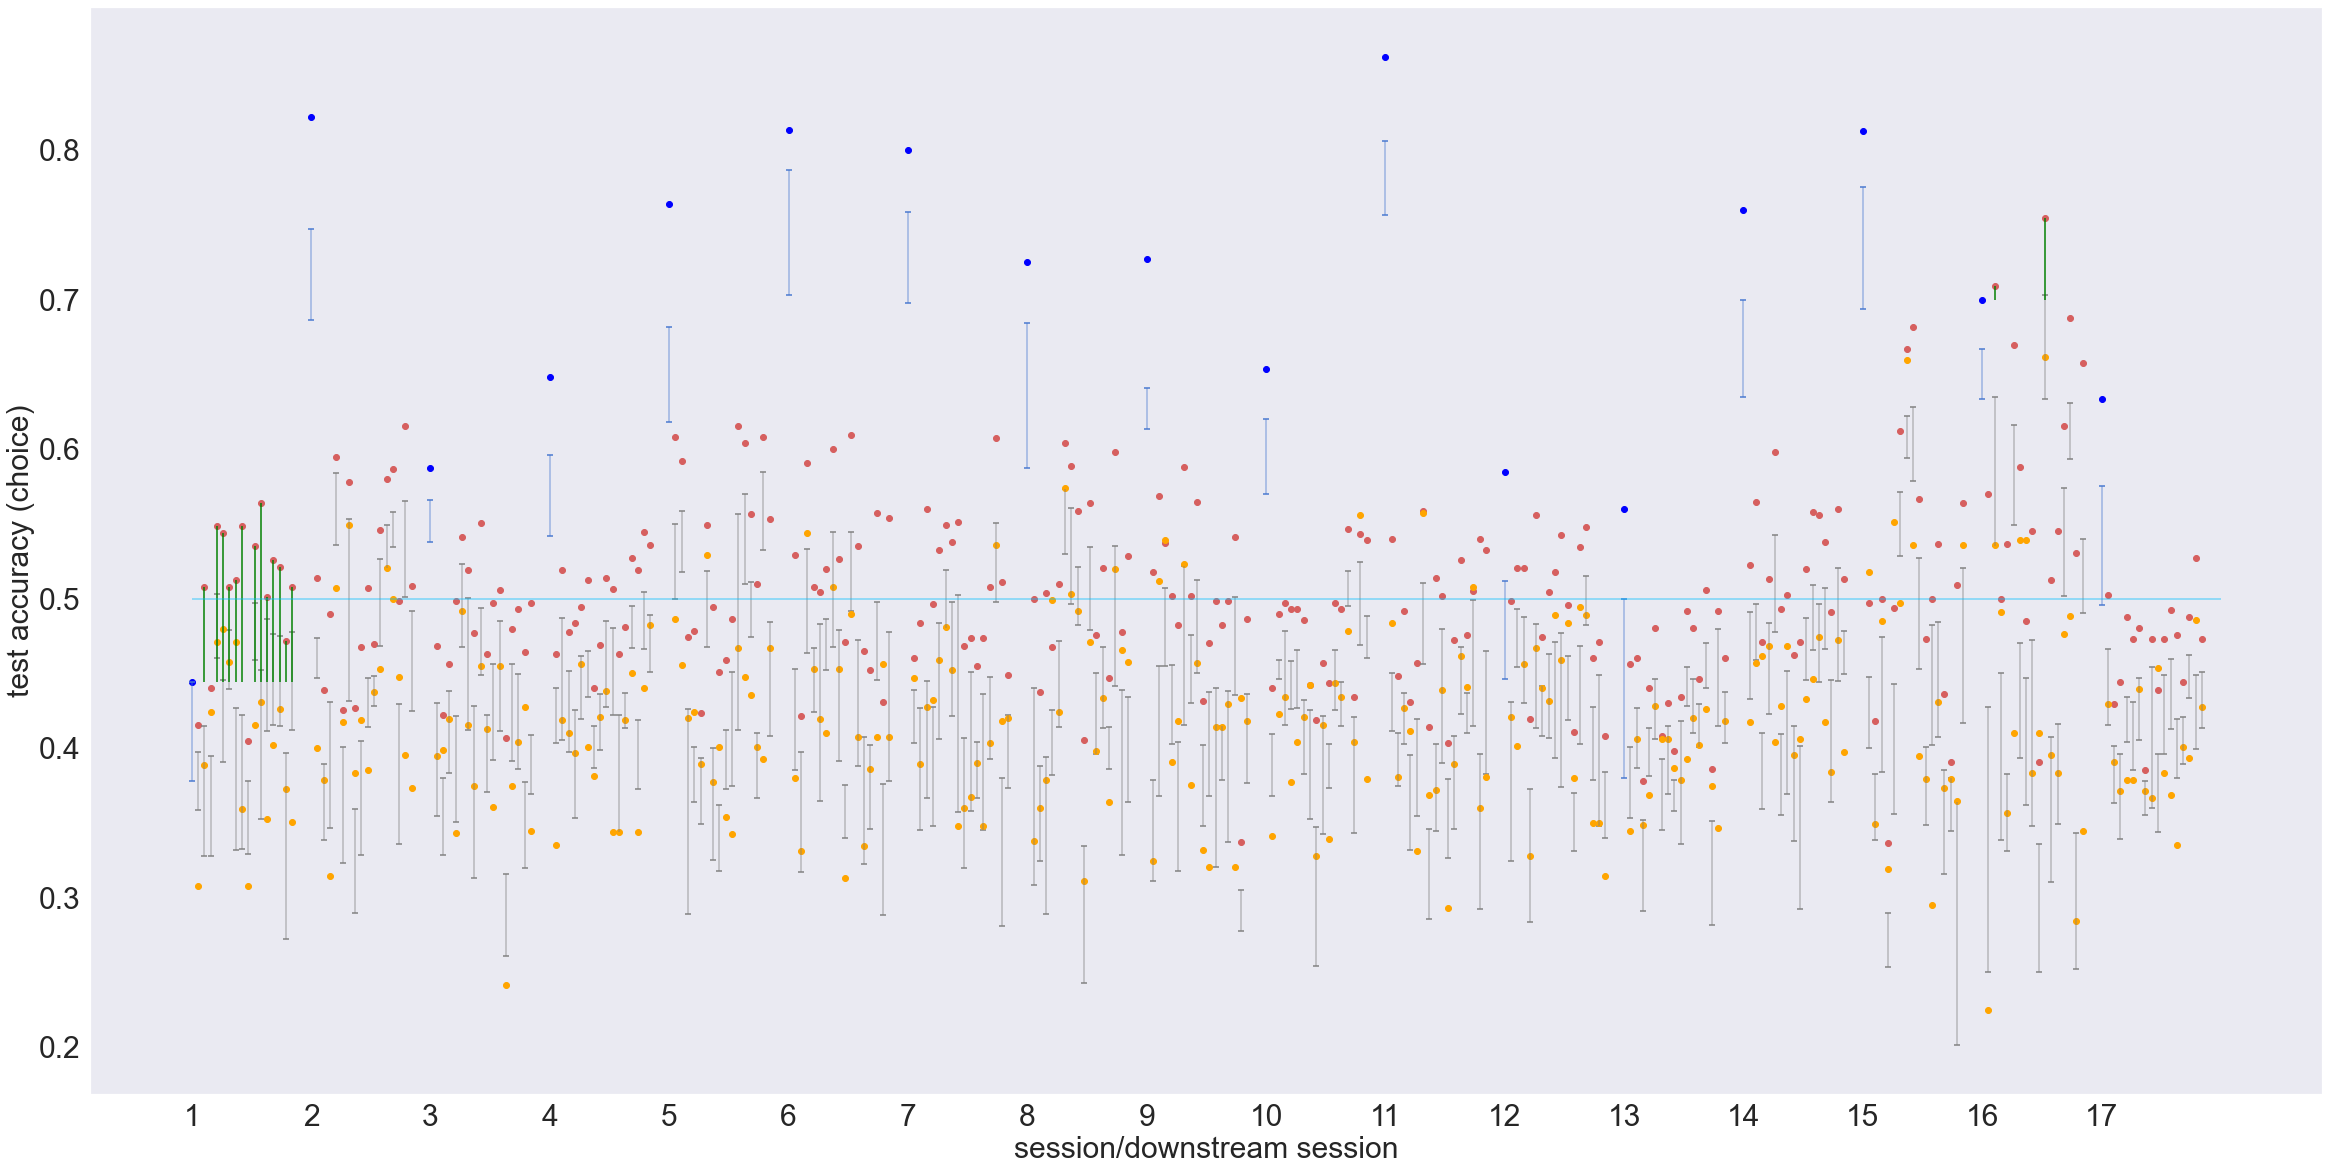

In [1442]:
# only one dot for intra-session training
# One-hot encode No choice (w/ No Retrain, test on all data),

plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with_noretrain3[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='r',label='with transfer')
    
    plt.vlines(s2+np.linspace(0,1,20)[1:17],
               [np.quantile(accs_with_noretrain3[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               [np.quantile(accs_with_noretrain3[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with_noretrain3[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with_noretrain3[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,18):
        if s!=s2 and accs_without_noretrain3[s2-1,:].max()<accs_with_noretrain3[s-1,s2-1,:].max():
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], accs_without_noretrain3[s2-1,:].max(),
                      accs_with_noretrain3[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without_noretrain3[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without_noretrain3[s-1,:],0.25),
               np.quantile(accs_without_noretrain3[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without_noretrain3[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without_noretrain3[s-1,:],0.75),
               color='b',marker='_')

    
#LR

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[accs_with_noretrain_L[s-1,s2-1,:].max() for s in range(1,18) if s!=s2],
                c='orange',label='with transfer')
    
plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.hlines(0.5,1,18,alpha=0.5,linestyles='solid',color='deepskyblue')
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

In [1457]:
# sessions where zero-shot transfer accuracy (25%th percentile) above 50 percent
len([(s,s2) for s in np.arange(1,18) for s2 \
 in np.arange(1,18) if accs_with_noretrain3[s-1,s2-1,:].max()>0.5 if s!=s2])

131

Text(0, 0.5, 'test accuracy (choice)')

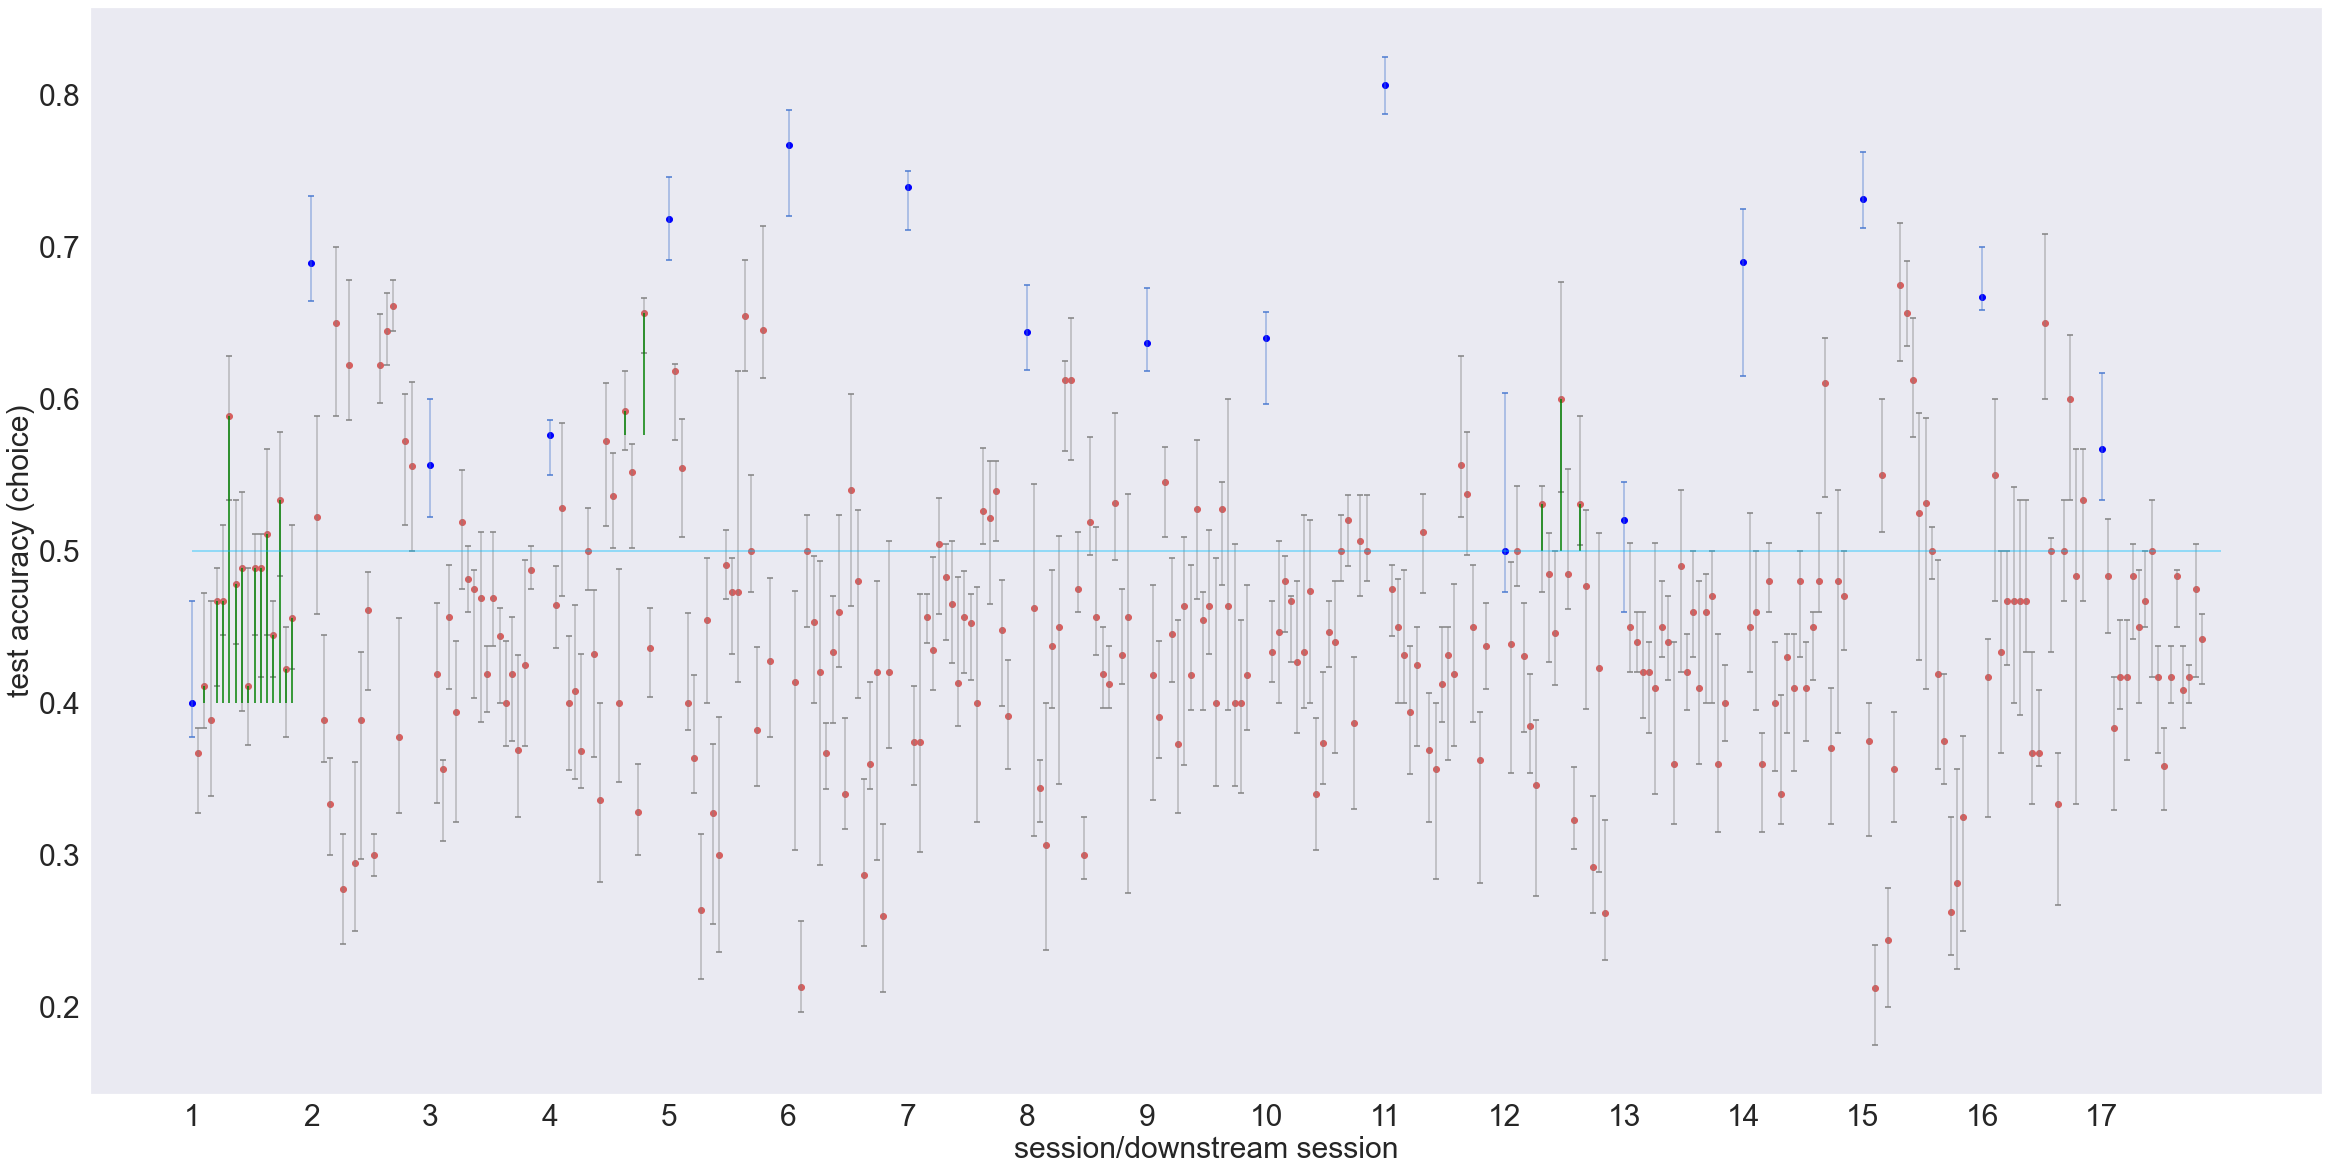

In [1330]:
# only one dot for intra-session training
# One-hot encode No choice (w/ No Retrain, AND posterior transfer every other training epoch)

plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.median(accs_with_noretrain2[s-1,s2-1,:]) for s in range(1,18) if s!=s2],
                c='r',label='with transfer')
    
    plt.vlines(s2+np.linspace(0,1,20)[1:17],
               [np.quantile(accs_with_noretrain2[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               [np.quantile(accs_with_noretrain2[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with_noretrain2[s-1,s2-1,:],0.25) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:17],[np.quantile(accs_with_noretrain2[s-1,s2-1,:],0.75) for s in range(1,18) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,18):
        if s!=s2 and np.median(accs_without_noretrain2[s2-1,:])<np.median(accs_with_noretrain2[s-1,s2-1,:]):
            ind = [u for u in range(1,18) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:17][ind], np.median(accs_without_noretrain2[s2-1,:]),
                      np.median(accs_with_noretrain2[s-1,s2-1,:]),color='green')
    
    
for s in range(1,18):
    plt.scatter(s,np.median(accs_without_noretrain2[s-1,:]),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without_noretrain2[s-1,:],0.25),
               np.quantile(accs_without_noretrain2[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without_noretrain2[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without_noretrain2[s-1,:],0.75),
               color='b',marker='_')

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.hlines(0.5,1,18,alpha=0.5,linestyles='solid',color='deepskyblue')
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

array([-0.125     , -0.11477273, -0.10454545, -0.09431818, -0.08409091,
       -0.07386364, -0.06363636, -0.05340909, -0.04318182, -0.03295455,
       -0.02272727, -0.0125    , -0.00227273,  0.00795455,  0.01818182,
        0.02840909,  0.03863636,  0.04886364,  0.05909091,  0.06931818,
        0.07954545,  0.08977273,  0.1       ,  0.11022727,  0.12045455,
        0.13068182,  0.14090909,  0.15113636,  0.16136364,  0.17159091,
        0.18181818])

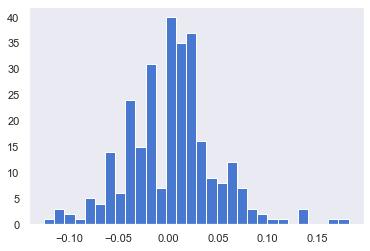

In [1322]:
plt.hist([accs_with_noretrain2[s-1,s2-1,:].max() - accs_with_noretrain[s-1,s2-1,:].max() for s in range(1,18) for s2 in range(1,18)],
        bins=30)[1]

Text(0, 0.5, 'test accuracy (choice)')

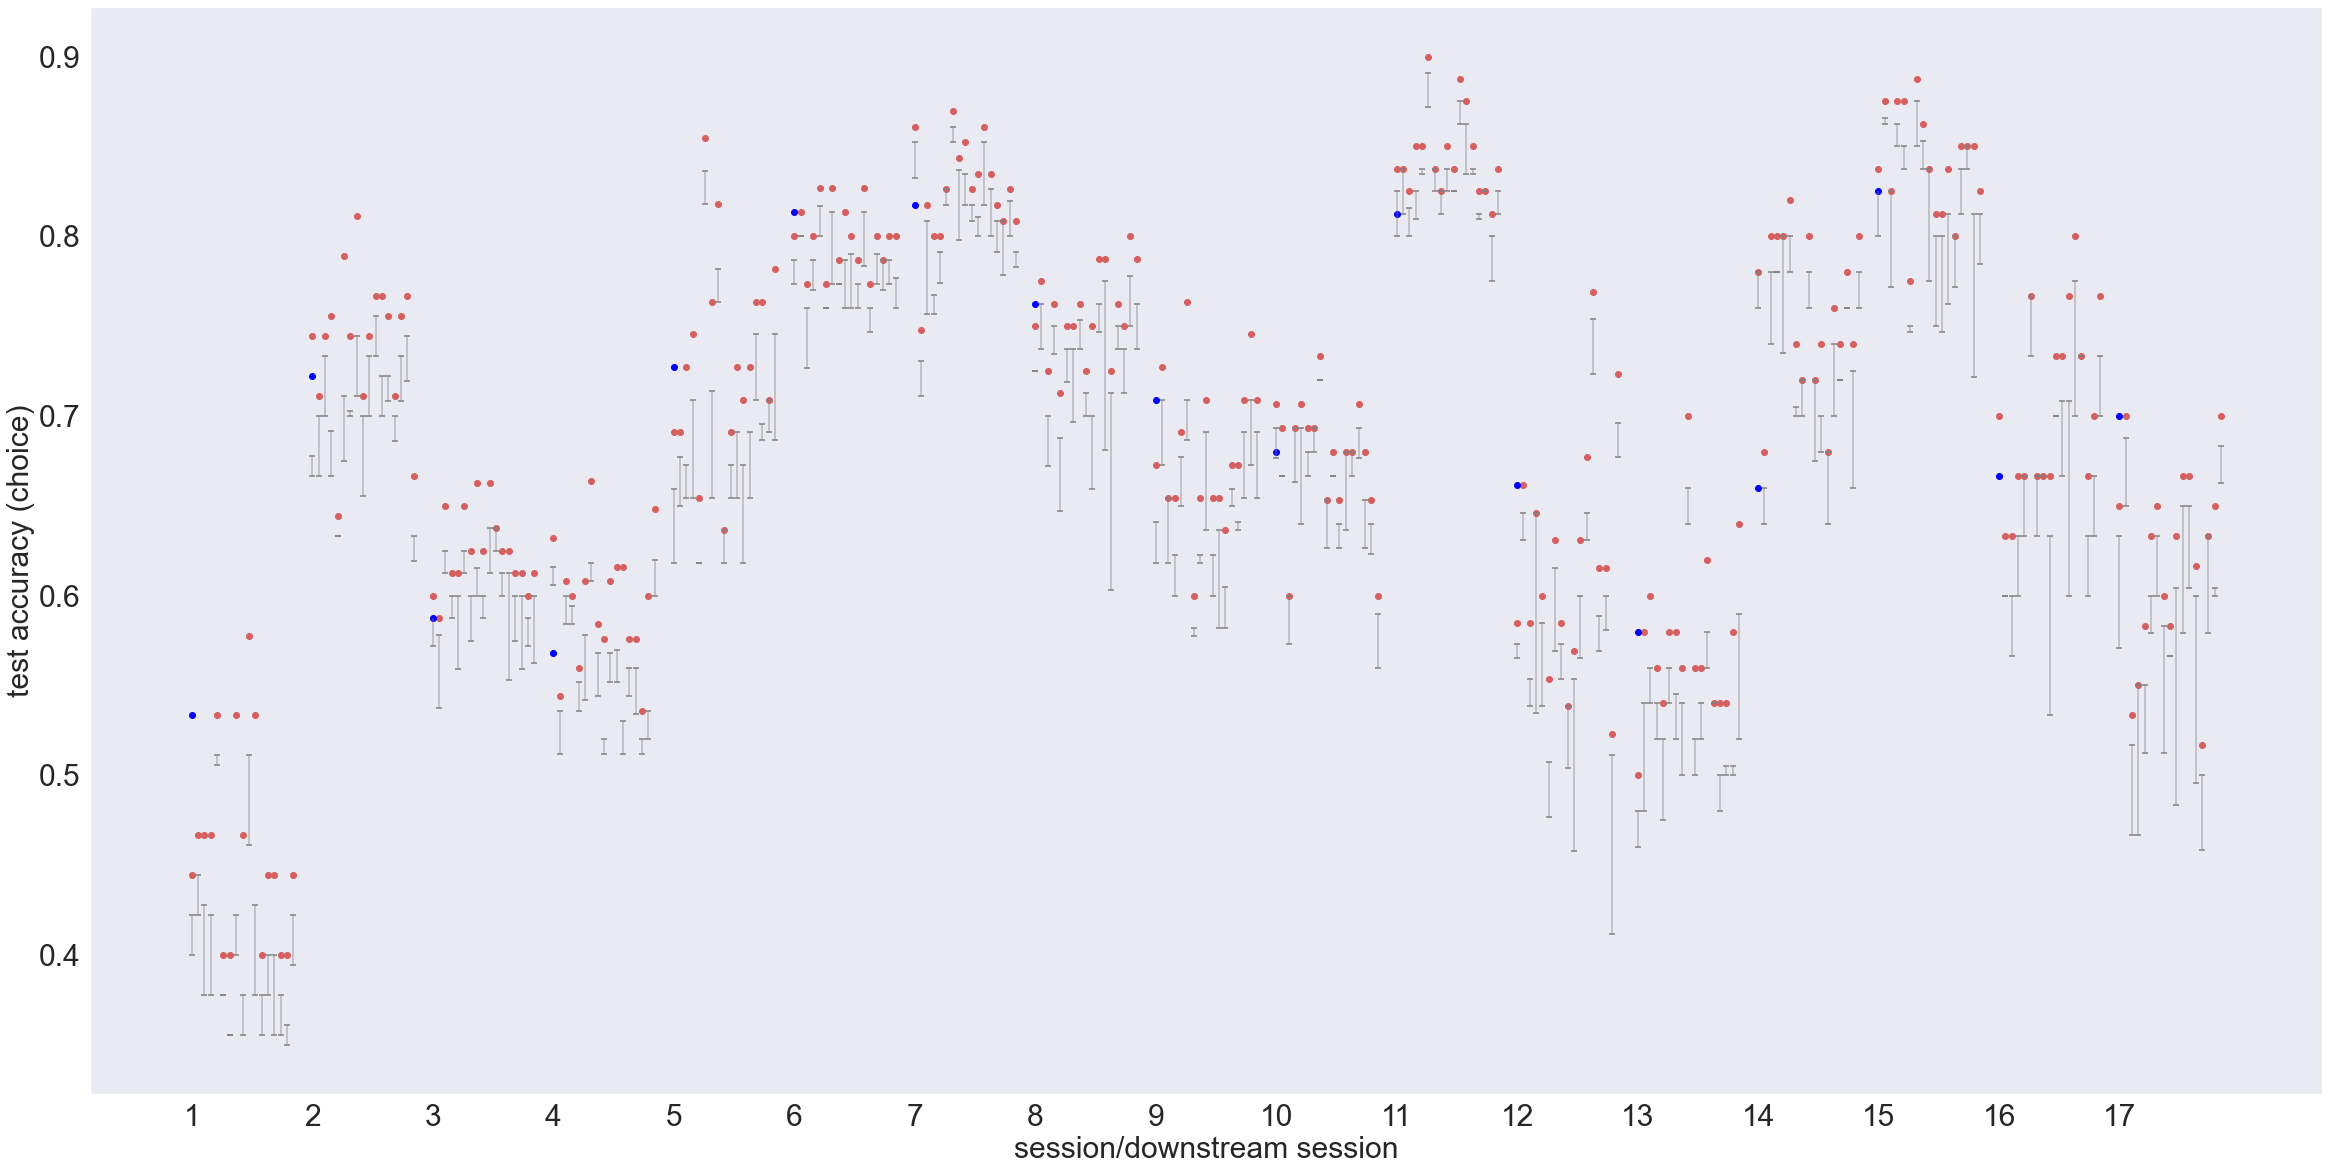

In [604]:
# WITH POSTERIOR TRANSFER
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[:17],[accs_with__posteriortransfer[s-1,s2-1,:].max() for s in range(1,18)],
                c='r',label='with transfer')

    plt.vlines(s2+np.linspace(0,1,20)[:17],
               [np.quantile(accs_with__posteriortransfer[s-1,s2-1,:],0.25) for s in range(1,18)],
               [np.quantile(accs_with__posteriortransfer[s-1,s2-1,:],0.75) for s in range(1,18)],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[:17],[np.quantile(accs_with__posteriortransfer[s-1,s2-1,:],0.25) for s in range(1,18)],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[:17],[np.quantile(accs_with__posteriortransfer[s-1,s2-1,:],0.75) for s in range(1,18)],
               color='gray',marker='_')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without__posteriortransfer[s-1,:].max(),c='blue',label='without transfer')

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

Text(0, 0.5, 'test accuracy (choice)')

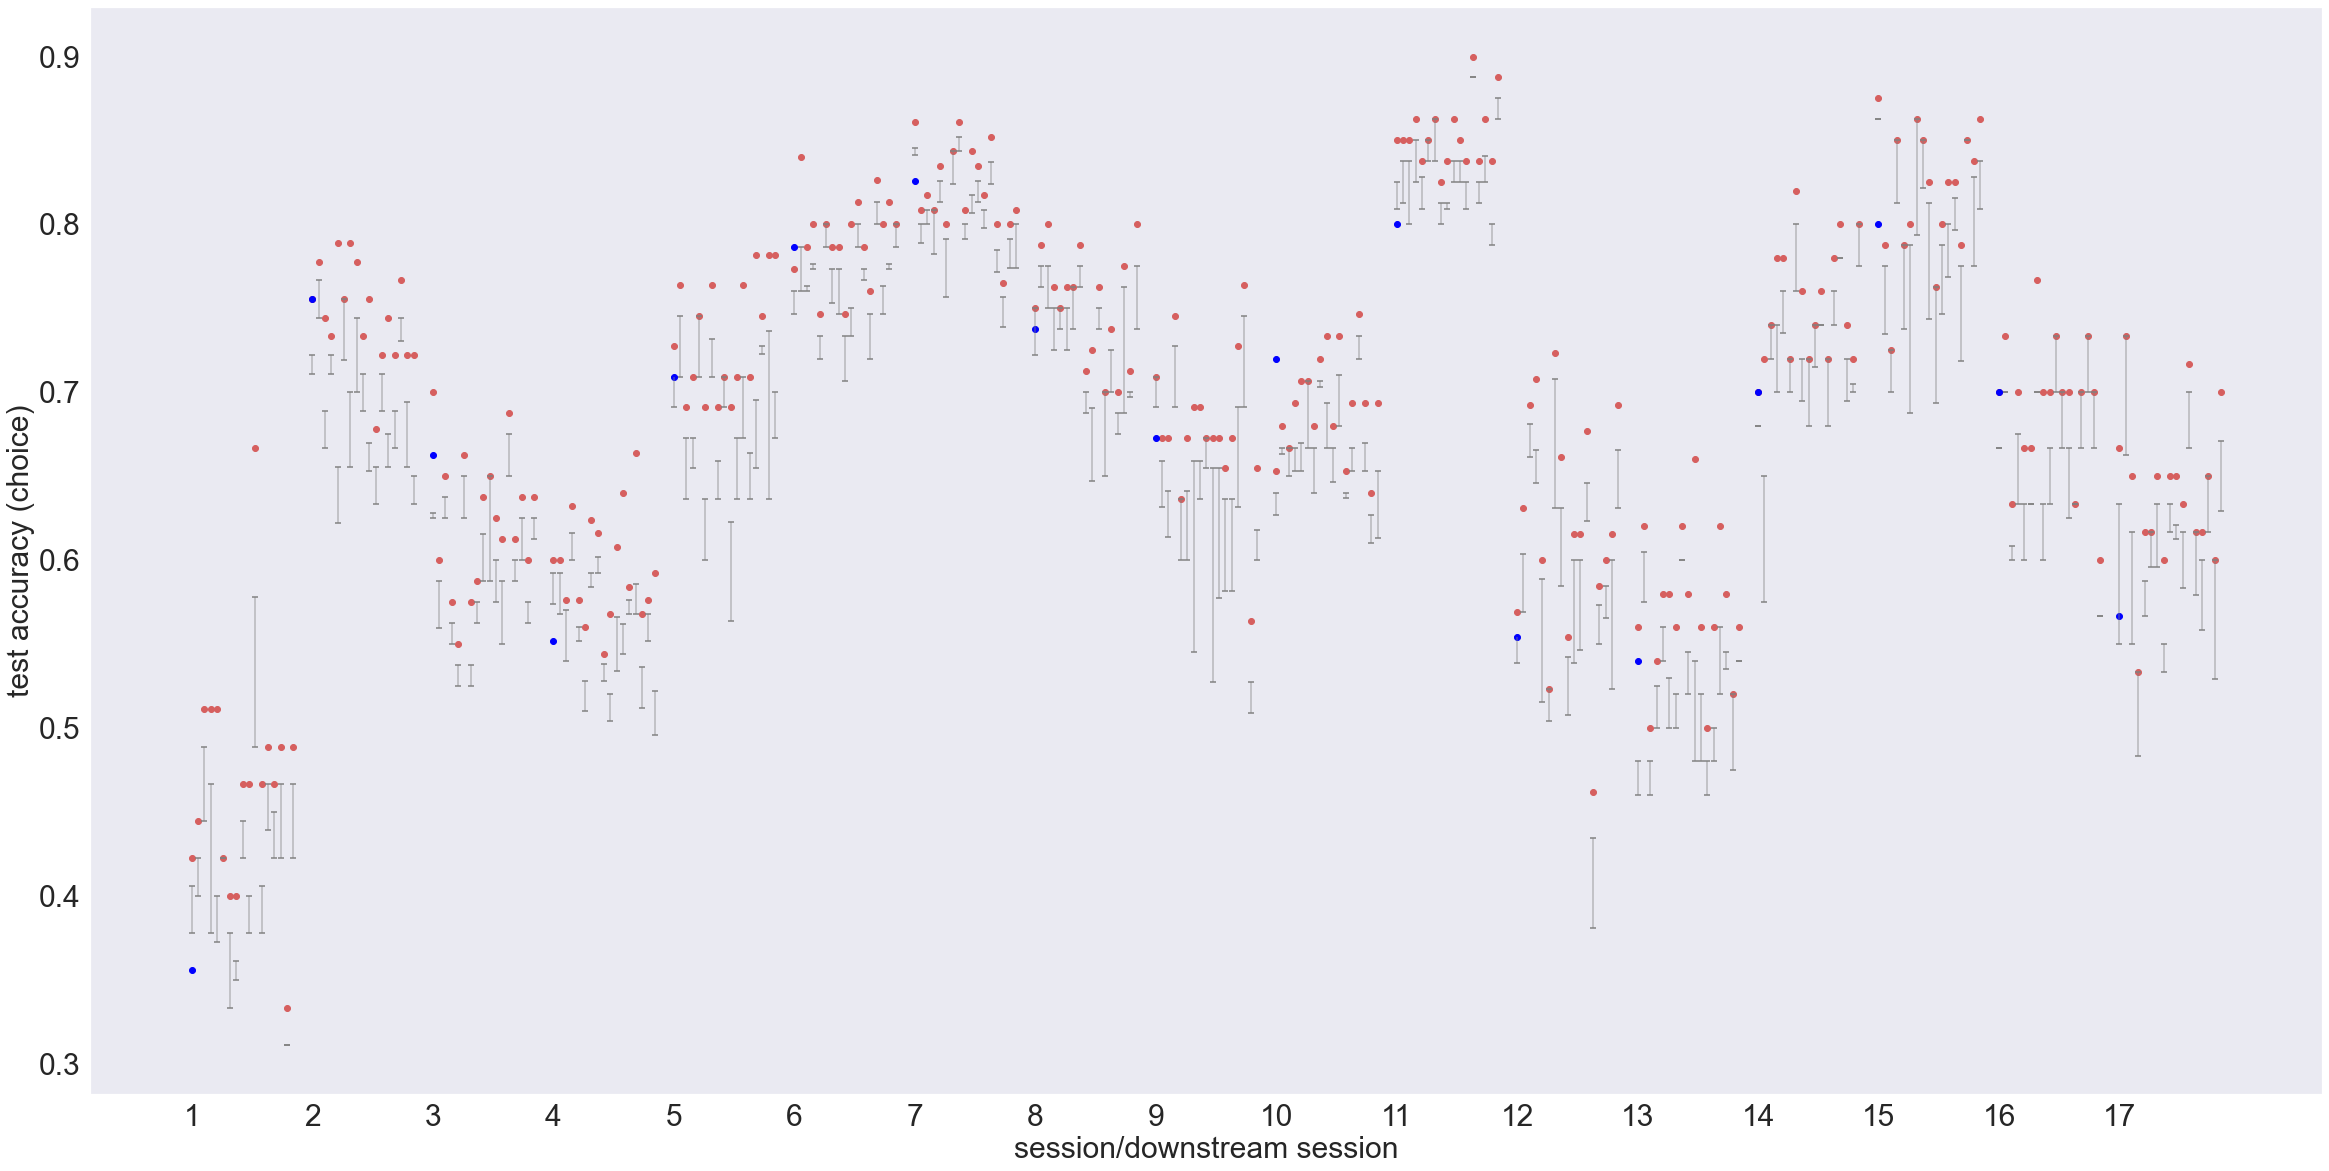

In [588]:
# WITH POSTERIOR TRANSFER (after every epoch)
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[:17],[accs_with__posteriortransfer4[s-1,s2-1,:].max() for s in range(1,18)],
                c='r',label='with transfer')

    plt.vlines(s2+np.linspace(0,1,20)[:17],
               [np.quantile(accs_with__posteriortransfer4[s-1,s2-1,:],0.25) for s in range(1,18)],
               [np.quantile(accs_with__posteriortransfer4[s-1,s2-1,:],0.75) for s in range(1,18)],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[:17],[np.quantile(accs_with__posteriortransfer4[s-1,s2-1,:],0.25) for s in range(1,18)],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[:17],[np.quantile(accs_with__posteriortransfer4[s-1,s2-1,:],0.75) for s in range(1,18)],
               color='gray',marker='_')
    
    
for s in range(1,18):
    plt.scatter(s,accs_without__posteriortransfer4[s-1,:].max(),c='blue',label='without transfer')

plt.xticks(np.arange(1,18),size=30)[1];  plt.yticks(size=30)
plt.xlabel('session/downstream session',size=30); plt.ylabel('test accuracy (choice)',size=30)

<a list of 17 Text major ticklabel objects>

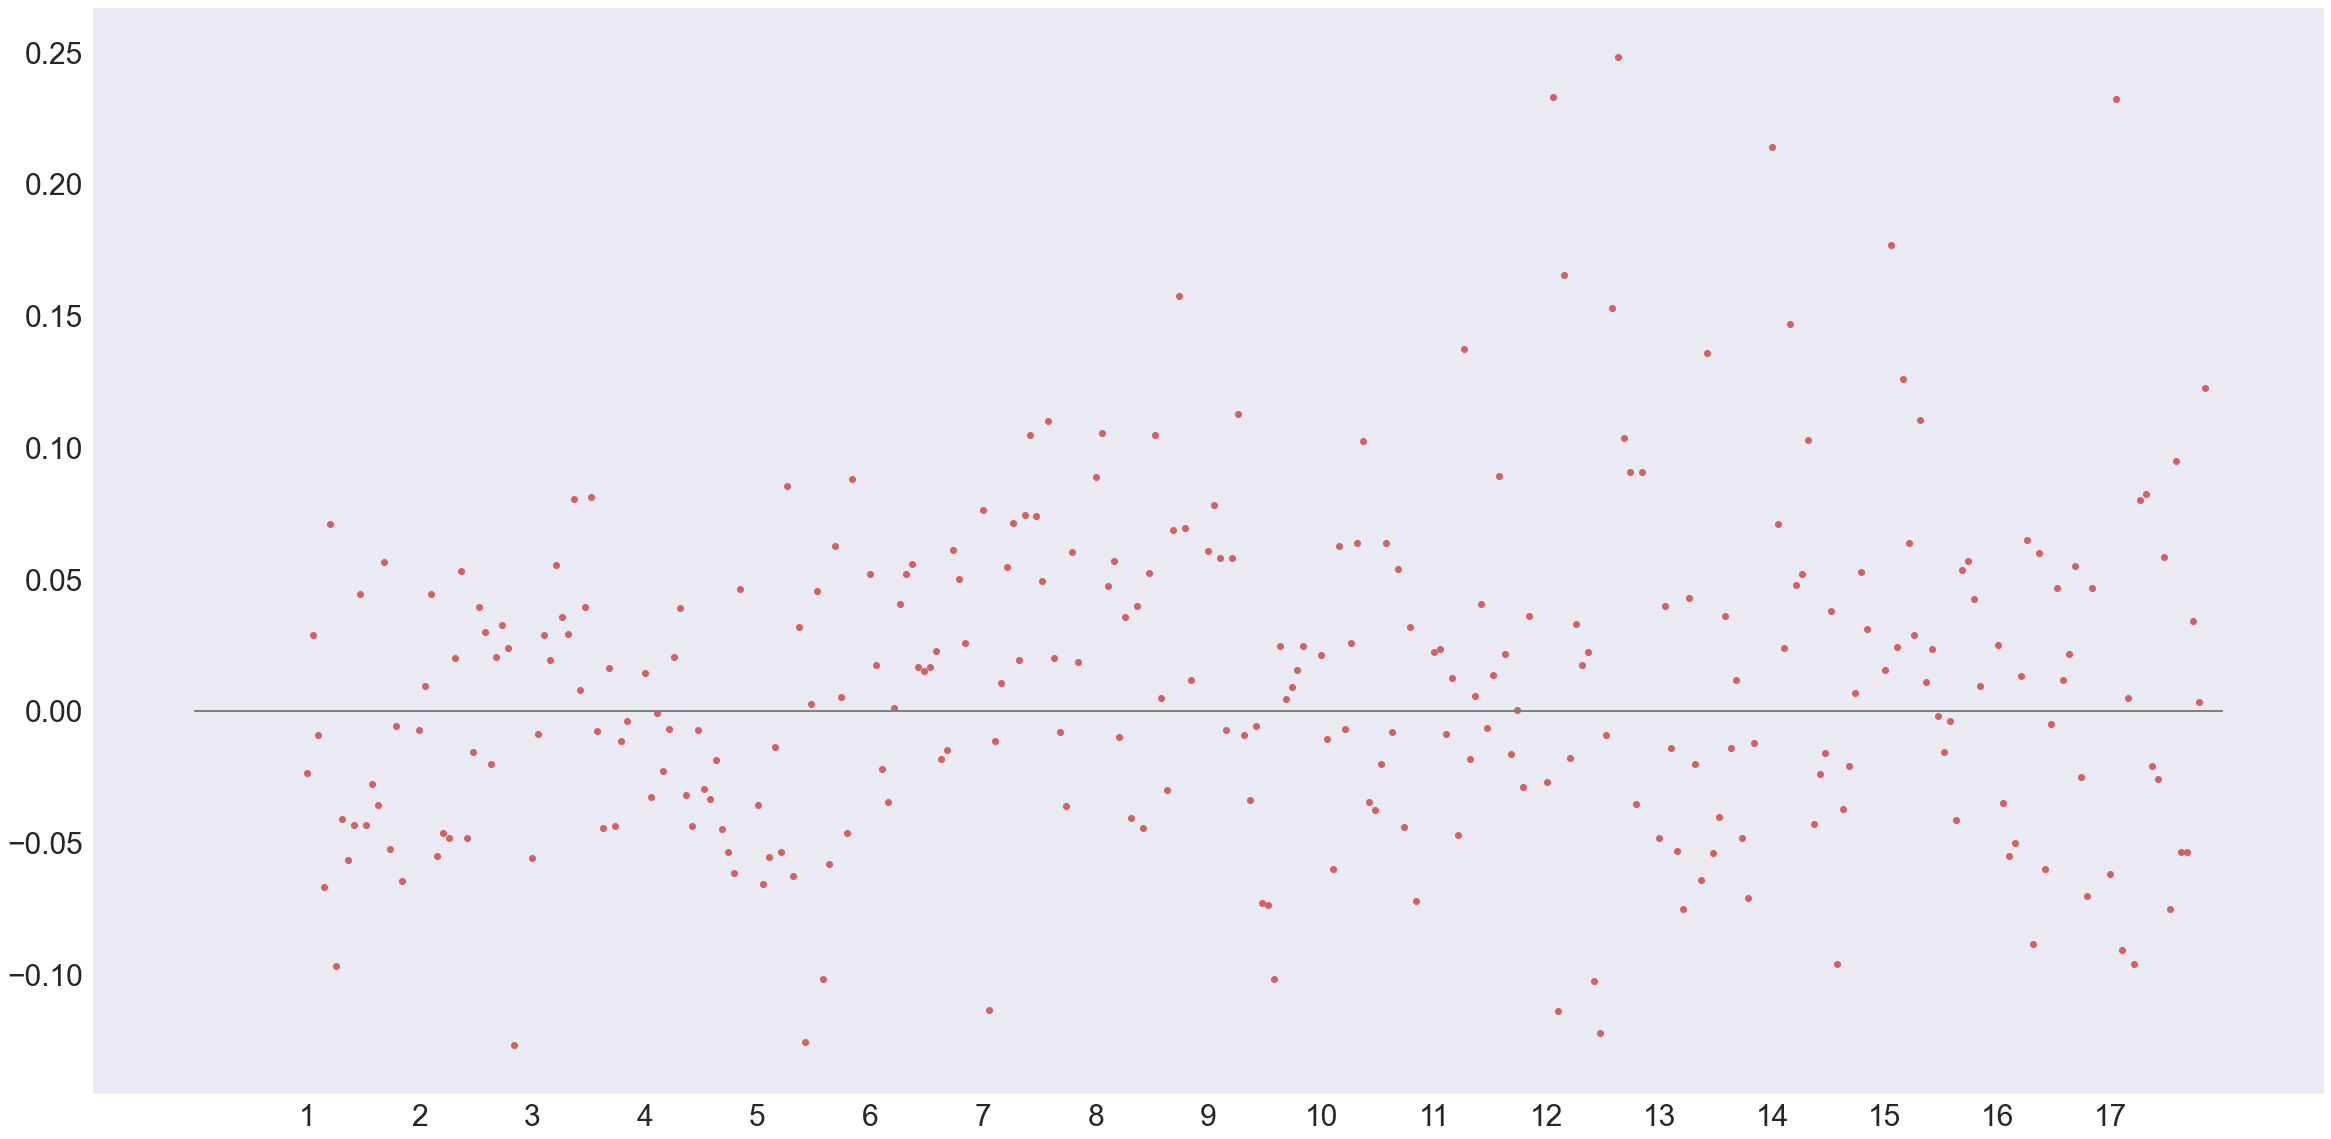

In [638]:
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[:17],[accs_with__posteriortransfer[s-1,s2-1,:].mean()-accs_with[s-1,s2-1,:].mean() for s in range(1,18)],
                c='r',label='with transfer')
    plt.hlines(0,0,18,color='gray',alpha=0.5)
    
plt.yticks(size=30)
plt.xticks(np.arange(1,18),size=30)[1]

<a list of 20 Patch objects>

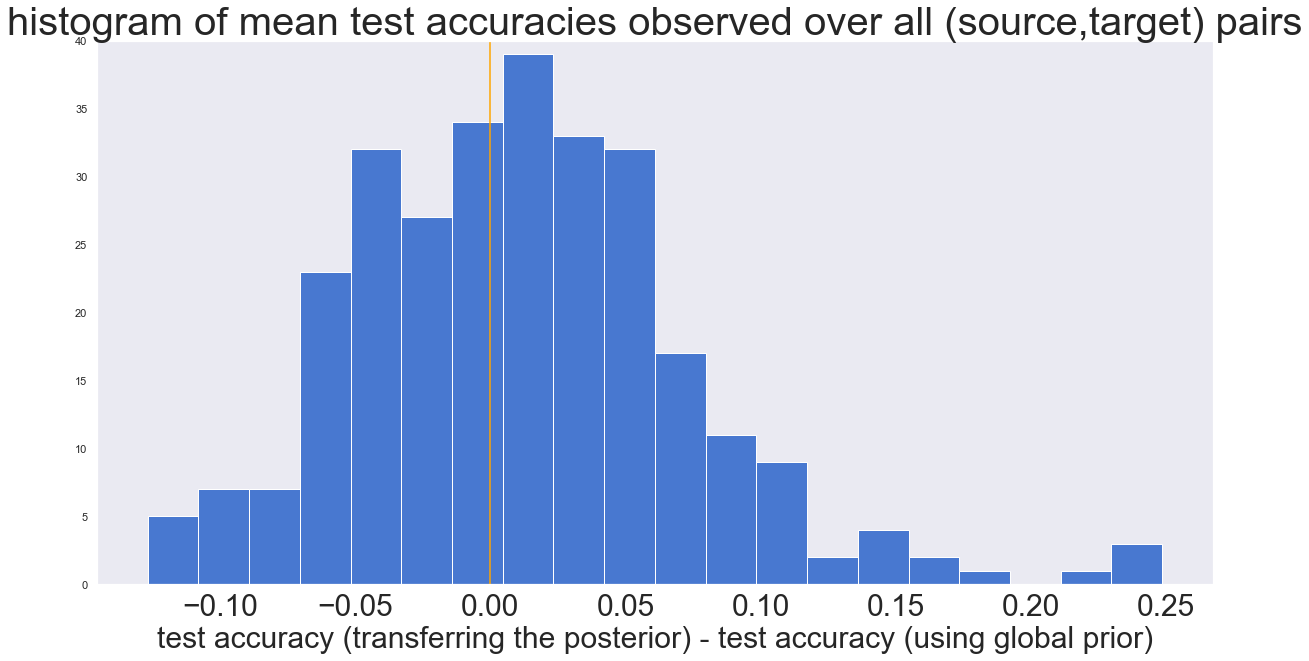

In [636]:
plt.figure(figsize=(20,10))
plt.title('histogram of mean test accuracies observed over all (source,target) pairs',size=40)
plt.xlabel('test accuracy (transferring the posterior) - test accuracy (using global prior)',size=30)
plt.vlines(0,0,40,color='orange')
plt.xticks(size=30)
plt.ylim((0,40))
plt.hist([accs_with__posteriortransfer[s-1,s2-1,:].mean()- accs_with[s-1,s2-1,:].mean() for s in range(1,18) for s2 in range(1,18)],bins=20)[2]

<a list of 20 Patch objects>

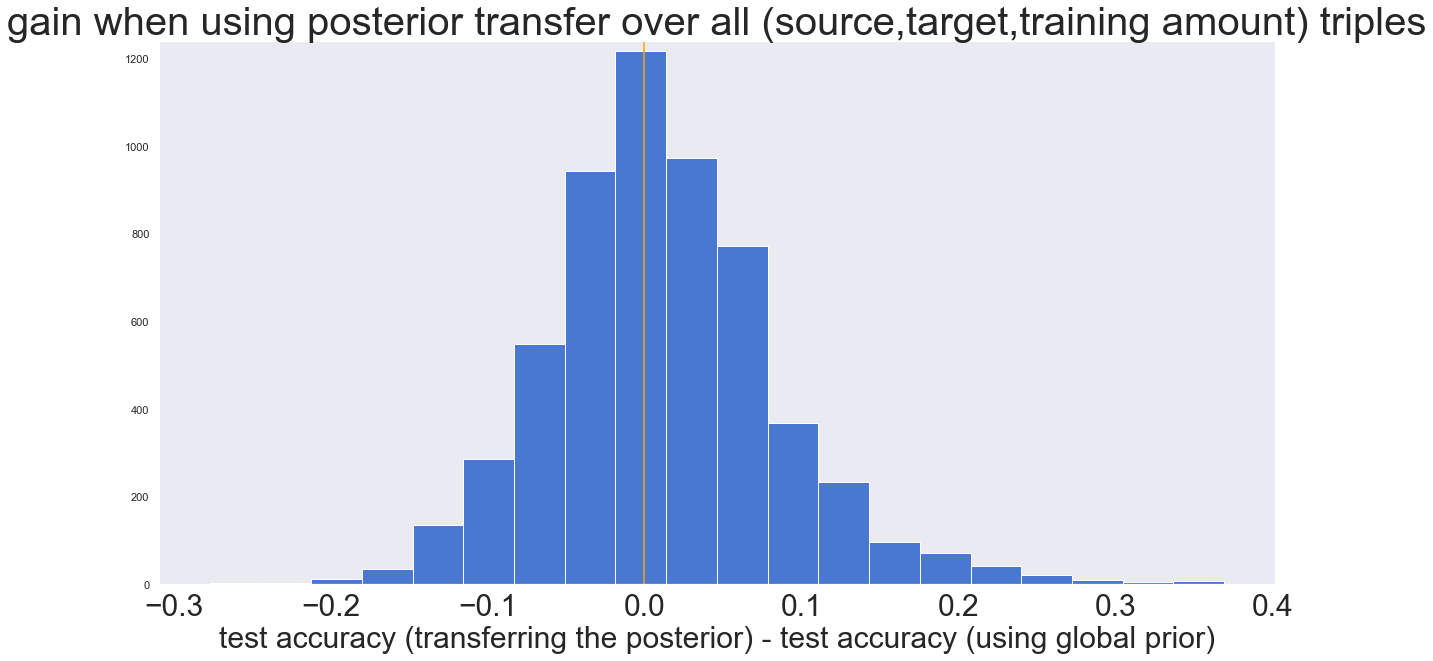

In [660]:
plt.figure(figsize=(20,10))
plt.title('gain when using posterior transfer over all (source,target,training amount) triples',size=40)
plt.xlabel('test accuracy (transferring the posterior) - test accuracy (using global prior)',size=30)
plt.vlines(0,0,1240,color='orange')
plt.xticks(size=30)
plt.ylim((0,1240))
plt.hist([accs_with__posteriortransfer[s-1,s2-1,t] - accs_with[s-1,s2-1,t] for s in range(1,18) for s2 in range(1,18) for t in range(20)],bins=20)[2]

In [649]:
sum([accs_with__posteriortransfer[s-1,s2-1,t] > accs_with[s-1,s2-1,t] for s in range(1,18) for s2 in range(1,18) for t in range(20)])/len([accs_with__posteriortransfer[s-1,s2-1,t] > accs_with[s-1,s2-1,t] for s in range(1,18) for s2 in range(1,18) for t in range(20)])

0.49982698961937716

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 9 Text major ticklabel objects>)

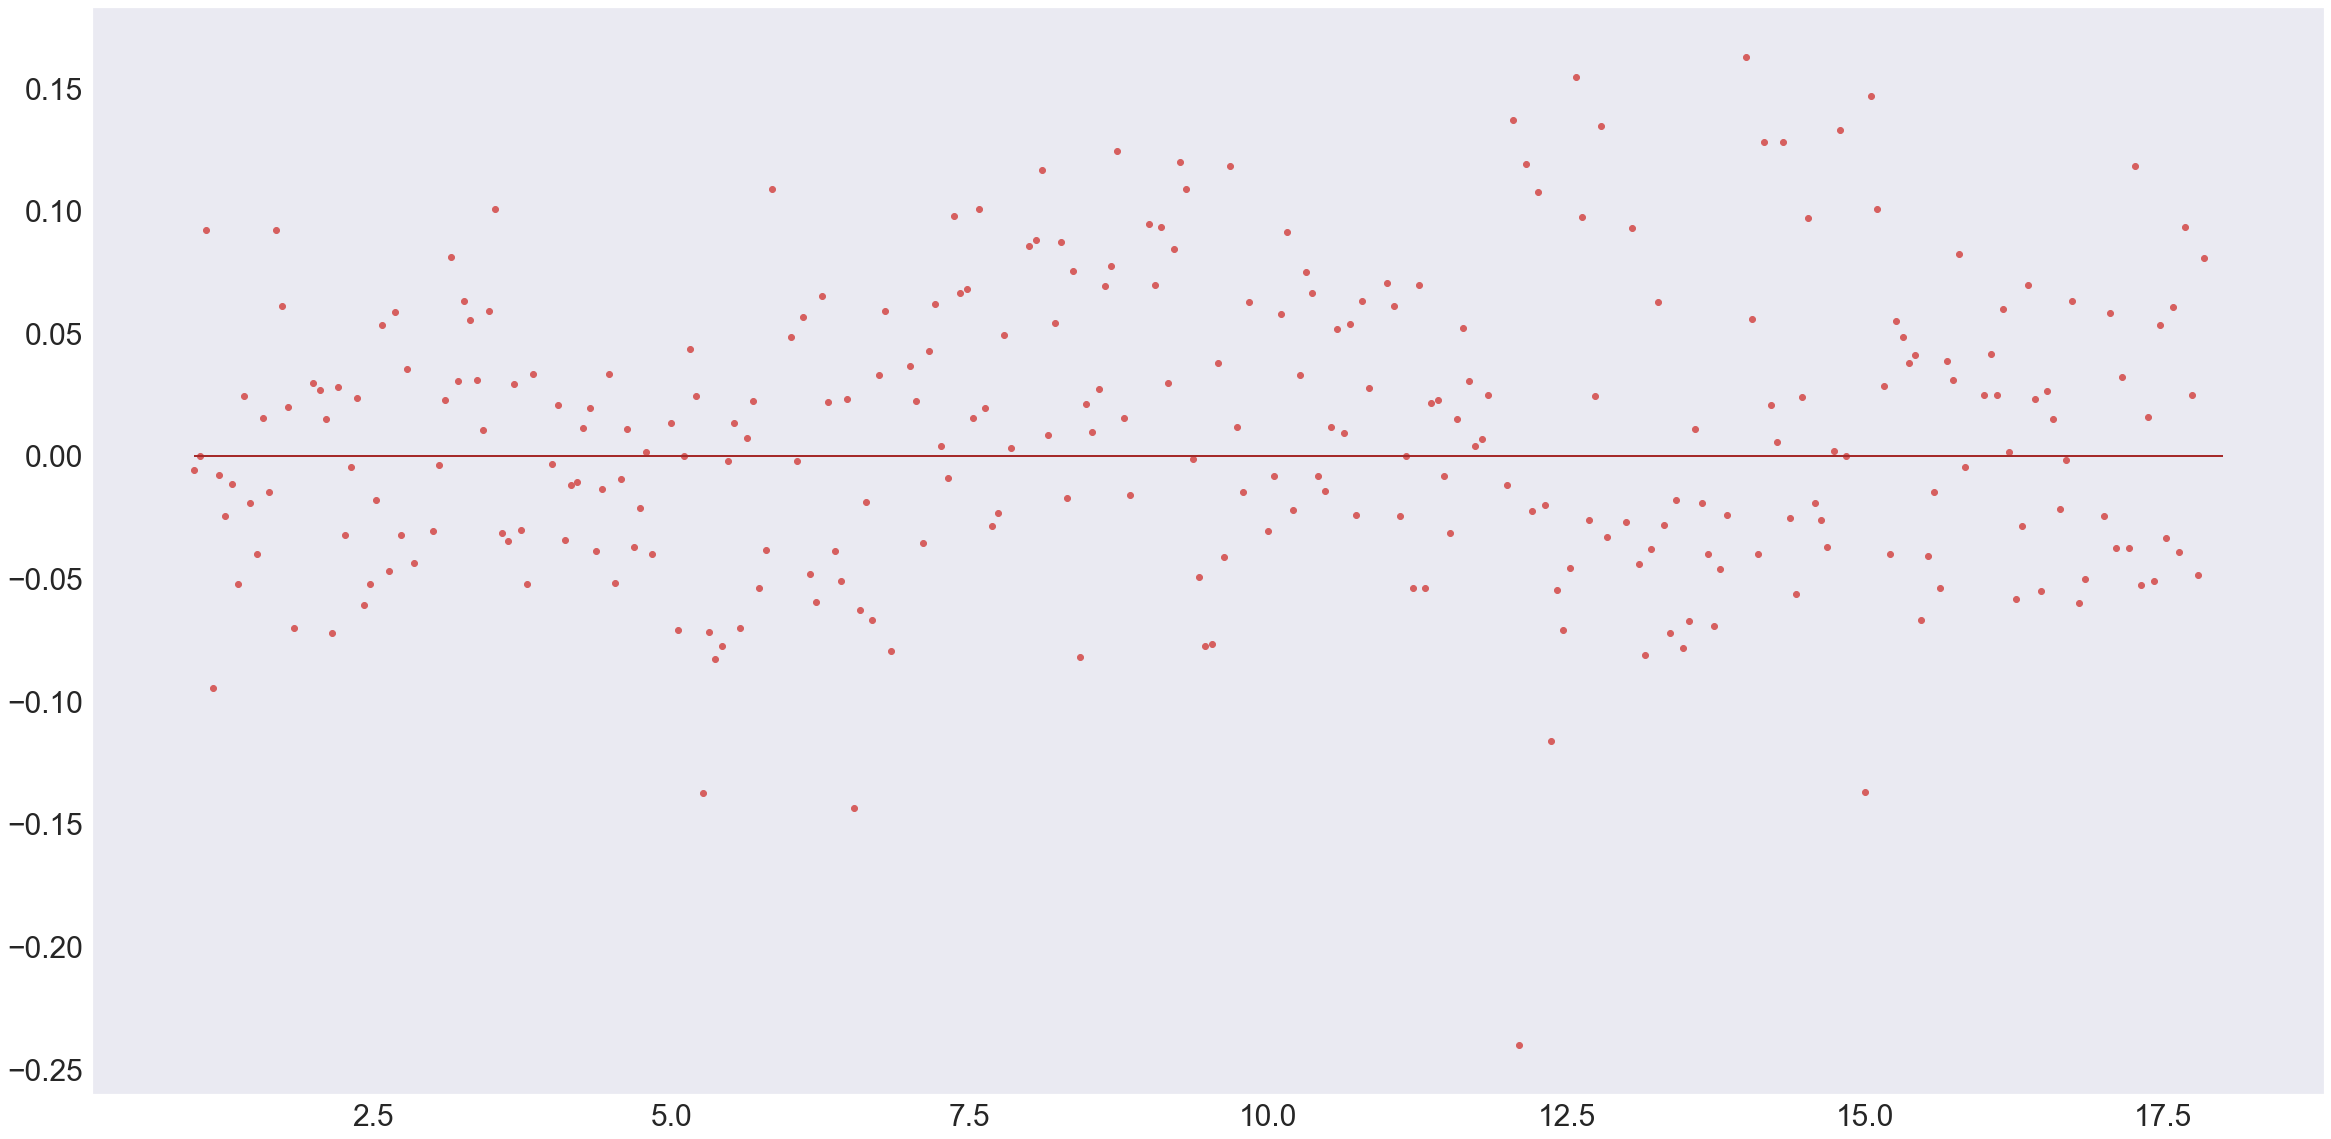

In [579]:
# modified posterior transfer (transfer only once after 20 epochs, and then every 4)
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[:17],[accs_with__posteriortransfer2[s-1,s2-1,:].mean()-accs_with[s-1,s2-1,:].mean() for s in range(1,18)],
                c='r',label='with transfer')
    plt.hlines(0,1,18,color='brown',alpha=0.5)
    
plt.yticks(size=30)
plt.xticks(size=30)

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 9 Text major ticklabel objects>)

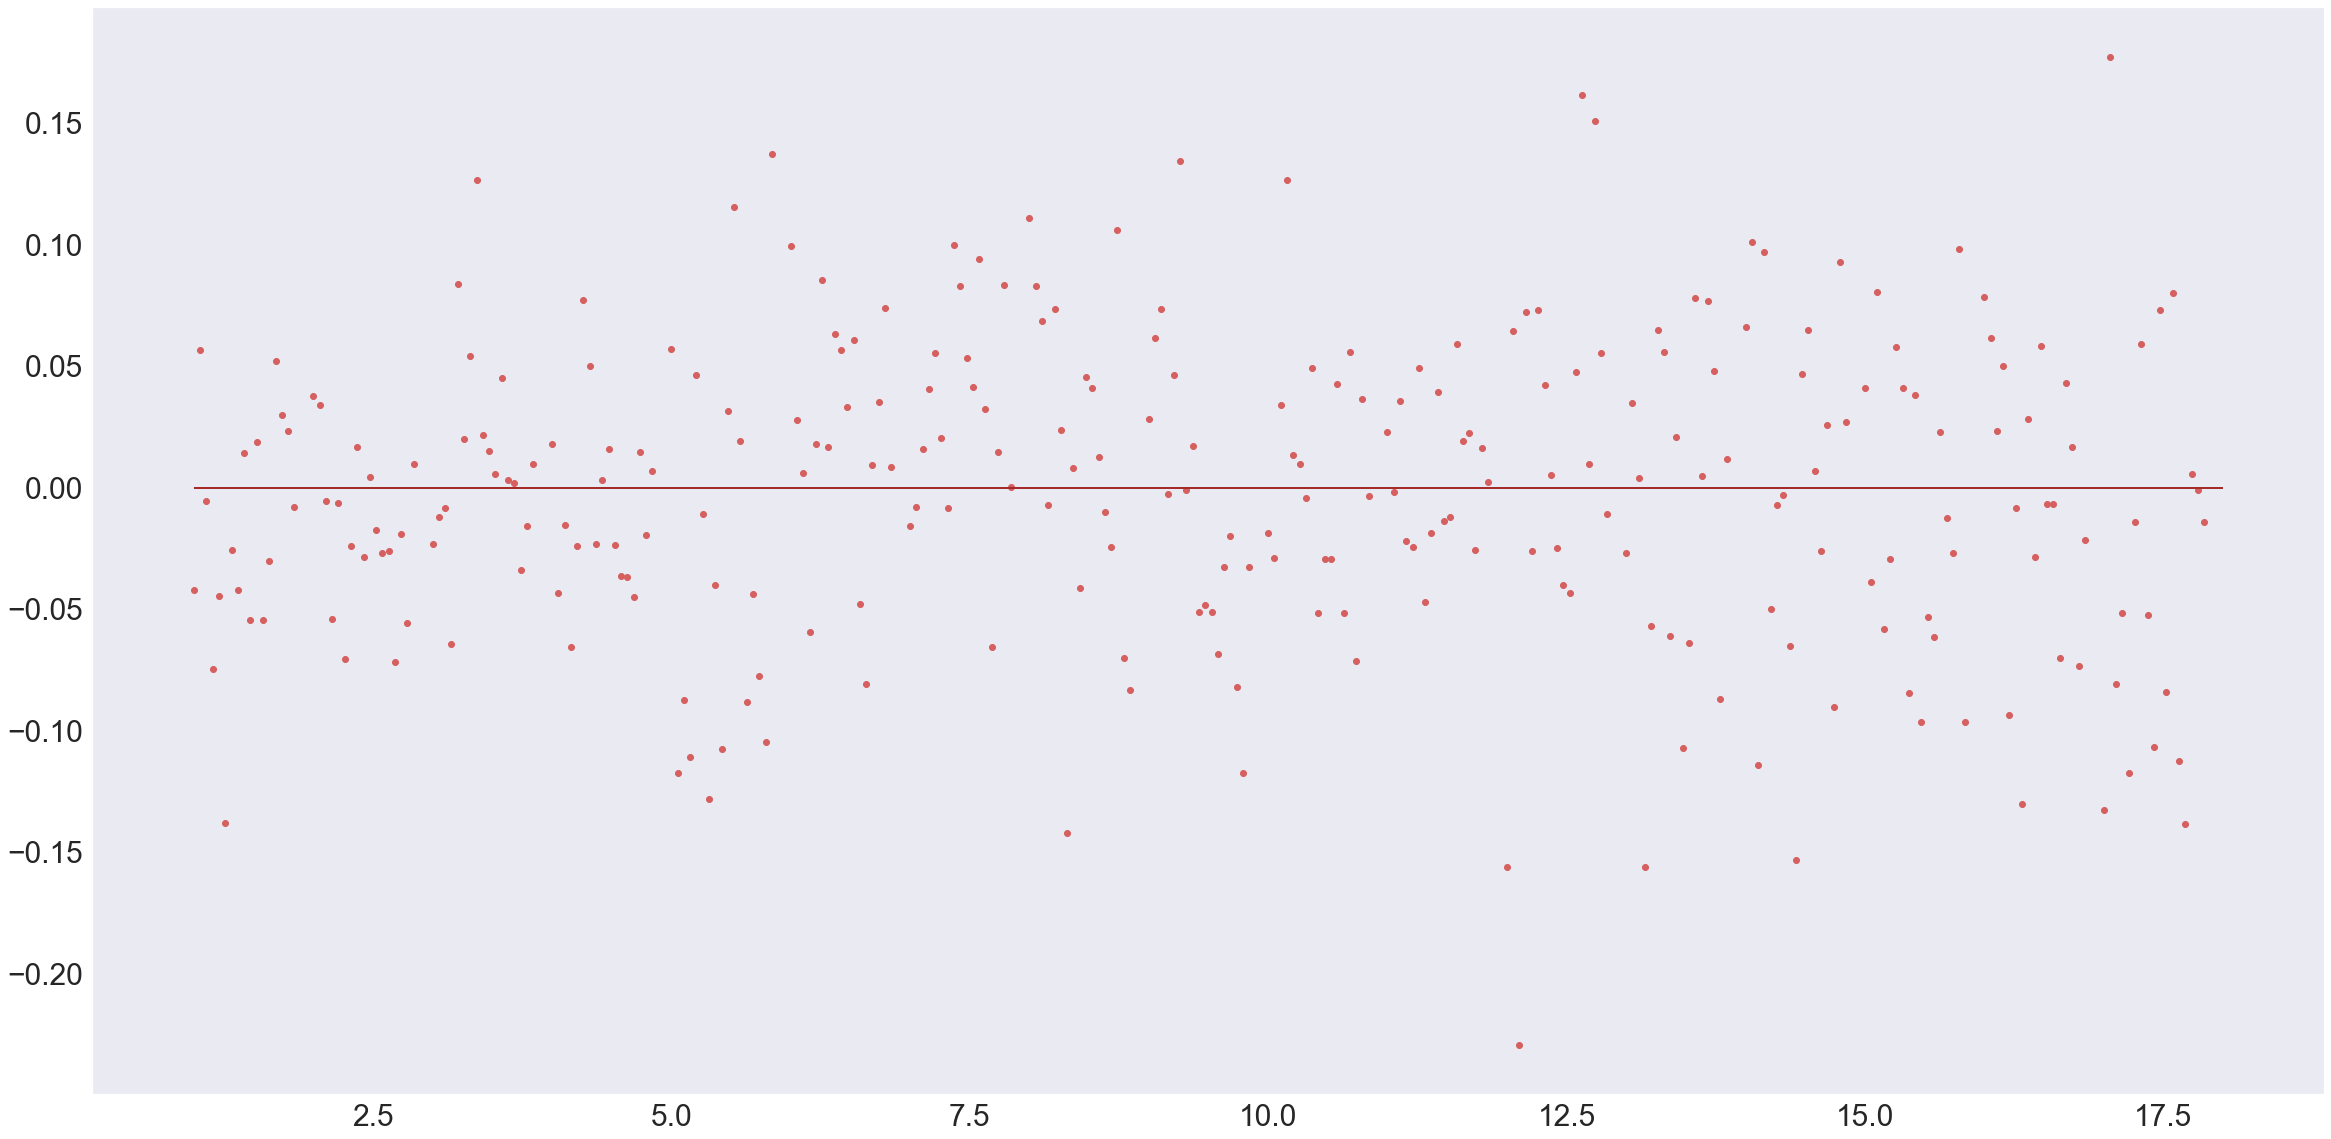

In [584]:
# modified posterior transfer (v3) (transfer after every epoch, and then every 4 in the last 80 rounds)
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[:17],[accs_with__posteriortransfer3[s-1,s2-1,:].mean()-accs_with[s-1,s2-1,:].mean() for s in range(1,18)],
                c='r',label='with transfer')
    plt.hlines(0,1,18,color='brown',alpha=0.5)
    
plt.yticks(size=30)
plt.xticks(size=30)

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 9 Text major ticklabel objects>)

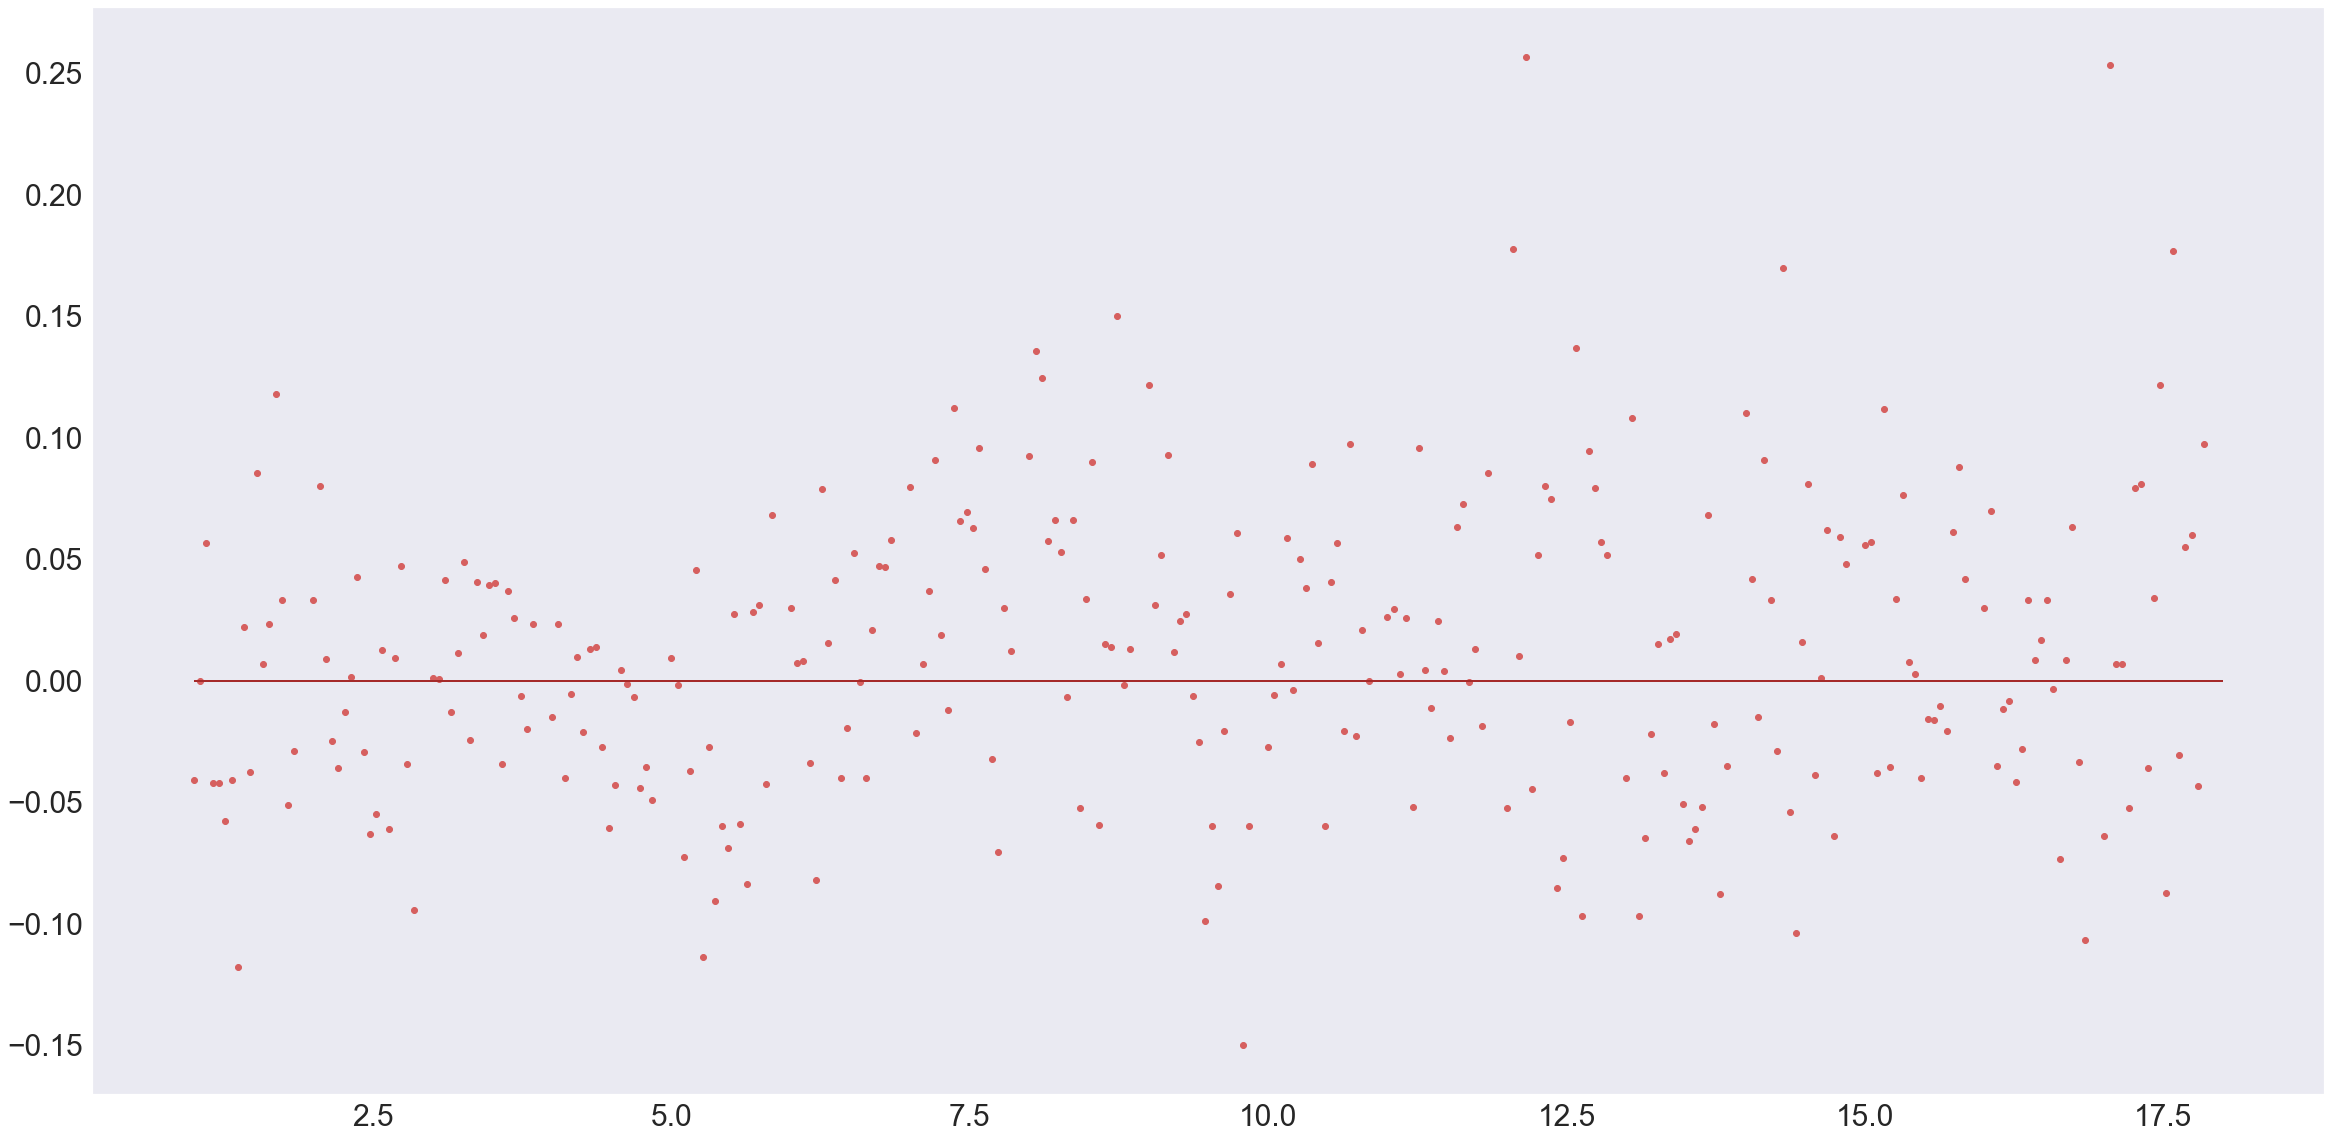

In [593]:
# modified posterior transfer (v4) (transfer after every epoch)
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[:17],[accs_with__posteriortransfer4[s-1,s2-1,:].mean()-accs_with[s-1,s2-1,:].mean() for s in range(1,18)],
                c='r',label='with transfer')
    plt.hlines(0,1,18,color='brown',alpha=0.5)
    
plt.yticks(size=30)
plt.xticks(size=30)

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 9 Text major ticklabel objects>)

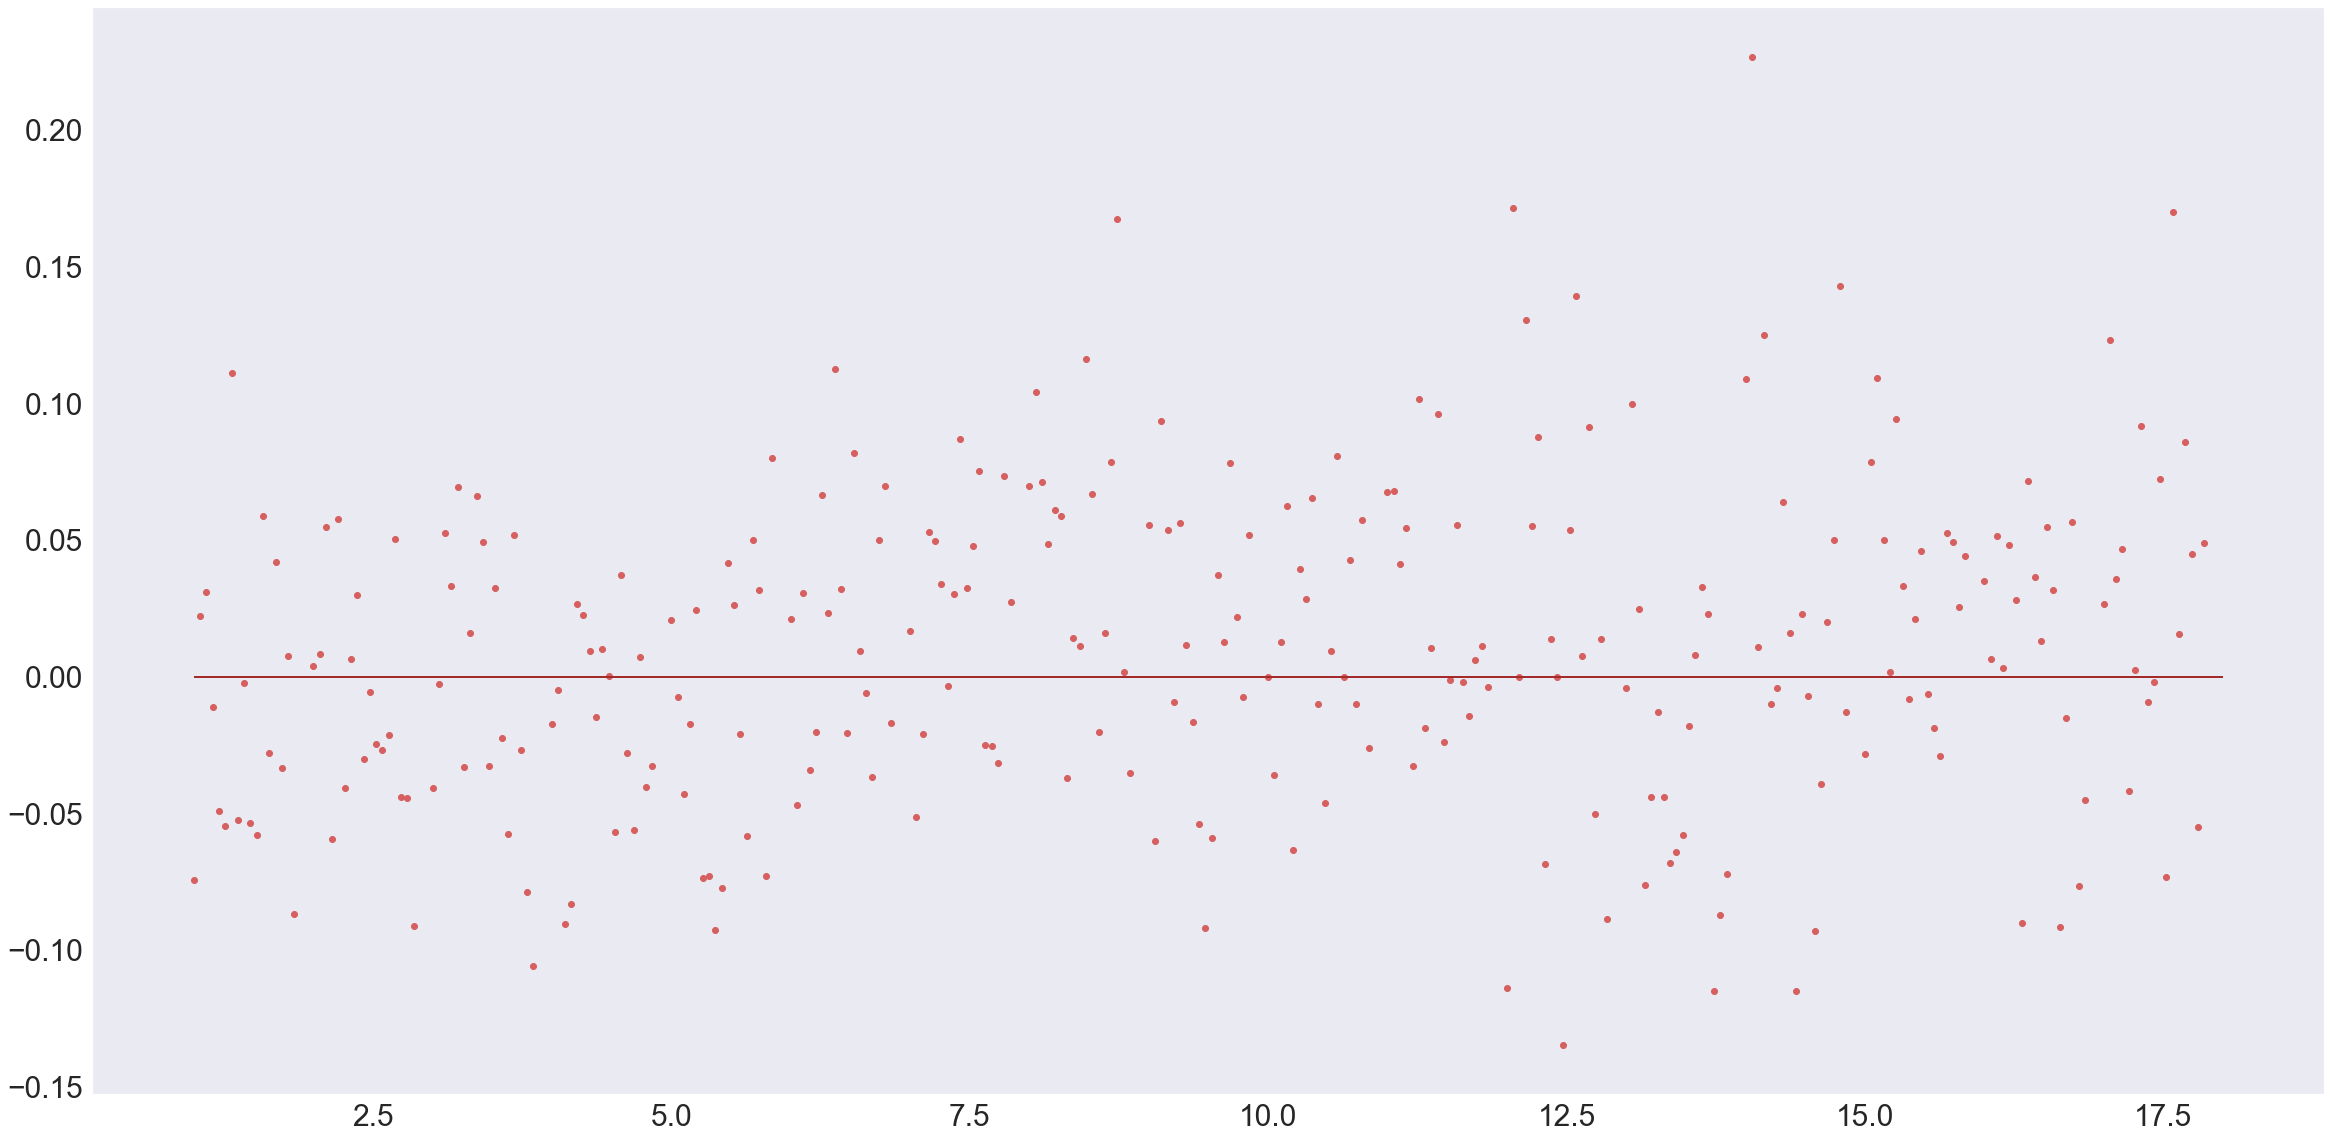

In [599]:
# modified posterior transfer (v5) (transfer after every epoch, 5 epochs to start, transfer every four in last 80)
plt.figure(figsize=(40,20))

for s2 in range(1,18):
    plt.scatter(s2+np.linspace(0,1,20)[:17],[accs_with__posteriortransfer5[s-1,s2-1,:].mean()-accs_with[s-1,s2-1,:].mean() for s in range(1,18)],
                c='r',label='with transfer')
    plt.hlines(0,1,18,color='brown',alpha=0.5)
    
plt.yticks(size=30)
plt.xticks(size=30)